In [1]:
import torch
import torch.nn as nn
from utils import data_loader
from utils.viewer import show_batch
import time
from mnist_classifier import test_model
from multiple_attacks import *
import numpy as np

In [2]:
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [3]:
train_set, test_set = data_loader.get_data()

In [4]:
class VFAE_CONV_NeuralModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(

            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)

        )

        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 16, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True)
        )

        self.fc_mu = nn.Linear(50, 50)
        self.fc_log_var = nn.Linear(50, 50)

        # Sampling vector
        self.latent = nn.Sequential(

            nn.Linear(50, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(inplace=True),

            nn.Linear(50, 7 * 7 * 16),
            nn.BatchNorm1d(7 * 7 * 16),
            nn.ReLU(inplace=True)

        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()

        )

    def reparameterize(self, mean, log_var):
        if self.training:
            std = log_var.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mean)
        else:
            return mean

    def forward(self, x):
        z, mu, log_var = self.get_latent(x)
        feature_map_latent = z.view(-1, 16, 7, 7)

        decoded = self.decoder(feature_map_latent)
        output = decoded.view(-1, 1, 28, 28)

        return output, mu, log_var
    
    def get_latent(self, x):
        encoded = self.encoder(x)

        encoded = encoded.view(-1, 7 * 7 * 16)

        fc = self.fc(encoded)

        mu = self.fc_mu(fc)
        log_var = self.fc_log_var(fc)

        z = self.reparameterize(mu, log_var)
        latent = self.latent(z)
        
        return latent, mu, log_var
        
        

In [5]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# vae = VAE_FC_NeuralModel()

def VAELoss(x_hat, x, mu, logvar, a, b):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return a*BCE + b*KLD

In [6]:
b_size = 256
def MMD_Loss(x, y):
    
    alpha =1
    B=b_size

    x = x.view(x.size(0), x.size(1) * 1)
    y = y.view(y.size(0), y.size(1) * 1)

    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    K = torch.exp(- alpha * (rx.t() + rx - 2*xx))
    L = torch.exp(- alpha * (ry.t() + ry - 2*yy))
    P = torch.exp(- alpha * (rx.t() + ry - 2*zz))

    beta = (1./(B*(B-1)))
    gamma = (2./(B*B)) 

    return beta * (torch.sum(K)+torch.sum(L)) - gamma * torch.sum(P)

In [7]:
def train_vae(model, train_data,a, b, adv_examples = False):
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    model.to(device)
    if adv_examples is True: 
    # invariant representation training
        for train in train_data:
            for batch in train:
                batch_images, adv_images, batch_labels = batch

                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)
                adv_images = adv_images.to(device)

                batch_output, mean, log_var = model(batch_images)

                latent_1, _, _ = model.get_latent(batch_images.detach())
                latent_2, _, _ = model.get_latent(adv_images.detach())

                down_stream_loss = VAELoss(batch_output, batch_images.detach(), mean, log_var, a, b)
                representation_loss = MMD_Loss(latent_1, latent_2)

                total_loss = .00001*down_stream_loss + 10000*representation_loss


                optimizer.zero_grad()
                total_loss.backward(retain_graph=True)
                optimizer.step()

                print("The classification loss after processing this batch is: ", down_stream_loss.item())
                print("The representation loss after processing this batch is: ", representation_loss.item())

    else:
        ## normal training
        for batch in train_data:
            batch_images, _ = batch
            batch_images = batch_images.to(device)

            batch_output, mean, log_var = model(batch_images)
            loss = VAELoss(batch_output, batch_images, mean, log_var, a, b)

            optimizer.zero_grad()
            loss.backward()
            print("*&**"*30)
            print("the loss after processing this batch is: ", loss.item())
            optimizer.step()

    return model

In [8]:
initial_vae = VFAE_CONV_NeuralModel().to(device)
#initial_vae = train_vae(initial_vae, train_loader, a=1, b=1, False)
#torch.save(initial_vae.state_dict(), "models/trained_vae_b=1_variant_rep")
initial_vae.load_state_dict(torch.load("models/trained_vae_b=1_variant_rep"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

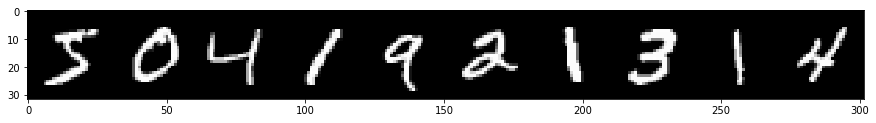

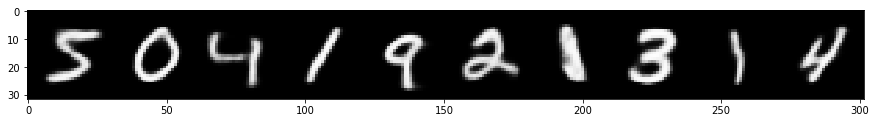

In [9]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
train_loader_iter = iter(train_loader)
first_images, first_labels = next(train_loader_iter)

show_batch(first_images)

recs, _, _ = initial_vae(first_images.to(device))
show_batch(recs.cpu())

In [10]:
class VFAEEClassifier(nn.Module):
    def __init__(self, beta, initial_VAE):
        super().__init__()
        
        self.vae = initial_vae
        
        self.classifier_part = self.encoder = nn.Sequential(

            nn.Conv2d(16, 14, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(14),
            nn.ReLU(inplace=True),

            nn.Conv2d(14, 12, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(12, 10, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(10),
            
        )
        
        self.fc = nn.Linear(10 * 1 * 1, 10)
        # no_of_last_channels* kernel_H * kernel_W, output_from_fully_conncected 
    def forward(self, x):
        #with torch.no_grad():
        vaee_features, _, _ = self.vae.get_latent(x)

        vaee_features = vaee_features.reshape(-1, 16, 7, 7)
        convolved = self.classifier_part(vaee_features)

        classification_logits = self.fc(convolved.view(convolved.size(0), -1))
        
        return  classification_logits
    

In [11]:
def train_classifier(model, train_data):
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_epochs = 10
    model.train()
    
    model.to(device)
    
    for epoch in range(n_epochs):
        if epoch %2 == 0:
            learning_rate /= 2.5
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for batch in train_data:
            batch_images, batch_labels = batch
            
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            batch_output = model(batch_images)
            loss = criterion(batch_output, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            model.vae = initial_classifier.vae
        print("the loss after processing this epoch is: ", loss.item())
            
    return model

In [12]:
b=1

initial_classifier = VFAEEClassifier(beta=b, initial_VAE=initial_vae).to(device)
model =  VFAEEClassifier(beta=b, initial_VAE=initial_vae).to(device)

batch_size = 256
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
model = train_classifier(model, train_loader)

the loss after processing this epoch is:  0.08944080024957657
the loss after processing this epoch is:  0.09544851630926132
the loss after processing this epoch is:  0.11544599384069443
the loss after processing this epoch is:  0.11405224353075027
the loss after processing this epoch is:  0.10771428793668747
the loss after processing this epoch is:  0.09536191076040268
the loss after processing this epoch is:  0.0981067642569542
the loss after processing this epoch is:  0.08519718796014786
the loss after processing this epoch is:  0.08605923503637314
the loss after processing this epoch is:  0.07789313048124313


In [13]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
testing_accuracy_before_attack = test_model(model, test_loader)
print(testing_accuracy_before_attack)

0.9927


In [14]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512)
print(attack(model, device, train_loader, fgsm, 0.3)[0])
print("=*" * 20)

print(attack(model, device, train_loader, pgd, 0.3, 1e4, 40)[0])
print("=*" * 20)

print(attack(model, device, train_loader, pgd_linf, 0.3, 1e-2, 40)[0])
print("=*" * 20)

print(attack(model, device, train_loader, pgd_l2, 1, 0.3, 40)[0])

FGSM Attack : 
0.28551666666666664
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Projected Gradient Attack : 
0.1627
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
iFGSM Attack : 
0.0008833333333333333
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Deep Fool Attack : 
0.148


In [15]:
def get_training_examples(model): 
    training_examples = []

    examples = get_examples(model, device, train_loader, fgsm, 0.3)
    training_examples.append(examples)

    examples = get_examples(model, device, train_loader, pgd, 0.3, 1e4, 40)
    training_examples.append(examples)

    examples = get_examples(model, device, train_loader, pgd_linf, 0.3, 1e-2, 40)
    training_examples.append(examples)
    training_examples.append(examples)
    training_examples.append(examples)
    training_examples.append(examples)
    
    examples = get_examples(model, device, train_loader, pgd_l2, 1.3, 0.3, 40)

    return training_examples

In [16]:
def train_classifier_adv(model, train_data):
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_epochs = 10
    model.train()
    
    model.to(device)
    
    for epoch in range(n_epochs):
        if epoch %2 == 0:
            learning_rate /= 2.5
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for train in train_data:
            for batch in train:
                batch_images, adv_images, batch_labels = batch

                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)
                adv_images = adv_images.to(device)

                batch_output = model(batch_images)
                loss = criterion(batch_output, batch_labels)
                
                adv_output = model(adv_images)
                
                loss += criterion(adv_output, batch_labels )
                optimizer.zero_grad()
                loss.backward()

                optimizer.step()
                model.vae = initial_classifier.vae
        print("the loss after processing this epoch is: ", loss.item())
            
    return model

In [17]:
vafee = VFAE_CONV_NeuralModel().to(device)
initial_classifier = VFAEEClassifier(beta=b, initial_VAE=vafee).to(device)

for i in range(10):
    training_examples = get_training_examples(model)
    vafee = train_vae(vafee, training_examples, 1, 1, adv_examples= True)
   
    model =  VFAEEClassifier(beta=1, initial_VAE=vafee).to(device)

    batch_size = 128
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    model = train_classifier_adv(model, training_examples)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Using a target size (torch.Size([256, 784])) that is different to the input size (torch.Size([256, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  # Remove the CWD from sys.path while we load stuff.


The classification loss after processing this batch is:  191998.59375
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  154640.09375
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  115534.34375
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  92744.484375
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  81997.5625
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  77827.59375
The representation loss after processing this batch is:  0.007843137718737125
The classification loss after processing this batch is:  68335.109375
The representation loss after processing this

The classification loss after processing this batch is:  52035.8984375
The representation loss after processing this batch is:  0.007843145169317722
The classification loss after processing this batch is:  43941.8984375
The representation loss after processing this batch is:  0.007843147963285446
The classification loss after processing this batch is:  44601.99609375
The representation loss after processing this batch is:  0.007843263447284698
The classification loss after processing this batch is:  43935.390625
The representation loss after processing this batch is:  0.007843131199479103
The classification loss after processing this batch is:  46867.55859375
The representation loss after processing this batch is:  0.007843133062124252
The classification loss after processing this batch is:  45408.078125
The representation loss after processing this batch is:  0.007843135856091976
The classification loss after processing this batch is:  44877.484375
The representation loss after proces

The classification loss after processing this batch is:  41971.8671875
The representation loss after processing this batch is:  0.007843471132218838
The classification loss after processing this batch is:  40401.08984375
The representation loss after processing this batch is:  0.00784312654286623
The classification loss after processing this batch is:  40875.6640625
The representation loss after processing this batch is:  0.007842917926609516
The classification loss after processing this batch is:  42696.15234375
The representation loss after processing this batch is:  0.007843149825930595
The classification loss after processing this batch is:  42502.078125
The representation loss after processing this batch is:  0.007843160070478916
The classification loss after processing this batch is:  40589.0546875
The representation loss after processing this batch is:  0.00784311257302761
The classification loss after processing this batch is:  40549.36328125
The representation loss after proce

The classification loss after processing this batch is:  39720.71484375
The representation loss after processing this batch is:  0.007842816412448883
The classification loss after processing this batch is:  41912.3515625
The representation loss after processing this batch is:  0.007843333296477795
The classification loss after processing this batch is:  40263.6796875
The representation loss after processing this batch is:  0.00784310046583414
The classification loss after processing this batch is:  40368.84765625
The representation loss after processing this batch is:  0.00784308835864067
The classification loss after processing this batch is:  40470.69921875
The representation loss after processing this batch is:  0.007842942140996456
The classification loss after processing this batch is:  42683.5234375
The representation loss after processing this batch is:  0.007842814549803734
The classification loss after processing this batch is:  40549.59375
The representation loss after proces

The classification loss after processing this batch is:  185586.796875
The representation loss after processing this batch is:  0.000838451087474823
The classification loss after processing this batch is:  187145.0
The representation loss after processing this batch is:  0.0007961615920066833
The classification loss after processing this batch is:  190342.5
The representation loss after processing this batch is:  0.0008919909596443176
The classification loss after processing this batch is:  194720.9375
The representation loss after processing this batch is:  0.0009615868330001831
The classification loss after processing this batch is:  197307.078125
The representation loss after processing this batch is:  0.0007422119379043579
The classification loss after processing this batch is:  181949.265625
The representation loss after processing this batch is:  0.0006773993372917175
The classification loss after processing this batch is:  66573.5625
The representation loss after processing this

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Using a target size (torch.Size([96, 784])) that is different to the input size (torch.Size([96, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  # Remove the CWD from sys.path while we load stuff.


The classification loss after processing this batch is:  195113.15625
The representation loss after processing this batch is:  0.0008648186922073364
The classification loss after processing this batch is:  191429.0625
The representation loss after processing this batch is:  0.00082368403673172
The classification loss after processing this batch is:  190814.328125
The representation loss after processing this batch is:  0.0008538663387298584
The classification loss after processing this batch is:  188905.28125
The representation loss after processing this batch is:  0.0007703900337219238
The classification loss after processing this batch is:  193938.03125
The representation loss after processing this batch is:  0.0007880181074142456
The classification loss after processing this batch is:  189462.125
The representation loss after processing this batch is:  0.0007653534412384033
The classification loss after processing this batch is:  191192.4375
The representation loss after processing 

The classification loss after processing this batch is:  119778.65625
The representation loss after processing this batch is:  0.000553518533706665
The classification loss after processing this batch is:  112213.125
The representation loss after processing this batch is:  0.000490482896566391
The classification loss after processing this batch is:  113021.671875
The representation loss after processing this batch is:  0.0005359463393688202
The classification loss after processing this batch is:  112413.6171875
The representation loss after processing this batch is:  0.0004915818572044373
The classification loss after processing this batch is:  115454.296875
The representation loss after processing this batch is:  0.0004813969135284424
The classification loss after processing this batch is:  108604.53125
The representation loss after processing this batch is:  0.0005258917808532715
The classification loss after processing this batch is:  109582.78125
The representation loss after proces

The classification loss after processing this batch is:  94376.5546875
The representation loss after processing this batch is:  0.0004168599843978882
The classification loss after processing this batch is:  92436.59375
The representation loss after processing this batch is:  0.00044365599751472473
The classification loss after processing this batch is:  90399.953125
The representation loss after processing this batch is:  0.00048480555415153503
The classification loss after processing this batch is:  93178.65625
The representation loss after processing this batch is:  0.0005148835480213165
The classification loss after processing this batch is:  97353.625
The representation loss after processing this batch is:  0.0005310848355293274
The classification loss after processing this batch is:  91384.9375
The representation loss after processing this batch is:  0.0004465356469154358
The classification loss after processing this batch is:  90772.5
The representation loss after processing this

The classification loss after processing this batch is:  86392.765625
The representation loss after processing this batch is:  0.0004507601261138916
The classification loss after processing this batch is:  90748.625
The representation loss after processing this batch is:  0.0003963857889175415
The classification loss after processing this batch is:  88176.75
The representation loss after processing this batch is:  0.0003485828638076782
The classification loss after processing this batch is:  87287.296875
The representation loss after processing this batch is:  0.0004332326352596283
The classification loss after processing this batch is:  87286.9921875
The representation loss after processing this batch is:  0.0004122816026210785
The classification loss after processing this batch is:  89895.3671875
The representation loss after processing this batch is:  0.0003889314830303192
The classification loss after processing this batch is:  87874.109375
The representation loss after processing 

The classification loss after processing this batch is:  81786.90625
The representation loss after processing this batch is:  0.00044128671288490295
The classification loss after processing this batch is:  81494.1875
The representation loss after processing this batch is:  0.0004401989281177521
The classification loss after processing this batch is:  80713.4453125
The representation loss after processing this batch is:  0.00043972209095954895
The classification loss after processing this batch is:  85815.03125
The representation loss after processing this batch is:  0.00042831897735595703
The classification loss after processing this batch is:  85875.515625
The representation loss after processing this batch is:  0.00040221214294433594
The classification loss after processing this batch is:  82506.96875
The representation loss after processing this batch is:  0.00044652819633483887
The classification loss after processing this batch is:  34480.92578125
The representation loss after pro

The classification loss after processing this batch is:  87373.484375
The representation loss after processing this batch is:  0.00017185509204864502
The classification loss after processing this batch is:  87805.421875
The representation loss after processing this batch is:  0.00017295777797698975
The classification loss after processing this batch is:  85284.921875
The representation loss after processing this batch is:  0.00016072019934654236
The classification loss after processing this batch is:  86512.609375
The representation loss after processing this batch is:  0.0002041459083557129
The classification loss after processing this batch is:  84520.3359375
The representation loss after processing this batch is:  0.00016089528799057007
The classification loss after processing this batch is:  84352.4296875
The representation loss after processing this batch is:  0.00016114488244056702
The classification loss after processing this batch is:  86140.6875
The representation loss after p

The classification loss after processing this batch is:  82317.578125
The representation loss after processing this batch is:  0.00016767345368862152
The classification loss after processing this batch is:  85925.109375
The representation loss after processing this batch is:  0.00019359588623046875
The classification loss after processing this batch is:  81990.4375
The representation loss after processing this batch is:  0.0001710541546344757
The classification loss after processing this batch is:  83221.265625
The representation loss after processing this batch is:  0.00016402080655097961
The classification loss after processing this batch is:  80783.453125
The representation loss after processing this batch is:  0.00018162839114665985
The classification loss after processing this batch is:  82710.59375
The representation loss after processing this batch is:  0.00016628392040729523
The classification loss after processing this batch is:  81978.6640625
The representation loss after pro

The classification loss after processing this batch is:  79276.4921875
The representation loss after processing this batch is:  0.00014988146722316742
The classification loss after processing this batch is:  78788.8984375
The representation loss after processing this batch is:  0.0001661386340856552
The classification loss after processing this batch is:  79426.953125
The representation loss after processing this batch is:  0.00016176141798496246
The classification loss after processing this batch is:  82313.1484375
The representation loss after processing this batch is:  0.00016370415687561035
The classification loss after processing this batch is:  82381.265625
The representation loss after processing this batch is:  0.000154862180352211
The classification loss after processing this batch is:  78946.6484375
The representation loss after processing this batch is:  0.00016182661056518555
The classification loss after processing this batch is:  78475.421875
The representation loss after

The classification loss after processing this batch is:  77690.8828125
The representation loss after processing this batch is:  0.00016324780881404877
The classification loss after processing this batch is:  78998.3046875
The representation loss after processing this batch is:  0.00016518495976924896
The classification loss after processing this batch is:  79567.765625
The representation loss after processing this batch is:  0.0001577083021402359
The classification loss after processing this batch is:  75591.0546875
The representation loss after processing this batch is:  0.00016758032143115997
The classification loss after processing this batch is:  79824.375
The representation loss after processing this batch is:  0.0001681596040725708
The classification loss after processing this batch is:  81217.6875
The representation loss after processing this batch is:  0.00015593692660331726
The classification loss after processing this batch is:  76403.8203125
The representation loss after pro

The classification loss after processing this batch is:  77643.53125
The representation loss after processing this batch is:  0.00014388933777809143
The classification loss after processing this batch is:  80515.015625
The representation loss after processing this batch is:  0.00015806220471858978
The classification loss after processing this batch is:  77443.03125
The representation loss after processing this batch is:  0.00014360062777996063
The classification loss after processing this batch is:  76439.265625
The representation loss after processing this batch is:  0.00015200674533843994
The classification loss after processing this batch is:  75833.6171875
The representation loss after processing this batch is:  0.00017031095921993256
The classification loss after processing this batch is:  74942.6015625
The representation loss after processing this batch is:  0.00014300644397735596
The classification loss after processing this batch is:  75695.375
The representation loss after pro

The classification loss after processing this batch is:  75381.5859375
The representation loss after processing this batch is:  0.00014638341963291168
The classification loss after processing this batch is:  72531.25
The representation loss after processing this batch is:  0.00014632567763328552
The classification loss after processing this batch is:  77459.796875
The representation loss after processing this batch is:  0.00015425682067871094
The classification loss after processing this batch is:  76222.21875
The representation loss after processing this batch is:  0.0001810174435377121
The classification loss after processing this batch is:  74362.4453125
The representation loss after processing this batch is:  0.00014753639698028564
The classification loss after processing this batch is:  74157.9375
The representation loss after processing this batch is:  0.00019083172082901
The classification loss after processing this batch is:  72862.546875
The representation loss after processin

The classification loss after processing this batch is:  73740.96875
The representation loss after processing this batch is:  0.00014092959463596344
The classification loss after processing this batch is:  72714.140625
The representation loss after processing this batch is:  0.00014383718371391296
The classification loss after processing this batch is:  75303.65625
The representation loss after processing this batch is:  0.00014850683510303497
The classification loss after processing this batch is:  72620.375
The representation loss after processing this batch is:  0.00015696510672569275
The classification loss after processing this batch is:  73483.578125
The representation loss after processing this batch is:  0.0001528821885585785
The classification loss after processing this batch is:  74647.71875
The representation loss after processing this batch is:  0.0001305006444454193
The classification loss after processing this batch is:  72491.8984375
The representation loss after process

The classification loss after processing this batch is:  71816.3125
The representation loss after processing this batch is:  0.00013257190585136414
The classification loss after processing this batch is:  71074.4296875
The representation loss after processing this batch is:  0.00015715695917606354
The classification loss after processing this batch is:  73513.71875
The representation loss after processing this batch is:  0.0001545306295156479
The classification loss after processing this batch is:  71596.8125
The representation loss after processing this batch is:  0.00014835968613624573
The classification loss after processing this batch is:  73440.5625
The representation loss after processing this batch is:  0.0001411493867635727
The classification loss after processing this batch is:  70313.484375
The representation loss after processing this batch is:  0.00015825405716896057
The classification loss after processing this batch is:  70011.796875
The representation loss after processi

The classification loss after processing this batch is:  74758.5546875
The representation loss after processing this batch is:  0.00013218820095062256
The classification loss after processing this batch is:  72087.59375
The representation loss after processing this batch is:  0.00013903900980949402
The classification loss after processing this batch is:  71821.765625
The representation loss after processing this batch is:  0.00013771094381809235
The classification loss after processing this batch is:  74479.5625
The representation loss after processing this batch is:  0.0001518353819847107
The classification loss after processing this batch is:  70527.4609375
The representation loss after processing this batch is:  0.00013499893248081207
The classification loss after processing this batch is:  73066.53125
The representation loss after processing this batch is:  0.0001610834151506424
The classification loss after processing this batch is:  73250.609375
The representation loss after proc

The classification loss after processing this batch is:  71591.453125
The representation loss after processing this batch is:  0.00014010444283485413
The classification loss after processing this batch is:  74388.640625
The representation loss after processing this batch is:  0.00013317354023456573
The classification loss after processing this batch is:  71392.78125
The representation loss after processing this batch is:  0.00014836713671684265
The classification loss after processing this batch is:  69514.953125
The representation loss after processing this batch is:  0.00012959912419319153
The classification loss after processing this batch is:  71042.4296875
The representation loss after processing this batch is:  0.00014160387217998505
The classification loss after processing this batch is:  72395.796875
The representation loss after processing this batch is:  0.00014977529644966125
The classification loss after processing this batch is:  70711.7265625
The representation loss after

The classification loss after processing this batch is:  68518.0
The representation loss after processing this batch is:  0.00015024282038211823
The classification loss after processing this batch is:  69937.265625
The representation loss after processing this batch is:  0.00013355351984500885
The classification loss after processing this batch is:  71687.71875
The representation loss after processing this batch is:  0.00014050863683223724
The classification loss after processing this batch is:  69828.6171875
The representation loss after processing this batch is:  0.00013991817831993103
The classification loss after processing this batch is:  67890.0
The representation loss after processing this batch is:  0.00013281218707561493
The classification loss after processing this batch is:  68252.140625
The representation loss after processing this batch is:  0.00013351812958717346
The classification loss after processing this batch is:  67646.390625
The representation loss after processing

The classification loss after processing this batch is:  67304.0625
The representation loss after processing this batch is:  0.00013395026326179504
The classification loss after processing this batch is:  67207.25
The representation loss after processing this batch is:  0.00013255514204502106
The classification loss after processing this batch is:  68934.0078125
The representation loss after processing this batch is:  0.0001340731978416443
The classification loss after processing this batch is:  65433.47265625
The representation loss after processing this batch is:  0.00013828836381435394
The classification loss after processing this batch is:  65322.57421875
The representation loss after processing this batch is:  0.0001309458166360855
The classification loss after processing this batch is:  66556.1171875
The representation loss after processing this batch is:  0.00014348328113555908
The classification loss after processing this batch is:  67098.1640625
The representation loss after p

The classification loss after processing this batch is:  66909.640625
The representation loss after processing this batch is:  0.00012842006981372833
The classification loss after processing this batch is:  66846.0859375
The representation loss after processing this batch is:  0.00013490580022335052
The classification loss after processing this batch is:  65884.3046875
The representation loss after processing this batch is:  0.00014677830040454865
The classification loss after processing this batch is:  66431.3359375
The representation loss after processing this batch is:  0.00014751218259334564
The classification loss after processing this batch is:  65208.3046875
The representation loss after processing this batch is:  0.0001334361732006073
The classification loss after processing this batch is:  66688.453125
The representation loss after processing this batch is:  0.00014728866517543793
The classification loss after processing this batch is:  65410.828125
The representation loss aft

The classification loss after processing this batch is:  68468.6640625
The representation loss after processing this batch is:  0.00014809519052505493
The classification loss after processing this batch is:  64785.671875
The representation loss after processing this batch is:  0.00012984313070774078
The classification loss after processing this batch is:  65728.4453125
The representation loss after processing this batch is:  0.00013335607945919037
The classification loss after processing this batch is:  67105.796875
The representation loss after processing this batch is:  0.00013227760791778564
The classification loss after processing this batch is:  65208.07421875
The representation loss after processing this batch is:  0.00013789907097816467
The classification loss after processing this batch is:  66812.109375
The representation loss after processing this batch is:  0.00016221962869167328
The classification loss after processing this batch is:  63872.2578125
The representation loss a

The classification loss after processing this batch is:  65787.671875
The representation loss after processing this batch is:  0.00013301335275173187
The classification loss after processing this batch is:  66138.453125
The representation loss after processing this batch is:  0.000154152512550354
The classification loss after processing this batch is:  65814.25
The representation loss after processing this batch is:  0.00014394894242286682
The classification loss after processing this batch is:  65627.21875
The representation loss after processing this batch is:  0.00012903660535812378
The classification loss after processing this batch is:  63989.48828125
The representation loss after processing this batch is:  0.00013226643204689026
The classification loss after processing this batch is:  65897.1875
The representation loss after processing this batch is:  0.00014545395970344543
The classification loss after processing this batch is:  69373.015625
The representation loss after process

The classification loss after processing this batch is:  64130.6796875
The representation loss after processing this batch is:  0.00012931041419506073
The classification loss after processing this batch is:  66829.3671875
The representation loss after processing this batch is:  0.0001264270395040512
The classification loss after processing this batch is:  63315.828125
The representation loss after processing this batch is:  0.00012742914259433746
The classification loss after processing this batch is:  62862.3984375
The representation loss after processing this batch is:  0.00014459341764450073
The classification loss after processing this batch is:  63341.40625
The representation loss after processing this batch is:  0.00014285556972026825
The classification loss after processing this batch is:  63446.3671875
The representation loss after processing this batch is:  0.00014103762805461884
The classification loss after processing this batch is:  64231.6171875
The representation loss aft

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Using a target size (torch.Size([128, 784])) that is different to the input size (torch.Size([128, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  # Remove the CWD from sys.path while we load stuff.


The classification loss after processing this batch is:  31463.01171875
The representation loss after processing this batch is:  0.00033525051549077034
The classification loss after processing this batch is:  31277.611328125
The representation loss after processing this batch is:  0.0002511939965188503
The classification loss after processing this batch is:  30685.091796875
The representation loss after processing this batch is:  0.0002605291083455086
The classification loss after processing this batch is:  31818.1875
The representation loss after processing this batch is:  0.00019122473895549774
The classification loss after processing this batch is:  33774.63671875
The representation loss after processing this batch is:  0.00021914951503276825
The classification loss after processing this batch is:  32847.40234375
The representation loss after processing this batch is:  0.00019944924861192703
The classification loss after processing this batch is:  32823.1640625
The representation lo

The classification loss after processing this batch is:  32708.71875
The representation loss after processing this batch is:  0.00015324540436267853
The classification loss after processing this batch is:  33459.16015625
The representation loss after processing this batch is:  0.00013016629964113235
The classification loss after processing this batch is:  32990.46484375
The representation loss after processing this batch is:  0.00015792250633239746
The classification loss after processing this batch is:  30803.83203125
The representation loss after processing this batch is:  0.00013230368494987488
The classification loss after processing this batch is:  31808.578125
The representation loss after processing this batch is:  0.00014609284698963165
The classification loss after processing this batch is:  31480.99609375
The representation loss after processing this batch is:  0.0001415591686964035
The classification loss after processing this batch is:  32147.25390625
The representation los

The classification loss after processing this batch is:  32015.52734375
The representation loss after processing this batch is:  0.0001117391511797905
The classification loss after processing this batch is:  31719.45703125
The representation loss after processing this batch is:  0.00012242328375577927
The classification loss after processing this batch is:  32622.333984375
The representation loss after processing this batch is:  0.00011148396879434586
The classification loss after processing this batch is:  33058.3671875
The representation loss after processing this batch is:  0.00013566110283136368
The classification loss after processing this batch is:  30874.365234375
The representation loss after processing this batch is:  0.00013175234198570251
The classification loss after processing this batch is:  31758.2890625
The representation loss after processing this batch is:  0.00012815464287996292
The classification loss after processing this batch is:  30924.41015625
The representatio

The classification loss after processing this batch is:  32201.2578125
The representation loss after processing this batch is:  0.00012171268463134766
The classification loss after processing this batch is:  30824.79296875
The representation loss after processing this batch is:  0.00011435151100158691
The classification loss after processing this batch is:  31916.703125
The representation loss after processing this batch is:  0.00012064538896083832
The classification loss after processing this batch is:  31636.34375
The representation loss after processing this batch is:  0.00012819655239582062
The classification loss after processing this batch is:  32285.2109375
The representation loss after processing this batch is:  0.00013109110295772552
The classification loss after processing this batch is:  32523.720703125
The representation loss after processing this batch is:  0.0001170402392745018
The classification loss after processing this batch is:  32436.37109375
The representation loss

The classification loss after processing this batch is:  30375.6953125
The representation loss after processing this batch is:  0.00013153720647096634
The classification loss after processing this batch is:  30541.78125
The representation loss after processing this batch is:  0.0001505967229604721
The classification loss after processing this batch is:  30712.095703125
The representation loss after processing this batch is:  0.0001291036605834961
The classification loss after processing this batch is:  31227.19921875
The representation loss after processing this batch is:  0.00011882930994033813
The classification loss after processing this batch is:  31689.515625
The representation loss after processing this batch is:  0.00012772902846336365
The classification loss after processing this batch is:  30542.7421875
The representation loss after processing this batch is:  0.00011428538709878922
The classification loss after processing this batch is:  30049.345703125
The representation loss

The classification loss after processing this batch is:  29349.5390625
The representation loss after processing this batch is:  0.0001319143921136856
The classification loss after processing this batch is:  31629.33203125
The representation loss after processing this batch is:  0.00011336803436279297
The classification loss after processing this batch is:  29852.37109375
The representation loss after processing this batch is:  0.00011502671986818314
The classification loss after processing this batch is:  30427.22265625
The representation loss after processing this batch is:  0.00011443160474300385
The classification loss after processing this batch is:  29661.41015625
The representation loss after processing this batch is:  0.0001382138580083847
The classification loss after processing this batch is:  30265.1171875
The representation loss after processing this batch is:  0.00011820532381534576
The classification loss after processing this batch is:  29574.404296875
The representation 

The classification loss after processing this batch is:  29923.1796875
The representation loss after processing this batch is:  0.00014766491949558258
The classification loss after processing this batch is:  30900.8125
The representation loss after processing this batch is:  0.00011049024760723114
The classification loss after processing this batch is:  31533.62890625
The representation loss after processing this batch is:  0.00011432357132434845
The classification loss after processing this batch is:  29876.8125
The representation loss after processing this batch is:  0.00014273636043071747
The classification loss after processing this batch is:  31296.37890625
The representation loss after processing this batch is:  0.00010588951408863068
The classification loss after processing this batch is:  30475.60546875
The representation loss after processing this batch is:  0.0001263730227947235
The classification loss after processing this batch is:  29652.158203125
The representation loss a

The classification loss after processing this batch is:  29351.01953125
The representation loss after processing this batch is:  0.00010761991143226624
The classification loss after processing this batch is:  31811.267578125
The representation loss after processing this batch is:  0.00012162886559963226
The classification loss after processing this batch is:  30107.408203125
The representation loss after processing this batch is:  0.00011998694390058517
The classification loss after processing this batch is:  29176.0
The representation loss after processing this batch is:  0.00012008007615804672
The classification loss after processing this batch is:  30048.658203125
The representation loss after processing this batch is:  0.00011621229350566864
The classification loss after processing this batch is:  30694.42578125
The representation loss after processing this batch is:  0.00012707151472568512
The classification loss after processing this batch is:  30114.90625
The representation loss

The classification loss after processing this batch is:  30318.91015625
The representation loss after processing this batch is:  0.0001366846263408661
The classification loss after processing this batch is:  29641.708984375
The representation loss after processing this batch is:  0.0001293513923883438
The classification loss after processing this batch is:  29936.125
The representation loss after processing this batch is:  0.00012394972145557404
The classification loss after processing this batch is:  29504.50390625
The representation loss after processing this batch is:  0.000134957954287529
The classification loss after processing this batch is:  29470.021484375
The representation loss after processing this batch is:  0.0001306980848312378
The classification loss after processing this batch is:  29633.14453125
The representation loss after processing this batch is:  0.0001579485833644867
The classification loss after processing this batch is:  29303.671875
The representation loss aft

The classification loss after processing this batch is:  29697.9765625
The representation loss after processing this batch is:  0.0001301020383834839
The classification loss after processing this batch is:  29915.5625
The representation loss after processing this batch is:  0.00015610083937644958
The classification loss after processing this batch is:  29020.59765625
The representation loss after processing this batch is:  0.00013198330998420715
The classification loss after processing this batch is:  30779.45703125
The representation loss after processing this batch is:  0.00012001022696495056
The classification loss after processing this batch is:  31003.82421875
The representation loss after processing this batch is:  0.00013796426355838776
The classification loss after processing this batch is:  31592.34375
The representation loss after processing this batch is:  0.00013585016131401062
The classification loss after processing this batch is:  30226.044921875
The representation loss 

The classification loss after processing this batch is:  29315.80078125
The representation loss after processing this batch is:  0.00013370439410209656
The classification loss after processing this batch is:  31416.48828125
The representation loss after processing this batch is:  0.00014169514179229736
The classification loss after processing this batch is:  28752.8046875
The representation loss after processing this batch is:  0.00014142878353595734
The classification loss after processing this batch is:  28973.71875
The representation loss after processing this batch is:  0.0001208428293466568
The classification loss after processing this batch is:  30623.033203125
The representation loss after processing this batch is:  0.0001285206526517868
The classification loss after processing this batch is:  30061.078125
The representation loss after processing this batch is:  0.00012490339577198029
The classification loss after processing this batch is:  29335.244140625
The representation los

The classification loss after processing this batch is:  28698.58203125
The representation loss after processing this batch is:  0.00011942442506551743
The classification loss after processing this batch is:  30497.7578125
The representation loss after processing this batch is:  0.00011149980127811432
The classification loss after processing this batch is:  29928.1015625
The representation loss after processing this batch is:  0.00011510960757732391
The classification loss after processing this batch is:  28597.5390625
The representation loss after processing this batch is:  0.00013881176710128784
The classification loss after processing this batch is:  27943.416015625
The representation loss after processing this batch is:  0.00013306550681591034
The classification loss after processing this batch is:  28053.8359375
The representation loss after processing this batch is:  0.00012307614088058472
The classification loss after processing this batch is:  29749.9375
The representation loss

The classification loss after processing this batch is:  30100.888671875
The representation loss after processing this batch is:  0.00015794113278388977
The classification loss after processing this batch is:  31292.46875
The representation loss after processing this batch is:  0.00014804303646087646
The classification loss after processing this batch is:  30040.48828125
The representation loss after processing this batch is:  0.0001383516937494278
The classification loss after processing this batch is:  30789.66015625
The representation loss after processing this batch is:  0.00014159828424453735
The classification loss after processing this batch is:  29487.59375
The representation loss after processing this batch is:  0.00012577325105667114
The classification loss after processing this batch is:  31071.43359375
The representation loss after processing this batch is:  0.00015651248395442963
The classification loss after processing this batch is:  29631.255859375
The representation lo

The classification loss after processing this batch is:  29485.828125
The representation loss after processing this batch is:  0.00012966711074113846
The classification loss after processing this batch is:  29734.7578125
The representation loss after processing this batch is:  0.00013617798686027527
The classification loss after processing this batch is:  28043.3203125
The representation loss after processing this batch is:  0.0001245737075805664
The classification loss after processing this batch is:  28257.162109375
The representation loss after processing this batch is:  0.00013731978833675385
The classification loss after processing this batch is:  28378.884765625
The representation loss after processing this batch is:  0.0001334119588136673
The classification loss after processing this batch is:  28707.23046875
The representation loss after processing this batch is:  0.00011521577835083008
The classification loss after processing this batch is:  29952.59375
The representation loss

The classification loss after processing this batch is:  29747.548828125
The representation loss after processing this batch is:  0.0001291576772928238
The classification loss after processing this batch is:  29666.5390625
The representation loss after processing this batch is:  0.00011825747787952423
The classification loss after processing this batch is:  30609.22265625
The representation loss after processing this batch is:  0.00011678598821163177
The classification loss after processing this batch is:  27922.2890625
The representation loss after processing this batch is:  0.00011057965457439423
The classification loss after processing this batch is:  28081.080078125
The representation loss after processing this batch is:  0.00012042932212352753
The classification loss after processing this batch is:  28673.53125
The representation loss after processing this batch is:  0.00014832988381385803
The classification loss after processing this batch is:  28371.15625
The representation loss

The classification loss after processing this batch is:  27340.83203125
The representation loss after processing this batch is:  0.00013156235218048096
The classification loss after processing this batch is:  28156.431640625
The representation loss after processing this batch is:  0.0001275390386581421
The classification loss after processing this batch is:  26934.416015625
The representation loss after processing this batch is:  0.000146402046084404
The classification loss after processing this batch is:  28376.28125
The representation loss after processing this batch is:  0.00012064352631568909
The classification loss after processing this batch is:  28513.736328125
The representation loss after processing this batch is:  0.0001229662448167801
The classification loss after processing this batch is:  28067.341796875
The representation loss after processing this batch is:  0.00012073665857315063
The classification loss after processing this batch is:  27914.64453125
The representation 

The classification loss after processing this batch is:  29273.734375
The representation loss after processing this batch is:  6.513111293315887e-05
The classification loss after processing this batch is:  29602.908203125
The representation loss after processing this batch is:  6.706453859806061e-05
The classification loss after processing this batch is:  29118.326171875
The representation loss after processing this batch is:  6.526894867420197e-05
The classification loss after processing this batch is:  28761.5390625
The representation loss after processing this batch is:  5.8076344430446625e-05
The classification loss after processing this batch is:  28244.73046875
The representation loss after processing this batch is:  6.776954978704453e-05
The classification loss after processing this batch is:  28712.279296875
The representation loss after processing this batch is:  6.062351167201996e-05
The classification loss after processing this batch is:  28458.208984375
The representation l

The classification loss after processing this batch is:  27981.5234375
The representation loss after processing this batch is:  5.911104381084442e-05
The classification loss after processing this batch is:  27376.294921875
The representation loss after processing this batch is:  5.874503403902054e-05
The classification loss after processing this batch is:  28255.32421875
The representation loss after processing this batch is:  5.9584155678749084e-05
The classification loss after processing this batch is:  27310.671875
The representation loss after processing this batch is:  5.640462040901184e-05
The classification loss after processing this batch is:  27422.607421875
The representation loss after processing this batch is:  5.199015140533447e-05
The classification loss after processing this batch is:  27490.67578125
The representation loss after processing this batch is:  6.043165922164917e-05
The classification loss after processing this batch is:  27169.390625
The representation loss 

The classification loss after processing this batch is:  26738.908203125
The representation loss after processing this batch is:  5.9545040130615234e-05
The classification loss after processing this batch is:  26988.111328125
The representation loss after processing this batch is:  6.167031824588776e-05
The classification loss after processing this batch is:  26933.359375
The representation loss after processing this batch is:  6.247591227293015e-05
The classification loss after processing this batch is:  26750.75
The representation loss after processing this batch is:  6.118416786193848e-05
The classification loss after processing this batch is:  29362.86328125
The representation loss after processing this batch is:  5.9079378843307495e-05
The classification loss after processing this batch is:  27037.4921875
The representation loss after processing this batch is:  5.791895091533661e-05
The classification loss after processing this batch is:  27109.3125
The representation loss after p

The classification loss after processing this batch is:  26632.6796875
The representation loss after processing this batch is:  5.98737969994545e-05
The classification loss after processing this batch is:  27036.9140625
The representation loss after processing this batch is:  6.275251507759094e-05
The classification loss after processing this batch is:  26446.9453125
The representation loss after processing this batch is:  5.4151751101017e-05
The classification loss after processing this batch is:  26137.80078125
The representation loss after processing this batch is:  5.580391734838486e-05
The classification loss after processing this batch is:  26252.349609375
The representation loss after processing this batch is:  6.360560655593872e-05
The classification loss after processing this batch is:  26940.466796875
The representation loss after processing this batch is:  6.493832916021347e-05
The classification loss after processing this batch is:  27048.927734375
The representation loss a

The classification loss after processing this batch is:  26469.888671875
The representation loss after processing this batch is:  5.794968456029892e-05
The classification loss after processing this batch is:  26734.09765625
The representation loss after processing this batch is:  6.062723696231842e-05
The classification loss after processing this batch is:  26144.63671875
The representation loss after processing this batch is:  5.5485405027866364e-05
The classification loss after processing this batch is:  26730.7578125
The representation loss after processing this batch is:  6.724335253238678e-05
The classification loss after processing this batch is:  26373.8046875
The representation loss after processing this batch is:  5.583185702562332e-05
The classification loss after processing this batch is:  28157.9296875
The representation loss after processing this batch is:  5.8774836361408234e-05
The classification loss after processing this batch is:  26965.626953125
The representation lo

The classification loss after processing this batch is:  26812.125
The representation loss after processing this batch is:  5.095871165394783e-05
The classification loss after processing this batch is:  27451.35546875
The representation loss after processing this batch is:  4.781316965818405e-05
The classification loss after processing this batch is:  29093.3046875
The representation loss after processing this batch is:  5.3855590522289276e-05
The classification loss after processing this batch is:  27172.771484375
The representation loss after processing this batch is:  5.4467469453811646e-05
The classification loss after processing this batch is:  26345.775390625
The representation loss after processing this batch is:  5.349237471818924e-05
The classification loss after processing this batch is:  26587.845703125
The representation loss after processing this batch is:  5.819927901029587e-05
The classification loss after processing this batch is:  26462.427734375
The representation los

The classification loss after processing this batch is:  26458.052734375
The representation loss after processing this batch is:  5.138153210282326e-05
The classification loss after processing this batch is:  28314.1484375
The representation loss after processing this batch is:  5.773082375526428e-05
The classification loss after processing this batch is:  28740.9609375
The representation loss after processing this batch is:  5.1202718168497086e-05
The classification loss after processing this batch is:  27859.921875
The representation loss after processing this batch is:  5.1794108003377914e-05
The classification loss after processing this batch is:  26137.701171875
The representation loss after processing this batch is:  5.452800542116165e-05
The classification loss after processing this batch is:  28294.705078125
The representation loss after processing this batch is:  5.2381306886672974e-05
The classification loss after processing this batch is:  27999.732421875
The representation 

The classification loss after processing this batch is:  25458.69140625
The representation loss after processing this batch is:  5.8601610362529755e-05
The classification loss after processing this batch is:  29401.763671875
The representation loss after processing this batch is:  5.7377852499485016e-05
The classification loss after processing this batch is:  27809.125
The representation loss after processing this batch is:  5.461834371089935e-05
The classification loss after processing this batch is:  27210.359375
The representation loss after processing this batch is:  5.689449608325958e-05
The classification loss after processing this batch is:  26507.1875
The representation loss after processing this batch is:  5.530286580324173e-05
The classification loss after processing this batch is:  25748.6171875
The representation loss after processing this batch is:  5.7406723499298096e-05
The classification loss after processing this batch is:  26557.7265625
The representation loss after p

The classification loss after processing this batch is:  26394.47265625
The representation loss after processing this batch is:  4.622293636202812e-05
The classification loss after processing this batch is:  25278.1328125
The representation loss after processing this batch is:  5.3209252655506134e-05
The classification loss after processing this batch is:  25955.82421875
The representation loss after processing this batch is:  5.002319812774658e-05
The classification loss after processing this batch is:  26202.54296875
The representation loss after processing this batch is:  5.245581269264221e-05
The classification loss after processing this batch is:  26007.197265625
The representation loss after processing this batch is:  5.22322952747345e-05
The classification loss after processing this batch is:  27485.103515625
The representation loss after processing this batch is:  4.8541463911533356e-05
The classification loss after processing this batch is:  30989.8125
The representation loss 

The classification loss after processing this batch is:  25535.3359375
The representation loss after processing this batch is:  5.163298919796944e-05
The classification loss after processing this batch is:  25901.515625
The representation loss after processing this batch is:  5.331728607416153e-05
The classification loss after processing this batch is:  26042.85546875
The representation loss after processing this batch is:  4.9862079322338104e-05
The classification loss after processing this batch is:  25241.94140625
The representation loss after processing this batch is:  5.298573523759842e-05
The classification loss after processing this batch is:  27387.66796875
The representation loss after processing this batch is:  4.544947296380997e-05
The classification loss after processing this batch is:  26802.87109375
The representation loss after processing this batch is:  5.093822255730629e-05
The classification loss after processing this batch is:  27584.712890625
The representation loss

The classification loss after processing this batch is:  26934.572265625
The representation loss after processing this batch is:  5.1023438572883606e-05
The classification loss after processing this batch is:  26685.25390625
The representation loss after processing this batch is:  5.597900599241257e-05
The classification loss after processing this batch is:  25000.90234375
The representation loss after processing this batch is:  4.7903042286634445e-05
The classification loss after processing this batch is:  26757.408203125
The representation loss after processing this batch is:  5.2570365369319916e-05
The classification loss after processing this batch is:  28917.765625
The representation loss after processing this batch is:  5.1283277571201324e-05
The classification loss after processing this batch is:  29708.66015625
The representation loss after processing this batch is:  5.5958516895771027e-05
The classification loss after processing this batch is:  26491.83203125
The representatio

The classification loss after processing this batch is:  27349.212890625
The representation loss after processing this batch is:  5.4605770856142044e-05
The classification loss after processing this batch is:  28489.71875
The representation loss after processing this batch is:  5.597155541181564e-05
The classification loss after processing this batch is:  27153.9140625
The representation loss after processing this batch is:  5.7299621403217316e-05
The classification loss after processing this batch is:  27452.154296875
The representation loss after processing this batch is:  5.661556497216225e-05
The classification loss after processing this batch is:  25818.865234375
The representation loss after processing this batch is:  5.088653415441513e-05
The classification loss after processing this batch is:  26288.80078125
The representation loss after processing this batch is:  4.926137626171112e-05
The classification loss after processing this batch is:  27292.12890625
The representation lo

The classification loss after processing this batch is:  26750.64453125
The representation loss after processing this batch is:  5.1165465265512466e-05
The classification loss after processing this batch is:  26434.13671875
The representation loss after processing this batch is:  5.935505032539368e-05
The classification loss after processing this batch is:  25443.3984375
The representation loss after processing this batch is:  5.2723102271556854e-05
The classification loss after processing this batch is:  26562.408203125
The representation loss after processing this batch is:  5.181832239031792e-05
The classification loss after processing this batch is:  26003.943359375
The representation loss after processing this batch is:  5.607493221759796e-05
The classification loss after processing this batch is:  25560.6171875
The representation loss after processing this batch is:  5.011633038520813e-05
The classification loss after processing this batch is:  26404.23046875
The representation l

The classification loss after processing this batch is:  28771.619140625
The representation loss after processing this batch is:  5.961395800113678e-05
The classification loss after processing this batch is:  27502.87890625
The representation loss after processing this batch is:  5.040224641561508e-05
The classification loss after processing this batch is:  26605.8046875
The representation loss after processing this batch is:  4.7083012759685516e-05
The classification loss after processing this batch is:  25751.625
The representation loss after processing this batch is:  4.996126517653465e-05
The classification loss after processing this batch is:  26242.328125
The representation loss after processing this batch is:  5.772709846496582e-05
The classification loss after processing this batch is:  26012.40625
The representation loss after processing this batch is:  5.816761404275894e-05
The classification loss after processing this batch is:  25820.78125
The representation loss after proc

The classification loss after processing this batch is:  27500.76171875
The representation loss after processing this batch is:  5.928054451942444e-05
The classification loss after processing this batch is:  25020.51953125
The representation loss after processing this batch is:  4.891818389296532e-05
The classification loss after processing this batch is:  25679.126953125
The representation loss after processing this batch is:  5.071749910712242e-05
The classification loss after processing this batch is:  26322.916015625
The representation loss after processing this batch is:  5.419086664915085e-05
The classification loss after processing this batch is:  25901.8046875
The representation loss after processing this batch is:  5.108164623379707e-05
The classification loss after processing this batch is:  26445.77734375
The representation loss after processing this batch is:  6.983615458011627e-05
The classification loss after processing this batch is:  27121.5703125
The representation los

The classification loss after processing this batch is:  25562.9609375
The representation loss after processing this batch is:  5.181785672903061e-05
The classification loss after processing this batch is:  24933.408203125
The representation loss after processing this batch is:  5.687214434146881e-05
The classification loss after processing this batch is:  26830.9765625
The representation loss after processing this batch is:  5.676876753568649e-05
The classification loss after processing this batch is:  25074.8125
The representation loss after processing this batch is:  5.252799019217491e-05
The classification loss after processing this batch is:  25154.599609375
The representation loss after processing this batch is:  5.6364573538303375e-05
The classification loss after processing this batch is:  28846.2109375
The representation loss after processing this batch is:  6.76112249493599e-05
The classification loss after processing this batch is:  26588.083984375
The representation loss af

The classification loss after processing this batch is:  26191.64453125
The representation loss after processing this batch is:  5.142996087670326e-05
The classification loss after processing this batch is:  25745.3125
The representation loss after processing this batch is:  4.698289558291435e-05
The classification loss after processing this batch is:  26118.3515625
The representation loss after processing this batch is:  5.337875336408615e-05
The classification loss after processing this batch is:  25718.50390625
The representation loss after processing this batch is:  4.7540757805109024e-05
The classification loss after processing this batch is:  25653.83984375
The representation loss after processing this batch is:  5.4059550166130066e-05
The classification loss after processing this batch is:  25346.64453125
The representation loss after processing this batch is:  4.785275086760521e-05
The classification loss after processing this batch is:  25451.55078125
The representation loss a

The classification loss after processing this batch is:  26429.54296875
The representation loss after processing this batch is:  5.054613575339317e-05
The classification loss after processing this batch is:  25852.7734375
The representation loss after processing this batch is:  5.2360352128744125e-05
The classification loss after processing this batch is:  26177.6796875
The representation loss after processing this batch is:  5.2916817367076874e-05
The classification loss after processing this batch is:  25689.708984375
The representation loss after processing this batch is:  4.885578528046608e-05
The classification loss after processing this batch is:  25175.990234375
The representation loss after processing this batch is:  4.8434361815452576e-05
The classification loss after processing this batch is:  26157.490234375
The representation loss after processing this batch is:  4.610838368535042e-05
The classification loss after processing this batch is:  25784.35546875
The representation

The classification loss after processing this batch is:  25585.51953125
The representation loss after processing this batch is:  5.31231053173542e-05
The classification loss after processing this batch is:  25971.740234375
The representation loss after processing this batch is:  4.540290683507919e-05
The classification loss after processing this batch is:  27070.5
The representation loss after processing this batch is:  5.306210368871689e-05
The classification loss after processing this batch is:  24550.5078125
The representation loss after processing this batch is:  5.167722702026367e-05
The classification loss after processing this batch is:  24978.73828125
The representation loss after processing this batch is:  5.2152201533317566e-05
The classification loss after processing this batch is:  27004.44140625
The representation loss after processing this batch is:  5.398411303758621e-05
The classification loss after processing this batch is:  25871.833984375
The representation loss afte

The classification loss after processing this batch is:  25753.58203125
The representation loss after processing this batch is:  4.671188071370125e-05
The classification loss after processing this batch is:  25802.81640625
The representation loss after processing this batch is:  4.8807356506586075e-05
The classification loss after processing this batch is:  25334.6171875
The representation loss after processing this batch is:  5.4724980145692825e-05
The classification loss after processing this batch is:  26652.0546875
The representation loss after processing this batch is:  5.451962351799011e-05
The classification loss after processing this batch is:  26371.828125
The representation loss after processing this batch is:  5.451031029224396e-05
The classification loss after processing this batch is:  27105.80078125
The representation loss after processing this batch is:  4.890374839305878e-05
The classification loss after processing this batch is:  26820.390625
The representation loss af

The classification loss after processing this batch is:  24970.892578125
The representation loss after processing this batch is:  5.995109677314758e-05
The classification loss after processing this batch is:  27961.662109375
The representation loss after processing this batch is:  4.937546327710152e-05
The classification loss after processing this batch is:  28027.03125
The representation loss after processing this batch is:  5.160598084330559e-05
The classification loss after processing this batch is:  25216.046875
The representation loss after processing this batch is:  5.0691887736320496e-05
The classification loss after processing this batch is:  26074.78125
The representation loss after processing this batch is:  4.9668364226818085e-05
The classification loss after processing this batch is:  26694.130859375
The representation loss after processing this batch is:  5.2560120820999146e-05
The classification loss after processing this batch is:  25326.296875
The representation loss af

The classification loss after processing this batch is:  24087.26171875
The representation loss after processing this batch is:  5.358317866921425e-05
The classification loss after processing this batch is:  25216.04296875
The representation loss after processing this batch is:  5.572941154241562e-05
The classification loss after processing this batch is:  24264.263671875
The representation loss after processing this batch is:  4.9418769776821136e-05
The classification loss after processing this batch is:  26489.3359375
The representation loss after processing this batch is:  5.3048133850097656e-05
The classification loss after processing this batch is:  26327.931640625
The representation loss after processing this batch is:  4.8516783863306046e-05
The classification loss after processing this batch is:  25313.87890625
The representation loss after processing this batch is:  4.8222485929727554e-05
The classification loss after processing this batch is:  25027.87109375
The representatio

The classification loss after processing this batch is:  24996.6953125
The representation loss after processing this batch is:  5.24669885635376e-05
The classification loss after processing this batch is:  25624.59375
The representation loss after processing this batch is:  5.5077485740184784e-05
The classification loss after processing this batch is:  25364.671875
The representation loss after processing this batch is:  4.926091060042381e-05
The classification loss after processing this batch is:  25490.578125
The representation loss after processing this batch is:  5.2376650273799896e-05
The classification loss after processing this batch is:  24765.115234375
The representation loss after processing this batch is:  5.408748984336853e-05
The classification loss after processing this batch is:  24980.8984375
The representation loss after processing this batch is:  5.770660936832428e-05
The classification loss after processing this batch is:  26160.73046875
The representation loss after

The classification loss after processing this batch is:  24562.05859375
The representation loss after processing this batch is:  6.791669875383377e-05
The classification loss after processing this batch is:  25320.646484375
The representation loss after processing this batch is:  7.258076220750809e-05
The classification loss after processing this batch is:  30045.55859375
The representation loss after processing this batch is:  6.164796650409698e-05
The classification loss after processing this batch is:  31994.03515625
The representation loss after processing this batch is:  5.3470954298973083e-05
The classification loss after processing this batch is:  24201.9765625
The representation loss after processing this batch is:  5.869381129741669e-05
The classification loss after processing this batch is:  25813.94140625
The representation loss after processing this batch is:  5.053263157606125e-05
The classification loss after processing this batch is:  25395.6015625
The representation los

The classification loss after processing this batch is:  24070.234375
The representation loss after processing this batch is:  5.9314072132110596e-05
The classification loss after processing this batch is:  24580.8125
The representation loss after processing this batch is:  4.9462076276540756e-05
The classification loss after processing this batch is:  24578.154296875
The representation loss after processing this batch is:  5.037756636738777e-05
The classification loss after processing this batch is:  23866.23046875
The representation loss after processing this batch is:  5.459412932395935e-05
The classification loss after processing this batch is:  25553.37109375
The representation loss after processing this batch is:  5.1384326070547104e-05
The classification loss after processing this batch is:  24247.615234375
The representation loss after processing this batch is:  5.8910343796014786e-05
The classification loss after processing this batch is:  24447.861328125
The representation lo

The classification loss after processing this batch is:  24484.63671875
The representation loss after processing this batch is:  4.293862730264664e-05
The classification loss after processing this batch is:  24660.52734375
The representation loss after processing this batch is:  5.5138953030109406e-05
The classification loss after processing this batch is:  28692.99609375
The representation loss after processing this batch is:  5.351472645998001e-05
The classification loss after processing this batch is:  28841.44921875
The representation loss after processing this batch is:  5.6881457567214966e-05
The classification loss after processing this batch is:  24376.7578125
The representation loss after processing this batch is:  4.9406662583351135e-05
The classification loss after processing this batch is:  24125.32421875
The representation loss after processing this batch is:  5.051586776971817e-05
The classification loss after processing this batch is:  24817.373046875
The representation 

The classification loss after processing this batch is:  30130.5546875
The representation loss after processing this batch is:  5.113519728183746e-05
The classification loss after processing this batch is:  26482.953125
The representation loss after processing this batch is:  4.8131681978702545e-05
The classification loss after processing this batch is:  24684.634765625
The representation loss after processing this batch is:  4.9866270273923874e-05
The classification loss after processing this batch is:  26023.091796875
The representation loss after processing this batch is:  4.9301888793706894e-05
The classification loss after processing this batch is:  27011.025390625
The representation loss after processing this batch is:  5.25875948369503e-05
The classification loss after processing this batch is:  26373.4453125
The representation loss after processing this batch is:  4.707835614681244e-05
The classification loss after processing this batch is:  25319.197265625
The representation l

The classification loss after processing this batch is:  24812.177734375
The representation loss after processing this batch is:  5.005393177270889e-05
The classification loss after processing this batch is:  24352.96875
The representation loss after processing this batch is:  4.805810749530792e-05
The classification loss after processing this batch is:  25029.837890625
The representation loss after processing this batch is:  4.7971028834581375e-05
The classification loss after processing this batch is:  24853.7890625
The representation loss after processing this batch is:  5.1398761570453644e-05
The classification loss after processing this batch is:  27718.056640625
The representation loss after processing this batch is:  5.5623240768909454e-05
The classification loss after processing this batch is:  27198.54296875
The representation loss after processing this batch is:  5.0352420657873154e-05
The classification loss after processing this batch is:  24979.86328125
The representation 

The classification loss after processing this batch is:  26057.58984375
The representation loss after processing this batch is:  4.8428308218717575e-05
The classification loss after processing this batch is:  28023.97265625
The representation loss after processing this batch is:  5.419831722974777e-05
The classification loss after processing this batch is:  26390.830078125
The representation loss after processing this batch is:  5.171820521354675e-05
The classification loss after processing this batch is:  25844.173828125
The representation loss after processing this batch is:  4.72567044198513e-05
The classification loss after processing this batch is:  24264.27734375
The representation loss after processing this batch is:  4.754913970828056e-05
The classification loss after processing this batch is:  24509.078125
The representation loss after processing this batch is:  4.670117050409317e-05
The classification loss after processing this batch is:  25716.49609375
The representation los

The classification loss after processing this batch is:  25056.796875
The representation loss after processing this batch is:  4.772702232003212e-05
The classification loss after processing this batch is:  26420.33203125
The representation loss after processing this batch is:  5.577690899372101e-05
The classification loss after processing this batch is:  24158.6640625
The representation loss after processing this batch is:  5.0712376832962036e-05
The classification loss after processing this batch is:  25222.99609375
The representation loss after processing this batch is:  4.858570173382759e-05
The classification loss after processing this batch is:  25318.64453125
The representation loss after processing this batch is:  6.025843322277069e-05
The classification loss after processing this batch is:  25018.10546875
The representation loss after processing this batch is:  4.697265103459358e-05
The classification loss after processing this batch is:  25696.48046875
The representation loss 

The classification loss after processing this batch is:  24402.873046875
The representation loss after processing this batch is:  5.039060488343239e-05
The classification loss after processing this batch is:  25288.953125
The representation loss after processing this batch is:  5.043763667345047e-05
The classification loss after processing this batch is:  25386.767578125
The representation loss after processing this batch is:  5.013449117541313e-05
The classification loss after processing this batch is:  23974.1015625
The representation loss after processing this batch is:  5.0026923418045044e-05
The classification loss after processing this batch is:  23838.45703125
The representation loss after processing this batch is:  4.975125193595886e-05
The classification loss after processing this batch is:  23966.697265625
The representation loss after processing this batch is:  4.7283247113227844e-05
The classification loss after processing this batch is:  24646.806640625
The representation 

the loss after processing this epoch is:  0.10727167129516602
the loss after processing this epoch is:  0.025341477245092392
the loss after processing this epoch is:  0.0015669912099838257
the loss after processing this epoch is:  0.0008234083652496338
the loss after processing this epoch is:  0.00047696629189886153
the loss after processing this epoch is:  0.0003323157434351742
the loss after processing this epoch is:  0.00028776624822057784
the loss after processing this epoch is:  0.0001338919100817293
the loss after processing this epoch is:  6.46809785393998e-05
the loss after processing this epoch is:  2.5153160095214844e-05
The classification loss after processing this batch is:  25239.52734375
The representation loss after processing this batch is:  0.0003785104490816593
The classification loss after processing this batch is:  24517.3828125
The representation loss after processing this batch is:  0.0002524936571717262
The classification loss after processing this batch is:  235

The classification loss after processing this batch is:  25378.83984375
The representation loss after processing this batch is:  0.00012169685214757919
The classification loss after processing this batch is:  24663.9765625
The representation loss after processing this batch is:  0.00013168714940547943
The classification loss after processing this batch is:  26247.021484375
The representation loss after processing this batch is:  0.00013331882655620575
The classification loss after processing this batch is:  25059.31640625
The representation loss after processing this batch is:  0.0001407284289598465
The classification loss after processing this batch is:  25103.2578125
The representation loss after processing this batch is:  0.00014408305287361145
The classification loss after processing this batch is:  25767.123046875
The representation loss after processing this batch is:  0.00012851879000663757
The classification loss after processing this batch is:  27169.94921875
The representatio

The classification loss after processing this batch is:  28653.525390625
The representation loss after processing this batch is:  0.00013029761612415314
The classification loss after processing this batch is:  28657.53125
The representation loss after processing this batch is:  0.00013989023864269257
The classification loss after processing this batch is:  24938.916015625
The representation loss after processing this batch is:  0.00012385845184326172
The classification loss after processing this batch is:  24640.47265625
The representation loss after processing this batch is:  0.00011048838496208191
The classification loss after processing this batch is:  25347.140625
The representation loss after processing this batch is:  0.00012101233005523682
The classification loss after processing this batch is:  26053.87109375
The representation loss after processing this batch is:  0.00011994689702987671
The classification loss after processing this batch is:  25801.591796875
The representation

The classification loss after processing this batch is:  25049.76953125
The representation loss after processing this batch is:  0.00010916311293840408
The classification loss after processing this batch is:  26606.763671875
The representation loss after processing this batch is:  0.0001150909811258316
The classification loss after processing this batch is:  27655.904296875
The representation loss after processing this batch is:  0.000131349079310894
The classification loss after processing this batch is:  26551.048828125
The representation loss after processing this batch is:  0.0001262938603758812
The classification loss after processing this batch is:  25830.2578125
The representation loss after processing this batch is:  0.00011350121349096298
The classification loss after processing this batch is:  25881.1953125
The representation loss after processing this batch is:  0.00011791381984949112
The classification loss after processing this batch is:  25761.32421875
The representation 

The classification loss after processing this batch is:  25198.623046875
The representation loss after processing this batch is:  0.00011785980314016342
The classification loss after processing this batch is:  25152.123046875
The representation loss after processing this batch is:  0.0001247720792889595
The classification loss after processing this batch is:  27841.41015625
The representation loss after processing this batch is:  0.00013548322021961212
The classification loss after processing this batch is:  27298.541015625
The representation loss after processing this batch is:  0.00012222491204738617
The classification loss after processing this batch is:  25129.37890625
The representation loss after processing this batch is:  0.0001314086839556694
The classification loss after processing this batch is:  24033.640625
The representation loss after processing this batch is:  0.0001360410824418068
The classification loss after processing this batch is:  24460.02734375
The representation

The classification loss after processing this batch is:  26651.822265625
The representation loss after processing this batch is:  0.00010680966079235077
The classification loss after processing this batch is:  26331.11328125
The representation loss after processing this batch is:  0.00010984949767589569
The classification loss after processing this batch is:  24393.36328125
The representation loss after processing this batch is:  0.00010915566235780716
The classification loss after processing this batch is:  24861.904296875
The representation loss after processing this batch is:  0.00011242646723985672
The classification loss after processing this batch is:  26007.61328125
The representation loss after processing this batch is:  0.00010499823838472366
The classification loss after processing this batch is:  24745.677734375
The representation loss after processing this batch is:  0.00011211168020963669
The classification loss after processing this batch is:  23849.453125
The representat

The classification loss after processing this batch is:  24576.7734375
The representation loss after processing this batch is:  0.0001066252589225769
The classification loss after processing this batch is:  25518.09375
The representation loss after processing this batch is:  0.00010124221444129944
The classification loss after processing this batch is:  25574.818359375
The representation loss after processing this batch is:  0.00013110507279634476
The classification loss after processing this batch is:  25254.0234375
The representation loss after processing this batch is:  0.00010660570114850998
The classification loss after processing this batch is:  25992.123046875
The representation loss after processing this batch is:  0.00011500716209411621
The classification loss after processing this batch is:  26647.01953125
The representation loss after processing this batch is:  0.00013237260282039642
The classification loss after processing this batch is:  25166.216796875
The representation 

The classification loss after processing this batch is:  25808.5234375
The representation loss after processing this batch is:  0.00010601989924907684
The classification loss after processing this batch is:  24486.77734375
The representation loss after processing this batch is:  0.00011443626135587692
The classification loss after processing this batch is:  24607.0390625
The representation loss after processing this batch is:  9.660143405199051e-05
The classification loss after processing this batch is:  24660.453125
The representation loss after processing this batch is:  0.00010929256677627563
The classification loss after processing this batch is:  25240.54296875
The representation loss after processing this batch is:  0.00010995287448167801
The classification loss after processing this batch is:  25443.462890625
The representation loss after processing this batch is:  0.00010625645518302917
The classification loss after processing this batch is:  24503.416015625
The representation 

The classification loss after processing this batch is:  24750.5546875
The representation loss after processing this batch is:  0.00012041628360748291
The classification loss after processing this batch is:  24893.095703125
The representation loss after processing this batch is:  0.00013368204236030579
The classification loss after processing this batch is:  24838.29296875
The representation loss after processing this batch is:  0.00012391060590744019
The classification loss after processing this batch is:  24824.2734375
The representation loss after processing this batch is:  0.00014360249042510986
The classification loss after processing this batch is:  28283.001953125
The representation loss after processing this batch is:  0.00014308281242847443
The classification loss after processing this batch is:  26945.806640625
The representation loss after processing this batch is:  0.00012096017599105835
The classification loss after processing this batch is:  24911.1875
The representation 

The classification loss after processing this batch is:  24836.888671875
The representation loss after processing this batch is:  0.0001231105998158455
The classification loss after processing this batch is:  26040.544921875
The representation loss after processing this batch is:  0.00013680942356586456
The classification loss after processing this batch is:  26377.201171875
The representation loss after processing this batch is:  0.00013247132301330566
The classification loss after processing this batch is:  25218.8203125
The representation loss after processing this batch is:  0.0001230929046869278
The classification loss after processing this batch is:  25560.78515625
The representation loss after processing this batch is:  0.0001237615942955017
The classification loss after processing this batch is:  25680.89453125
The representation loss after processing this batch is:  0.00011602416634559631
The classification loss after processing this batch is:  26251.134765625
The representati

The classification loss after processing this batch is:  25920.10546875
The representation loss after processing this batch is:  0.00012246612459421158
The classification loss after processing this batch is:  24612.171875
The representation loss after processing this batch is:  0.00010076630860567093
The classification loss after processing this batch is:  24663.384765625
The representation loss after processing this batch is:  0.00012758374214172363
The classification loss after processing this batch is:  23938.30078125
The representation loss after processing this batch is:  0.00012961030006408691
The classification loss after processing this batch is:  25396.623046875
The representation loss after processing this batch is:  0.00012239255011081696
The classification loss after processing this batch is:  24774.12890625
The representation loss after processing this batch is:  0.00011606886982917786
The classification loss after processing this batch is:  26799.0703125
The representatio

The classification loss after processing this batch is:  25922.3125
The representation loss after processing this batch is:  0.00010975915938615799
The classification loss after processing this batch is:  26068.3828125
The representation loss after processing this batch is:  0.00010819733142852783
The classification loss after processing this batch is:  24645.009765625
The representation loss after processing this batch is:  0.00011176150292158127
The classification loss after processing this batch is:  24295.3359375
The representation loss after processing this batch is:  0.00012881122529506683
The classification loss after processing this batch is:  24713.109375
The representation loss after processing this batch is:  0.0001079002395272255
The classification loss after processing this batch is:  24558.17578125
The representation loss after processing this batch is:  0.00011127162724733353
The classification loss after processing this batch is:  25963.615234375
The representation loss

The classification loss after processing this batch is:  24476.39453125
The representation loss after processing this batch is:  0.00010211300104856491
The classification loss after processing this batch is:  24175.578125
The representation loss after processing this batch is:  0.00010760780423879623
The classification loss after processing this batch is:  25700.923828125
The representation loss after processing this batch is:  0.0001074075698852539
The classification loss after processing this batch is:  26303.7109375
The representation loss after processing this batch is:  0.00011980533599853516
The classification loss after processing this batch is:  24876.2265625
The representation loss after processing this batch is:  0.00011424534022808075
The classification loss after processing this batch is:  25555.09765625
The representation loss after processing this batch is:  0.0001384597271680832
The classification loss after processing this batch is:  26883.62890625
The representation lo

The classification loss after processing this batch is:  24609.033203125
The representation loss after processing this batch is:  0.00012428872287273407
The classification loss after processing this batch is:  24163.2578125
The representation loss after processing this batch is:  0.00010801665484905243
The classification loss after processing this batch is:  25332.88671875
The representation loss after processing this batch is:  0.00011061131954193115
The classification loss after processing this batch is:  24948.71875
The representation loss after processing this batch is:  0.00010771490633487701
The classification loss after processing this batch is:  24512.90625
The representation loss after processing this batch is:  0.00011754035949707031
The classification loss after processing this batch is:  25970.41796875
The representation loss after processing this batch is:  0.00012661609798669815
The classification loss after processing this batch is:  26232.47265625
The representation los

The classification loss after processing this batch is:  25308.6015625
The representation loss after processing this batch is:  0.0001177564263343811
The classification loss after processing this batch is:  24113.375
The representation loss after processing this batch is:  0.00010298192501068115
The classification loss after processing this batch is:  24368.75390625
The representation loss after processing this batch is:  0.0001092180609703064
The classification loss after processing this batch is:  24256.39453125
The representation loss after processing this batch is:  0.00011237524449825287
The classification loss after processing this batch is:  24174.724609375
The representation loss after processing this batch is:  0.0001308312639594078
The classification loss after processing this batch is:  25918.482421875
The representation loss after processing this batch is:  0.00010608788579702377
The classification loss after processing this batch is:  25399.63671875
The representation loss

The classification loss after processing this batch is:  25749.232421875
The representation loss after processing this batch is:  0.0001185201108455658
The classification loss after processing this batch is:  25407.703125
The representation loss after processing this batch is:  0.0001218533143401146
The classification loss after processing this batch is:  24734.625
The representation loss after processing this batch is:  0.00013592466711997986
The classification loss after processing this batch is:  25190.283203125
The representation loss after processing this batch is:  0.00010486319661140442
The classification loss after processing this batch is:  26548.81640625
The representation loss after processing this batch is:  0.0001118956133723259
The classification loss after processing this batch is:  24058.666015625
The representation loss after processing this batch is:  0.0001097116619348526
The classification loss after processing this batch is:  24695.08203125
The representation loss 

The classification loss after processing this batch is:  24864.38671875
The representation loss after processing this batch is:  7.4055977165699e-05
The classification loss after processing this batch is:  26689.4765625
The representation loss after processing this batch is:  7.7027827501297e-05
The classification loss after processing this batch is:  25347.67578125
The representation loss after processing this batch is:  7.101614028215408e-05
The classification loss after processing this batch is:  25381.6328125
The representation loss after processing this batch is:  7.135793566703796e-05
The classification loss after processing this batch is:  25295.931640625
The representation loss after processing this batch is:  6.144586950540543e-05
The classification loss after processing this batch is:  25696.56640625
The representation loss after processing this batch is:  6.742216646671295e-05
The classification loss after processing this batch is:  25589.111328125
The representation loss af

The classification loss after processing this batch is:  24539.970703125
The representation loss after processing this batch is:  6.29425048828125e-05
The classification loss after processing this batch is:  24272.1484375
The representation loss after processing this batch is:  5.907285958528519e-05
The classification loss after processing this batch is:  24265.47265625
The representation loss after processing this batch is:  5.8603473007678986e-05
The classification loss after processing this batch is:  25351.17578125
The representation loss after processing this batch is:  5.653034895658493e-05
The classification loss after processing this batch is:  26818.65625
The representation loss after processing this batch is:  6.340630352497101e-05
The classification loss after processing this batch is:  24951.83984375
The representation loss after processing this batch is:  6.739050149917603e-05
The classification loss after processing this batch is:  23817.919921875
The representation loss 

The classification loss after processing this batch is:  24562.123046875
The representation loss after processing this batch is:  6.406567990779877e-05
The classification loss after processing this batch is:  26227.46484375
The representation loss after processing this batch is:  6.851460784673691e-05
The classification loss after processing this batch is:  24176.541015625
The representation loss after processing this batch is:  5.657412111759186e-05
The classification loss after processing this batch is:  24822.7890625
The representation loss after processing this batch is:  6.631016731262207e-05
The classification loss after processing this batch is:  23330.86328125
The representation loss after processing this batch is:  5.487911403179169e-05
The classification loss after processing this batch is:  23375.359375
The representation loss after processing this batch is:  6.096530705690384e-05
The classification loss after processing this batch is:  23713.751953125
The representation los

The classification loss after processing this batch is:  24837.98828125
The representation loss after processing this batch is:  5.7911500334739685e-05
The classification loss after processing this batch is:  25631.267578125
The representation loss after processing this batch is:  5.788356065750122e-05
The classification loss after processing this batch is:  25342.126953125
The representation loss after processing this batch is:  8.308421820402145e-05
The classification loss after processing this batch is:  23626.880859375
The representation loss after processing this batch is:  5.711521953344345e-05
The classification loss after processing this batch is:  24742.328125
The representation loss after processing this batch is:  5.2755698561668396e-05
The classification loss after processing this batch is:  23798.904296875
The representation loss after processing this batch is:  6.236974149942398e-05
The classification loss after processing this batch is:  24264.662109375
The representatio

The classification loss after processing this batch is:  23841.759765625
The representation loss after processing this batch is:  6.288662552833557e-05
The classification loss after processing this batch is:  24638.501953125
The representation loss after processing this batch is:  5.7241879403591156e-05
The classification loss after processing this batch is:  24016.61328125
The representation loss after processing this batch is:  5.6558288633823395e-05
The classification loss after processing this batch is:  23957.5546875
The representation loss after processing this batch is:  5.70639967918396e-05
The classification loss after processing this batch is:  24713.744140625
The representation loss after processing this batch is:  5.792267620563507e-05
The classification loss after processing this batch is:  23599.16015625
The representation loss after processing this batch is:  5.5349431931972504e-05
The classification loss after processing this batch is:  23870.65234375
The representation

The classification loss after processing this batch is:  25068.375
The representation loss after processing this batch is:  5.456898361444473e-05
The classification loss after processing this batch is:  23703.69921875
The representation loss after processing this batch is:  5.344860255718231e-05
The classification loss after processing this batch is:  23112.5
The representation loss after processing this batch is:  5.998276174068451e-05
The classification loss after processing this batch is:  23997.94140625
The representation loss after processing this batch is:  5.7431869208812714e-05
The classification loss after processing this batch is:  26082.34765625
The representation loss after processing this batch is:  6.042700260877609e-05
The classification loss after processing this batch is:  23773.431640625
The representation loss after processing this batch is:  4.956033080816269e-05
The classification loss after processing this batch is:  24639.14453125
The representation loss after pr

The classification loss after processing this batch is:  23542.15625
The representation loss after processing this batch is:  5.350727587938309e-05
The classification loss after processing this batch is:  24931.150390625
The representation loss after processing this batch is:  6.674882024526596e-05
The classification loss after processing this batch is:  24003.955078125
The representation loss after processing this batch is:  5.765538662672043e-05
The classification loss after processing this batch is:  24494.998046875
The representation loss after processing this batch is:  5.594175308942795e-05
The classification loss after processing this batch is:  24692.265625
The representation loss after processing this batch is:  5.611870437860489e-05
The classification loss after processing this batch is:  23817.994140625
The representation loss after processing this batch is:  5.6432560086250305e-05
The classification loss after processing this batch is:  25652.923828125
The representation lo

The classification loss after processing this batch is:  23149.01953125
The representation loss after processing this batch is:  6.181932985782623e-05
The classification loss after processing this batch is:  22692.541015625
The representation loss after processing this batch is:  5.911383777856827e-05
The classification loss after processing this batch is:  23775.0546875
The representation loss after processing this batch is:  5.469517782330513e-05
The classification loss after processing this batch is:  23628.1484375
The representation loss after processing this batch is:  5.351845175027847e-05
The classification loss after processing this batch is:  22927.49609375
The representation loss after processing this batch is:  5.75212761759758e-05
The classification loss after processing this batch is:  26713.919921875
The representation loss after processing this batch is:  6.157718598842621e-05
The classification loss after processing this batch is:  25301.91015625
The representation loss

The classification loss after processing this batch is:  23326.478515625
The representation loss after processing this batch is:  5.025230348110199e-05
The classification loss after processing this batch is:  25722.82421875
The representation loss after processing this batch is:  5.792547017335892e-05
The classification loss after processing this batch is:  24458.140625
The representation loss after processing this batch is:  5.4350122809410095e-05
The classification loss after processing this batch is:  23220.64453125
The representation loss after processing this batch is:  5.7573430240154266e-05
The classification loss after processing this batch is:  23865.5703125
The representation loss after processing this batch is:  5.489960312843323e-05
The classification loss after processing this batch is:  22911.705078125
The representation loss after processing this batch is:  5.2080489695072174e-05
The classification loss after processing this batch is:  23470.126953125
The representation 

The classification loss after processing this batch is:  23517.83984375
The representation loss after processing this batch is:  5.432218313217163e-05
The classification loss after processing this batch is:  22958.201171875
The representation loss after processing this batch is:  5.370005965232849e-05
The classification loss after processing this batch is:  22966.3125
The representation loss after processing this batch is:  5.534384399652481e-05
The classification loss after processing this batch is:  23339.91796875
The representation loss after processing this batch is:  5.13722188770771e-05
The classification loss after processing this batch is:  22870.666015625
The representation loss after processing this batch is:  5.401158705353737e-05
The classification loss after processing this batch is:  23134.466796875
The representation loss after processing this batch is:  5.4261647164821625e-05
The classification loss after processing this batch is:  23162.767578125
The representation los

The classification loss after processing this batch is:  23044.208984375
The representation loss after processing this batch is:  5.197059363126755e-05
The classification loss after processing this batch is:  23789.18359375
The representation loss after processing this batch is:  5.2072107791900635e-05
The classification loss after processing this batch is:  23379.60546875
The representation loss after processing this batch is:  5.671381950378418e-05
The classification loss after processing this batch is:  24249.21484375
The representation loss after processing this batch is:  5.248934030532837e-05
The classification loss after processing this batch is:  24116.73828125
The representation loss after processing this batch is:  5.564652383327484e-05
The classification loss after processing this batch is:  24040.71484375
The representation loss after processing this batch is:  6.488710641860962e-05
The classification loss after processing this batch is:  22368.59375
The representation loss

The classification loss after processing this batch is:  23898.43359375
The representation loss after processing this batch is:  6.644148379564285e-05
The classification loss after processing this batch is:  24117.19921875
The representation loss after processing this batch is:  5.414709448814392e-05
The classification loss after processing this batch is:  23987.90234375
The representation loss after processing this batch is:  5.6873075664043427e-05
The classification loss after processing this batch is:  23324.8515625
The representation loss after processing this batch is:  5.615595728158951e-05
The classification loss after processing this batch is:  25093.4765625
The representation loss after processing this batch is:  5.548261106014252e-05
The classification loss after processing this batch is:  26425.83984375
The representation loss after processing this batch is:  6.704404950141907e-05
The classification loss after processing this batch is:  25088.86328125
The representation loss

The classification loss after processing this batch is:  23327.91015625
The representation loss after processing this batch is:  5.446281284093857e-05
The classification loss after processing this batch is:  24281.6953125
The representation loss after processing this batch is:  5.586724728345871e-05
The classification loss after processing this batch is:  24177.12109375
The representation loss after processing this batch is:  5.057128146290779e-05
The classification loss after processing this batch is:  23059.70703125
The representation loss after processing this batch is:  5.0113536417484283e-05
The classification loss after processing this batch is:  24225.3515625
The representation loss after processing this batch is:  5.10290265083313e-05
The classification loss after processing this batch is:  23881.591796875
The representation loss after processing this batch is:  5.587562918663025e-05
The classification loss after processing this batch is:  22821.849609375
The representation los

The classification loss after processing this batch is:  22938.673828125
The representation loss after processing this batch is:  5.3738243877887726e-05
The classification loss after processing this batch is:  23410.83984375
The representation loss after processing this batch is:  4.9598515033721924e-05
The classification loss after processing this batch is:  22966.9765625
The representation loss after processing this batch is:  5.901418626308441e-05
The classification loss after processing this batch is:  23445.078125
The representation loss after processing this batch is:  5.1643699407577515e-05
The classification loss after processing this batch is:  26227.935546875
The representation loss after processing this batch is:  6.151478737592697e-05
The classification loss after processing this batch is:  24765.078125
The representation loss after processing this batch is:  5.3165946155786514e-05
The classification loss after processing this batch is:  23962.724609375
The representation l

The classification loss after processing this batch is:  24405.49609375
The representation loss after processing this batch is:  5.150679498910904e-05
The classification loss after processing this batch is:  23162.509765625
The representation loss after processing this batch is:  5.069933831691742e-05
The classification loss after processing this batch is:  25554.62890625
The representation loss after processing this batch is:  5.548633635044098e-05
The classification loss after processing this batch is:  25309.470703125
The representation loss after processing this batch is:  6.111199036240578e-05
The classification loss after processing this batch is:  22732.81640625
The representation loss after processing this batch is:  5.098525434732437e-05
The classification loss after processing this batch is:  23250.138671875
The representation loss after processing this batch is:  5.380995571613312e-05
The classification loss after processing this batch is:  23938.5078125
The representation l

The classification loss after processing this batch is:  24053.189453125
The representation loss after processing this batch is:  5.219317972660065e-05
The classification loss after processing this batch is:  23047.890625
The representation loss after processing this batch is:  4.768138751387596e-05
The classification loss after processing this batch is:  25142.880859375
The representation loss after processing this batch is:  5.5406708270311356e-05
The classification loss after processing this batch is:  23377.77734375
The representation loss after processing this batch is:  5.1732175052165985e-05
The classification loss after processing this batch is:  22667.16796875
The representation loss after processing this batch is:  5.187187343835831e-05
The classification loss after processing this batch is:  24504.96875
The representation loss after processing this batch is:  5.841255187988281e-05
The classification loss after processing this batch is:  22901.634765625
The representation los

The classification loss after processing this batch is:  22990.853515625
The representation loss after processing this batch is:  5.183462053537369e-05
The classification loss after processing this batch is:  23256.861328125
The representation loss after processing this batch is:  5.395570769906044e-05
The classification loss after processing this batch is:  23369.806640625
The representation loss after processing this batch is:  5.213310942053795e-05
The classification loss after processing this batch is:  23770.28125
The representation loss after processing this batch is:  5.3188297897577286e-05
The classification loss after processing this batch is:  23246.46484375
The representation loss after processing this batch is:  5.281530320644379e-05
The classification loss after processing this batch is:  23728.560546875
The representation loss after processing this batch is:  5.2916817367076874e-05
The classification loss after processing this batch is:  23324.11328125
The representation 

The classification loss after processing this batch is:  25122.7265625
The representation loss after processing this batch is:  5.549192428588867e-05
The classification loss after processing this batch is:  24686.974609375
The representation loss after processing this batch is:  5.38630411028862e-05
The classification loss after processing this batch is:  23473.28125
The representation loss after processing this batch is:  5.7872384786605835e-05
The classification loss after processing this batch is:  23826.0625
The representation loss after processing this batch is:  5.372241139411926e-05
The classification loss after processing this batch is:  23404.087890625
The representation loss after processing this batch is:  5.6138262152671814e-05
The classification loss after processing this batch is:  23490.658203125
The representation loss after processing this batch is:  5.307886749505997e-05
The classification loss after processing this batch is:  22974.5546875
The representation loss aft

The classification loss after processing this batch is:  23182.76953125
The representation loss after processing this batch is:  4.8197340220212936e-05
The classification loss after processing this batch is:  23028.76171875
The representation loss after processing this batch is:  5.2629970014095306e-05
The classification loss after processing this batch is:  24114.49609375
The representation loss after processing this batch is:  5.0869304686784744e-05
The classification loss after processing this batch is:  22869.40234375
The representation loss after processing this batch is:  5.187559872865677e-05
The classification loss after processing this batch is:  23286.14453125
The representation loss after processing this batch is:  4.898756742477417e-05
The classification loss after processing this batch is:  24514.33203125
The representation loss after processing this batch is:  5.552778020501137e-05
The classification loss after processing this batch is:  22171.083984375
The representation

The classification loss after processing this batch is:  22612.9375
The representation loss after processing this batch is:  6.331503391265869e-05
The classification loss after processing this batch is:  22432.25390625
The representation loss after processing this batch is:  5.3538940846920013e-05
The classification loss after processing this batch is:  23459.5078125
The representation loss after processing this batch is:  5.006231367588043e-05
The classification loss after processing this batch is:  23309.431640625
The representation loss after processing this batch is:  5.3392257541418076e-05
The classification loss after processing this batch is:  23353.580078125
The representation loss after processing this batch is:  5.026720464229584e-05
The classification loss after processing this batch is:  23004.1640625
The representation loss after processing this batch is:  5.594361573457718e-05
The classification loss after processing this batch is:  24418.52734375
The representation loss 

The classification loss after processing this batch is:  22684.3984375
The representation loss after processing this batch is:  5.23468479514122e-05
The classification loss after processing this batch is:  23706.8515625
The representation loss after processing this batch is:  5.529820919036865e-05
The classification loss after processing this batch is:  24338.525390625
The representation loss after processing this batch is:  5.30746765434742e-05
The classification loss after processing this batch is:  22881.00390625
The representation loss after processing this batch is:  5.8551784604787827e-05
The classification loss after processing this batch is:  25285.853515625
The representation loss after processing this batch is:  5.573593080043793e-05
The classification loss after processing this batch is:  25314.7421875
The representation loss after processing this batch is:  5.263928323984146e-05
The classification loss after processing this batch is:  22721.171875
The representation loss af

The classification loss after processing this batch is:  21842.603515625
The representation loss after processing this batch is:  5.402974784374237e-05
The classification loss after processing this batch is:  22539.08203125
The representation loss after processing this batch is:  5.485117435455322e-05
The classification loss after processing this batch is:  22322.9296875
The representation loss after processing this batch is:  4.7548674046993256e-05
The classification loss after processing this batch is:  21689.4765625
The representation loss after processing this batch is:  5.134241655468941e-05
The classification loss after processing this batch is:  22959.88671875
The representation loss after processing this batch is:  5.18294982612133e-05
The classification loss after processing this batch is:  21845.49609375
The representation loss after processing this batch is:  4.800502210855484e-05
The classification loss after processing this batch is:  24072.921875
The representation loss a

The classification loss after processing this batch is:  21879.904296875
The representation loss after processing this batch is:  5.32856211066246e-05
The classification loss after processing this batch is:  23169.15234375
The representation loss after processing this batch is:  4.8765912652015686e-05
The classification loss after processing this batch is:  24150.671875
The representation loss after processing this batch is:  5.665235221385956e-05
The classification loss after processing this batch is:  22751.65625
The representation loss after processing this batch is:  5.218386650085449e-05
The classification loss after processing this batch is:  23468.431640625
The representation loss after processing this batch is:  6.29909336566925e-05
The classification loss after processing this batch is:  23105.78125
The representation loss after processing this batch is:  5.012238398194313e-05
The classification loss after processing this batch is:  23198.65234375
The representation loss after

The classification loss after processing this batch is:  22138.490234375
The representation loss after processing this batch is:  8.40974971652031e-05
The classification loss after processing this batch is:  24097.71484375
The representation loss after processing this batch is:  5.934853106737137e-05
The classification loss after processing this batch is:  21564.923828125
The representation loss after processing this batch is:  7.187575101852417e-05
The classification loss after processing this batch is:  22249.8515625
The representation loss after processing this batch is:  6.65886327624321e-05
The classification loss after processing this batch is:  22983.197265625
The representation loss after processing this batch is:  7.487647235393524e-05
The classification loss after processing this batch is:  27598.10546875
The representation loss after processing this batch is:  6.75814226269722e-05
The classification loss after processing this batch is:  29717.0625
The representation loss aft

The classification loss after processing this batch is:  22438.05859375
The representation loss after processing this batch is:  5.4152216762304306e-05
The classification loss after processing this batch is:  22065.923828125
The representation loss after processing this batch is:  4.99458983540535e-05
The classification loss after processing this batch is:  21157.884765625
The representation loss after processing this batch is:  5.4922886192798615e-05
The classification loss after processing this batch is:  22135.2265625
The representation loss after processing this batch is:  5.477201193571091e-05
The classification loss after processing this batch is:  22623.6875
The representation loss after processing this batch is:  5.198270082473755e-05
The classification loss after processing this batch is:  22542.91015625
The representation loss after processing this batch is:  5.2205752581357956e-05
The classification loss after processing this batch is:  21913.1328125
The representation loss 

The classification loss after processing this batch is:  23588.435546875
The representation loss after processing this batch is:  5.045440047979355e-05
The classification loss after processing this batch is:  26093.25
The representation loss after processing this batch is:  5.425233393907547e-05
The classification loss after processing this batch is:  23990.271484375
The representation loss after processing this batch is:  5.0595030188560486e-05
The classification loss after processing this batch is:  22344.69140625
The representation loss after processing this batch is:  4.674261435866356e-05
The classification loss after processing this batch is:  22585.9765625
The representation loss after processing this batch is:  5.192495882511139e-05
The classification loss after processing this batch is:  26380.640625
The representation loss after processing this batch is:  5.6196004152297974e-05
The classification loss after processing this batch is:  26534.0390625
The representation loss afte

The classification loss after processing this batch is:  21143.8125
The representation loss after processing this batch is:  5.177641287446022e-05
The classification loss after processing this batch is:  23965.689453125
The representation loss after processing this batch is:  6.059650331735611e-05
The classification loss after processing this batch is:  23616.744140625
The representation loss after processing this batch is:  6.384123116731644e-05
The classification loss after processing this batch is:  27753.2734375
The representation loss after processing this batch is:  5.729496479034424e-05
The classification loss after processing this batch is:  24239.447265625
The representation loss after processing this batch is:  5.08665107190609e-05
The classification loss after processing this batch is:  22676.236328125
The representation loss after processing this batch is:  5.3571537137031555e-05
The classification loss after processing this batch is:  23786.8203125
The representation loss 

The classification loss after processing this batch is:  22419.890625
The representation loss after processing this batch is:  5.604233592748642e-05
The classification loss after processing this batch is:  22254.3046875
The representation loss after processing this batch is:  5.44404610991478e-05
The classification loss after processing this batch is:  22306.5625
The representation loss after processing this batch is:  5.1540788263082504e-05
The classification loss after processing this batch is:  22779.80078125
The representation loss after processing this batch is:  5.110865458846092e-05
The classification loss after processing this batch is:  22175.7421875
The representation loss after processing this batch is:  5.0296541303396225e-05
The classification loss after processing this batch is:  22944.923828125
The representation loss after processing this batch is:  5.2432529628276825e-05
The classification loss after processing this batch is:  22701.0859375
The representation loss afte

The classification loss after processing this batch is:  22453.46484375
The representation loss after processing this batch is:  5.219457671046257e-05
The classification loss after processing this batch is:  23019.0859375
The representation loss after processing this batch is:  5.362555384635925e-05
The classification loss after processing this batch is:  23862.853515625
The representation loss after processing this batch is:  4.877382889389992e-05
The classification loss after processing this batch is:  23627.46875
The representation loss after processing this batch is:  4.9161724746227264e-05
The classification loss after processing this batch is:  25706.875
The representation loss after processing this batch is:  5.8990903198719025e-05
The classification loss after processing this batch is:  24175.15625
The representation loss after processing this batch is:  4.878221079707146e-05
The classification loss after processing this batch is:  23309.416015625
The representation loss after 

The classification loss after processing this batch is:  23768.15234375
The representation loss after processing this batch is:  5.36041334271431e-05
The classification loss after processing this batch is:  23470.55078125
The representation loss after processing this batch is:  5.173496901988983e-05
The classification loss after processing this batch is:  22481.896484375
The representation loss after processing this batch is:  5.098758265376091e-05
The classification loss after processing this batch is:  23059.26953125
The representation loss after processing this batch is:  4.661921411752701e-05
The classification loss after processing this batch is:  24412.076171875
The representation loss after processing this batch is:  6.649363785982132e-05
The classification loss after processing this batch is:  22111.330078125
The representation loss after processing this batch is:  5.003344267606735e-05
The classification loss after processing this batch is:  22985.09375
The representation loss

The classification loss after processing this batch is:  21823.755859375
The representation loss after processing this batch is:  4.91458922624588e-05
The classification loss after processing this batch is:  21554.736328125
The representation loss after processing this batch is:  5.0185248255729675e-05
The classification loss after processing this batch is:  21760.373046875
The representation loss after processing this batch is:  4.8211775720119476e-05
The classification loss after processing this batch is:  22553.1328125
The representation loss after processing this batch is:  4.991888999938965e-05
The classification loss after processing this batch is:  23360.416015625
The representation loss after processing this batch is:  4.8659276217222214e-05
The classification loss after processing this batch is:  23367.2578125
The representation loss after processing this batch is:  5.1137059926986694e-05
The classification loss after processing this batch is:  22179.9140625
The representation

the loss after processing this epoch is:  0.056776195764541626
the loss after processing this epoch is:  0.0021945585031062365
the loss after processing this epoch is:  0.00040216249180957675
the loss after processing this epoch is:  0.00023736059665679932
the loss after processing this epoch is:  0.0001732508244458586
the loss after processing this epoch is:  0.00011420249938964844
the loss after processing this epoch is:  4.074970638612285e-05
the loss after processing this epoch is:  2.7825433789985254e-05
the loss after processing this epoch is:  1.6311805666191503e-05
the loss after processing this epoch is:  6.775061592634302e-06
The classification loss after processing this batch is:  22883.171875
The representation loss after processing this batch is:  0.00035301968455314636
The classification loss after processing this batch is:  22506.44921875
The representation loss after processing this batch is:  0.0002389899455010891
The classification loss after processing this batch is:

The classification loss after processing this batch is:  23164.4921875
The representation loss after processing this batch is:  0.0001435931771993637
The classification loss after processing this batch is:  22486.701171875
The representation loss after processing this batch is:  0.00012547895312309265
The classification loss after processing this batch is:  23775.48828125
The representation loss after processing this batch is:  0.0001322207972407341
The classification loss after processing this batch is:  22631.5703125
The representation loss after processing this batch is:  0.00013242196291685104
The classification loss after processing this batch is:  22752.69140625
The representation loss after processing this batch is:  0.00014191679656505585
The classification loss after processing this batch is:  23268.615234375
The representation loss after processing this batch is:  0.00012724846601486206
The classification loss after processing this batch is:  24618.78515625
The representation

The classification loss after processing this batch is:  26854.68359375
The representation loss after processing this batch is:  0.0001260237768292427
The classification loss after processing this batch is:  26986.296875
The representation loss after processing this batch is:  0.00012621469795703888
The classification loss after processing this batch is:  22979.87890625
The representation loss after processing this batch is:  0.00012351758778095245
The classification loss after processing this batch is:  22354.78515625
The representation loss after processing this batch is:  0.00011845026165246964
The classification loss after processing this batch is:  23120.99609375
The representation loss after processing this batch is:  0.00010224804282188416
The classification loss after processing this batch is:  23799.537109375
The representation loss after processing this batch is:  0.00012448057532310486
The classification loss after processing this batch is:  23419.4765625
The representation 

The classification loss after processing this batch is:  23011.333984375
The representation loss after processing this batch is:  0.00011621881276369095
The classification loss after processing this batch is:  24313.65625
The representation loss after processing this batch is:  0.0001094350591301918
The classification loss after processing this batch is:  25375.841796875
The representation loss after processing this batch is:  0.00012602750211954117
The classification loss after processing this batch is:  24643.578125
The representation loss after processing this batch is:  0.00010971538722515106
The classification loss after processing this batch is:  23852.896484375
The representation loss after processing this batch is:  0.00011412985622882843
The classification loss after processing this batch is:  23997.03125
The representation loss after processing this batch is:  0.00010482873767614365
The classification loss after processing this batch is:  23691.58984375
The representation los

The classification loss after processing this batch is:  23274.623046875
The representation loss after processing this batch is:  0.00010266806930303574
The classification loss after processing this batch is:  23098.49609375
The representation loss after processing this batch is:  0.00011775083839893341
The classification loss after processing this batch is:  25978.83203125
The representation loss after processing this batch is:  0.00011487305164337158
The classification loss after processing this batch is:  25478.52734375
The representation loss after processing this batch is:  0.00011038221418857574
The classification loss after processing this batch is:  23021.71484375
The representation loss after processing this batch is:  0.00011073518544435501
The classification loss after processing this batch is:  21986.90234375
The representation loss after processing this batch is:  0.00011711381375789642
The classification loss after processing this batch is:  22277.61328125
The representat

The classification loss after processing this batch is:  24499.81640625
The representation loss after processing this batch is:  0.00010704062879085541
The classification loss after processing this batch is:  23824.177734375
The representation loss after processing this batch is:  0.0001096511259675026
The classification loss after processing this batch is:  22269.296875
The representation loss after processing this batch is:  9.489059448242188e-05
The classification loss after processing this batch is:  22677.263671875
The representation loss after processing this batch is:  9.792950004339218e-05
The classification loss after processing this batch is:  23741.05078125
The representation loss after processing this batch is:  0.00010511744767427444
The classification loss after processing this batch is:  22471.181640625
The representation loss after processing this batch is:  9.970925748348236e-05
The classification loss after processing this batch is:  21712.46484375
The representation 

The classification loss after processing this batch is:  22243.10546875
The representation loss after processing this batch is:  9.784940630197525e-05
The classification loss after processing this batch is:  23282.40625
The representation loss after processing this batch is:  9.811297059059143e-05
The classification loss after processing this batch is:  23218.7265625
The representation loss after processing this batch is:  0.00013415329158306122
The classification loss after processing this batch is:  22966.328125
The representation loss after processing this batch is:  9.727757424116135e-05
The classification loss after processing this batch is:  23769.39453125
The representation loss after processing this batch is:  0.00011903233826160431
The classification loss after processing this batch is:  24443.525390625
The representation loss after processing this batch is:  0.0001212945207953453
The classification loss after processing this batch is:  22773.78515625
The representation loss a

The classification loss after processing this batch is:  23623.84765625
The representation loss after processing this batch is:  9.343214333057404e-05
The classification loss after processing this batch is:  22315.16796875
The representation loss after processing this batch is:  0.00011127721518278122
The classification loss after processing this batch is:  22027.779296875
The representation loss after processing this batch is:  0.00010598171502351761
The classification loss after processing this batch is:  22070.55859375
The representation loss after processing this batch is:  9.903870522975922e-05
The classification loss after processing this batch is:  22704.23046875
The representation loss after processing this batch is:  9.96878370642662e-05
The classification loss after processing this batch is:  23147.39453125
The representation loss after processing this batch is:  0.0001067938283085823
The classification loss after processing this batch is:  22090.33203125
The representation l

The classification loss after processing this batch is:  22683.65625
The representation loss after processing this batch is:  0.00010835938155651093
The classification loss after processing this batch is:  22990.478515625
The representation loss after processing this batch is:  0.00011900905519723892
The classification loss after processing this batch is:  22857.9375
The representation loss after processing this batch is:  0.00010984856635332108
The classification loss after processing this batch is:  23164.544921875
The representation loss after processing this batch is:  0.00011944584548473358
The classification loss after processing this batch is:  26213.701171875
The representation loss after processing this batch is:  0.00013106130063533783
The classification loss after processing this batch is:  25298.65625
The representation loss after processing this batch is:  0.00011688936501741409
The classification loss after processing this batch is:  23054.435546875
The representation los

The classification loss after processing this batch is:  22492.6328125
The representation loss after processing this batch is:  0.00011689402163028717
The classification loss after processing this batch is:  24001.03515625
The representation loss after processing this batch is:  0.00014635827392339706
The classification loss after processing this batch is:  24213.333984375
The representation loss after processing this batch is:  0.00011802837252616882
The classification loss after processing this batch is:  22878.546875
The representation loss after processing this batch is:  0.00011466071009635925
The classification loss after processing this batch is:  23242.51171875
The representation loss after processing this batch is:  0.00010856986045837402
The classification loss after processing this batch is:  23388.46875
The representation loss after processing this batch is:  0.00010304152965545654
The classification loss after processing this batch is:  24189.830078125
The representation l

The classification loss after processing this batch is:  23673.51953125
The representation loss after processing this batch is:  0.00011417455971240997
The classification loss after processing this batch is:  22398.021484375
The representation loss after processing this batch is:  0.00010453537106513977
The classification loss after processing this batch is:  22470.34375
The representation loss after processing this batch is:  0.00012058764696121216
The classification loss after processing this batch is:  22040.1328125
The representation loss after processing this batch is:  0.00011039432138204575
The classification loss after processing this batch is:  23390.92578125
The representation loss after processing this batch is:  0.00011537224054336548
The classification loss after processing this batch is:  22873.291015625
The representation loss after processing this batch is:  0.00011008512228727341
The classification loss after processing this batch is:  25163.4296875
The representation 

The classification loss after processing this batch is:  23908.484375
The representation loss after processing this batch is:  9.932275861501694e-05
The classification loss after processing this batch is:  24166.458984375
The representation loss after processing this batch is:  0.00010752864181995392
The classification loss after processing this batch is:  22702.484375
The representation loss after processing this batch is:  0.00011006835848093033
The classification loss after processing this batch is:  22440.380859375
The representation loss after processing this batch is:  0.00012142211198806763
The classification loss after processing this batch is:  22493.91796875
The representation loss after processing this batch is:  9.86289232969284e-05
The classification loss after processing this batch is:  22512.2265625
The representation loss after processing this batch is:  0.0001032138243317604
The classification loss after processing this batch is:  23665.263671875
The representation los

The classification loss after processing this batch is:  22236.794921875
The representation loss after processing this batch is:  9.55602154135704e-05
The classification loss after processing this batch is:  21982.330078125
The representation loss after processing this batch is:  0.0001031532883644104
The classification loss after processing this batch is:  23715.2109375
The representation loss after processing this batch is:  0.00010684411972761154
The classification loss after processing this batch is:  24425.517578125
The representation loss after processing this batch is:  0.00011988542973995209
The classification loss after processing this batch is:  22959.87109375
The representation loss after processing this batch is:  0.00010507646948099136
The classification loss after processing this batch is:  23503.4375
The representation loss after processing this batch is:  0.00011596363037824631
The classification loss after processing this batch is:  24845.23046875
The representation lo

The classification loss after processing this batch is:  22520.4296875
The representation loss after processing this batch is:  0.00010326504707336426
The classification loss after processing this batch is:  22087.978515625
The representation loss after processing this batch is:  9.498093277215958e-05
The classification loss after processing this batch is:  23201.001953125
The representation loss after processing this batch is:  0.00012050382792949677
The classification loss after processing this batch is:  22620.662109375
The representation loss after processing this batch is:  9.70885157585144e-05
The classification loss after processing this batch is:  22363.486328125
The representation loss after processing this batch is:  0.00010846834629774094
The classification loss after processing this batch is:  23429.94921875
The representation loss after processing this batch is:  0.00010005291551351547
The classification loss after processing this batch is:  23795.185546875
The representat

The classification loss after processing this batch is:  23396.587890625
The representation loss after processing this batch is:  0.00010755471885204315
The classification loss after processing this batch is:  22514.380859375
The representation loss after processing this batch is:  0.00010313466191291809
The classification loss after processing this batch is:  22890.443359375
The representation loss after processing this batch is:  0.00010202266275882721
The classification loss after processing this batch is:  22606.5234375
The representation loss after processing this batch is:  0.00011142529547214508
The classification loss after processing this batch is:  22495.861328125
The representation loss after processing this batch is:  0.0001067211851477623
The classification loss after processing this batch is:  24398.232421875
The representation loss after processing this batch is:  9.67690721154213e-05
The classification loss after processing this batch is:  24054.236328125
The representa

The classification loss after processing this batch is:  23256.353515625
The representation loss after processing this batch is:  0.00011170655488967896
The classification loss after processing this batch is:  22867.328125
The representation loss after processing this batch is:  0.00011345371603965759
The classification loss after processing this batch is:  22214.984375
The representation loss after processing this batch is:  0.00011031888425350189
The classification loss after processing this batch is:  22656.58203125
The representation loss after processing this batch is:  0.00010543689131736755
The classification loss after processing this batch is:  23921.291015625
The representation loss after processing this batch is:  9.675603359937668e-05
The classification loss after processing this batch is:  21657.25390625
The representation loss after processing this batch is:  0.00010477844625711441
The classification loss after processing this batch is:  22381.4375
The representation loss

The classification loss after processing this batch is:  22903.26171875
The representation loss after processing this batch is:  6.747059524059296e-05
The classification loss after processing this batch is:  24751.181640625
The representation loss after processing this batch is:  8.363183587789536e-05
The classification loss after processing this batch is:  23372.45703125
The representation loss after processing this batch is:  6.988085806369781e-05
The classification loss after processing this batch is:  23474.24609375
The representation loss after processing this batch is:  6.920844316482544e-05
The classification loss after processing this batch is:  23385.310546875
The representation loss after processing this batch is:  6.398838013410568e-05
The classification loss after processing this batch is:  23693.12109375
The representation loss after processing this batch is:  7.210299372673035e-05
The classification loss after processing this batch is:  23758.6328125
The representation lo

The classification loss after processing this batch is:  22454.869140625
The representation loss after processing this batch is:  5.700625479221344e-05
The classification loss after processing this batch is:  22188.44921875
The representation loss after processing this batch is:  5.922187119722366e-05
The classification loss after processing this batch is:  22367.572265625
The representation loss after processing this batch is:  5.800742655992508e-05
The classification loss after processing this batch is:  23222.99609375
The representation loss after processing this batch is:  5.602510645985603e-05
The classification loss after processing this batch is:  24820.12890625
The representation loss after processing this batch is:  5.704350769519806e-05
The classification loss after processing this batch is:  22959.04296875
The representation loss after processing this batch is:  6.139185279607773e-05
The classification loss after processing this batch is:  21948.12890625
The representation l

The classification loss after processing this batch is:  23150.7578125
The representation loss after processing this batch is:  6.0988590121269226e-05
The classification loss after processing this batch is:  24652.517578125
The representation loss after processing this batch is:  6.043724715709686e-05
The classification loss after processing this batch is:  22609.646484375
The representation loss after processing this batch is:  5.451403558254242e-05
The classification loss after processing this batch is:  23032.0625
The representation loss after processing this batch is:  6.139557808637619e-05
The classification loss after processing this batch is:  21824.484375
The representation loss after processing this batch is:  5.467422306537628e-05
The classification loss after processing this batch is:  21514.83984375
The representation loss after processing this batch is:  5.864445120096207e-05
The classification loss after processing this batch is:  22019.384765625
The representation loss a

The classification loss after processing this batch is:  22870.33984375
The representation loss after processing this batch is:  5.2005983889102936e-05
The classification loss after processing this batch is:  23623.966796875
The representation loss after processing this batch is:  5.477201193571091e-05
The classification loss after processing this batch is:  23479.23828125
The representation loss after processing this batch is:  6.592273712158203e-05
The classification loss after processing this batch is:  21731.099609375
The representation loss after processing this batch is:  5.6197866797447205e-05
The classification loss after processing this batch is:  22807.81640625
The representation loss after processing this batch is:  5.34839928150177e-05
The classification loss after processing this batch is:  21929.634765625
The representation loss after processing this batch is:  6.168894469738007e-05
The classification loss after processing this batch is:  22504.1796875
The representation 

The classification loss after processing this batch is:  22386.078125
The representation loss after processing this batch is:  6.027333438396454e-05
The classification loss after processing this batch is:  23235.966796875
The representation loss after processing this batch is:  4.921387881040573e-05
The classification loss after processing this batch is:  22773.798828125
The representation loss after processing this batch is:  5.2930787205696106e-05
The classification loss after processing this batch is:  22575.76171875
The representation loss after processing this batch is:  5.534663796424866e-05
The classification loss after processing this batch is:  23282.6015625
The representation loss after processing this batch is:  5.1330775022506714e-05
The classification loss after processing this batch is:  22163.291015625
The representation loss after processing this batch is:  5.4205767810344696e-05
The classification loss after processing this batch is:  22651.03125
The representation los

The classification loss after processing this batch is:  23322.46484375
The representation loss after processing this batch is:  5.3009018301963806e-05
The classification loss after processing this batch is:  22023.841796875
The representation loss after processing this batch is:  5.2823685109615326e-05
The classification loss after processing this batch is:  21513.5390625
The representation loss after processing this batch is:  5.7131052017211914e-05
The classification loss after processing this batch is:  22437.27734375
The representation loss after processing this batch is:  5.764048546552658e-05
The classification loss after processing this batch is:  24395.822265625
The representation loss after processing this batch is:  6.254669278860092e-05
The classification loss after processing this batch is:  21989.41796875
The representation loss after processing this batch is:  5.085626617074013e-05
The classification loss after processing this batch is:  22868.53515625
The representation

The classification loss after processing this batch is:  21704.369140625
The representation loss after processing this batch is:  5.129259079694748e-05
The classification loss after processing this batch is:  23024.50390625
The representation loss after processing this batch is:  5.5135227739810944e-05
The classification loss after processing this batch is:  22122.21484375
The representation loss after processing this batch is:  5.271192640066147e-05
The classification loss after processing this batch is:  22581.30078125
The representation loss after processing this batch is:  5.209166556596756e-05
The classification loss after processing this batch is:  22797.56640625
The representation loss after processing this batch is:  5.655549466609955e-05
The classification loss after processing this batch is:  22014.25
The representation loss after processing this batch is:  5.3792260587215424e-05
The classification loss after processing this batch is:  24100.197265625
The representation loss 

The classification loss after processing this batch is:  21494.2265625
The representation loss after processing this batch is:  6.005726754665375e-05
The classification loss after processing this batch is:  21018.623046875
The representation loss after processing this batch is:  4.978198558092117e-05
The classification loss after processing this batch is:  22225.154296875
The representation loss after processing this batch is:  5.2133575081825256e-05
The classification loss after processing this batch is:  21854.728515625
The representation loss after processing this batch is:  5.121156573295593e-05
The classification loss after processing this batch is:  21361.08984375
The representation loss after processing this batch is:  5.7787634432315826e-05
The classification loss after processing this batch is:  24967.1953125
The representation loss after processing this batch is:  6.441213190555573e-05
The classification loss after processing this batch is:  23639.18359375
The representation 

The classification loss after processing this batch is:  21685.099609375
The representation loss after processing this batch is:  4.962552338838577e-05
The classification loss after processing this batch is:  23991.576171875
The representation loss after processing this batch is:  5.0212256610393524e-05
The classification loss after processing this batch is:  22718.5
The representation loss after processing this batch is:  5.215499550104141e-05
The classification loss after processing this batch is:  21482.47265625
The representation loss after processing this batch is:  5.632638931274414e-05
The classification loss after processing this batch is:  22211.46484375
The representation loss after processing this batch is:  4.892796277999878e-05
The classification loss after processing this batch is:  21164.640625
The representation loss after processing this batch is:  5.709473043680191e-05
The classification loss after processing this batch is:  21775.09375
The representation loss after p

The classification loss after processing this batch is:  21730.4453125
The representation loss after processing this batch is:  5.249958485364914e-05
The classification loss after processing this batch is:  21167.83984375
The representation loss after processing this batch is:  5.4226256906986237e-05
The classification loss after processing this batch is:  21310.919921875
The representation loss after processing this batch is:  5.454849451780319e-05
The classification loss after processing this batch is:  21838.490234375
The representation loss after processing this batch is:  5.298992618918419e-05
The classification loss after processing this batch is:  21397.1796875
The representation loss after processing this batch is:  5.316315218806267e-05
The classification loss after processing this batch is:  21565.72265625
The representation loss after processing this batch is:  5.300622433423996e-05
The classification loss after processing this batch is:  21513.765625
The representation loss

The classification loss after processing this batch is:  21808.873046875
The representation loss after processing this batch is:  5.240645259618759e-05
The classification loss after processing this batch is:  22480.8515625
The representation loss after processing this batch is:  5.0634145736694336e-05
The classification loss after processing this batch is:  22036.30859375
The representation loss after processing this batch is:  4.995614290237427e-05
The classification loss after processing this batch is:  22880.28515625
The representation loss after processing this batch is:  5.714688450098038e-05
The classification loss after processing this batch is:  22847.15625
The representation loss after processing this batch is:  4.8893503844738007e-05
The classification loss after processing this batch is:  22634.09765625
The representation loss after processing this batch is:  6.191292777657509e-05
The classification loss after processing this batch is:  21029.556640625
The representation los

The classification loss after processing this batch is:  22278.73046875
The representation loss after processing this batch is:  5.9427693486213684e-05
The classification loss after processing this batch is:  22510.484375
The representation loss after processing this batch is:  5.5314041674137115e-05
The classification loss after processing this batch is:  22448.92578125
The representation loss after processing this batch is:  5.617784336209297e-05
The classification loss after processing this batch is:  21565.55078125
The representation loss after processing this batch is:  5.142251029610634e-05
The classification loss after processing this batch is:  23390.1484375
The representation loss after processing this batch is:  5.4788775742053986e-05
The classification loss after processing this batch is:  24662.310546875
The representation loss after processing this batch is:  5.8125704526901245e-05
The classification loss after processing this batch is:  23620.244140625
The representation 

The classification loss after processing this batch is:  22052.39453125
The representation loss after processing this batch is:  5.4877251386642456e-05
The classification loss after processing this batch is:  22890.5703125
The representation loss after processing this batch is:  5.381088703870773e-05
The classification loss after processing this batch is:  22945.158203125
The representation loss after processing this batch is:  4.9862079322338104e-05
The classification loss after processing this batch is:  21780.2890625
The representation loss after processing this batch is:  4.750210791826248e-05
The classification loss after processing this batch is:  22895.98828125
The representation loss after processing this batch is:  5.099968984723091e-05
The classification loss after processing this batch is:  22494.9609375
The representation loss after processing this batch is:  5.3320080041885376e-05
The classification loss after processing this batch is:  21498.1796875
The representation los

The classification loss after processing this batch is:  21717.658203125
The representation loss after processing this batch is:  4.946580156683922e-05
The classification loss after processing this batch is:  22184.470703125
The representation loss after processing this batch is:  4.9268826842308044e-05
The classification loss after processing this batch is:  21766.271484375
The representation loss after processing this batch is:  5.490146577358246e-05
The classification loss after processing this batch is:  22185.4921875
The representation loss after processing this batch is:  5.127955228090286e-05
The classification loss after processing this batch is:  24884.703125
The representation loss after processing this batch is:  5.812849849462509e-05
The classification loss after processing this batch is:  23629.0546875
The representation loss after processing this batch is:  4.7097448259592056e-05
The classification loss after processing this batch is:  22867.37890625
The representation lo

The classification loss after processing this batch is:  22850.185546875
The representation loss after processing this batch is:  4.9464404582977295e-05
The classification loss after processing this batch is:  21585.3515625
The representation loss after processing this batch is:  5.0696078687906265e-05
The classification loss after processing this batch is:  24050.234375
The representation loss after processing this batch is:  5.67873939871788e-05
The classification loss after processing this batch is:  23670.13671875
The representation loss after processing this batch is:  6.292015314102173e-05
The classification loss after processing this batch is:  21411.09375
The representation loss after processing this batch is:  5.5273063480854034e-05
The classification loss after processing this batch is:  21858.34375
The representation loss after processing this batch is:  5.6850723922252655e-05
The classification loss after processing this batch is:  22581.328125
The representation loss after

The classification loss after processing this batch is:  22784.130859375
The representation loss after processing this batch is:  5.628261715173721e-05
The classification loss after processing this batch is:  21736.30859375
The representation loss after processing this batch is:  4.9418769776821136e-05
The classification loss after processing this batch is:  23775.8046875
The representation loss after processing this batch is:  4.818011075258255e-05
The classification loss after processing this batch is:  22150.0859375
The representation loss after processing this batch is:  5.162181332707405e-05
The classification loss after processing this batch is:  21217.150390625
The representation loss after processing this batch is:  5.554128438234329e-05
The classification loss after processing this batch is:  23219.9140625
The representation loss after processing this batch is:  5.732569843530655e-05
The classification loss after processing this batch is:  21589.48046875
The representation los

The classification loss after processing this batch is:  21834.396484375
The representation loss after processing this batch is:  5.343277007341385e-05
The classification loss after processing this batch is:  22104.484375
The representation loss after processing this batch is:  5.143880844116211e-05
The classification loss after processing this batch is:  22240.23046875
The representation loss after processing this batch is:  5.3773634135723114e-05
The classification loss after processing this batch is:  22633.5078125
The representation loss after processing this batch is:  5.368376150727272e-05
The classification loss after processing this batch is:  22140.85546875
The representation loss after processing this batch is:  4.988722503185272e-05
The classification loss after processing this batch is:  22649.017578125
The representation loss after processing this batch is:  5.3544528782367706e-05
The classification loss after processing this batch is:  22310.03515625
The representation lo

The classification loss after processing this batch is:  24310.458984375
The representation loss after processing this batch is:  5.413684993982315e-05
The classification loss after processing this batch is:  23626.765625
The representation loss after processing this batch is:  5.05959615111351e-05
The classification loss after processing this batch is:  22584.1875
The representation loss after processing this batch is:  4.9909576773643494e-05
The classification loss after processing this batch is:  22956.53125
The representation loss after processing this batch is:  4.892842844128609e-05
The classification loss after processing this batch is:  22469.42578125
The representation loss after processing this batch is:  5.089538171887398e-05
The classification loss after processing this batch is:  22606.08984375
The representation loss after processing this batch is:  5.4613687098026276e-05
The classification loss after processing this batch is:  21994.572265625
The representation loss afte

The classification loss after processing this batch is:  22224.376953125
The representation loss after processing this batch is:  4.672817885875702e-05
The classification loss after processing this batch is:  22064.1796875
The representation loss after processing this batch is:  4.8222485929727554e-05
The classification loss after processing this batch is:  22926.21875
The representation loss after processing this batch is:  5.096709355711937e-05
The classification loss after processing this batch is:  21881.953125
The representation loss after processing this batch is:  5.3824856877326965e-05
The classification loss after processing this batch is:  22351.912109375
The representation loss after processing this batch is:  4.9441587179899216e-05
The classification loss after processing this batch is:  23513.880859375
The representation loss after processing this batch is:  4.928186535835266e-05
The classification loss after processing this batch is:  21196.8046875
The representation loss

The classification loss after processing this batch is:  21659.908203125
The representation loss after processing this batch is:  6.156787276268005e-05
The classification loss after processing this batch is:  21483.71484375
The representation loss after processing this batch is:  5.112495273351669e-05
The classification loss after processing this batch is:  22478.1796875
The representation loss after processing this batch is:  4.9365218728780746e-05
The classification loss after processing this batch is:  22397.599609375
The representation loss after processing this batch is:  4.767114296555519e-05
The classification loss after processing this batch is:  22395.5859375
The representation loss after processing this batch is:  4.773866385221481e-05
The classification loss after processing this batch is:  22070.2109375
The representation loss after processing this batch is:  5.107186734676361e-05
The classification loss after processing this batch is:  23584.603515625
The representation lo

The classification loss after processing this batch is:  21885.421875
The representation loss after processing this batch is:  5.601905286312103e-05
The classification loss after processing this batch is:  22987.0625
The representation loss after processing this batch is:  6.135925650596619e-05
The classification loss after processing this batch is:  23573.37109375
The representation loss after processing this batch is:  4.825601354241371e-05
The classification loss after processing this batch is:  22188.802734375
The representation loss after processing this batch is:  5.37727028131485e-05
The classification loss after processing this batch is:  24453.796875
The representation loss after processing this batch is:  4.8269983381032944e-05
The classification loss after processing this batch is:  24503.86328125
The representation loss after processing this batch is:  5.376012995839119e-05
The classification loss after processing this batch is:  21886.65625
The representation loss after pr

The classification loss after processing this batch is:  21056.390625
The representation loss after processing this batch is:  4.917662590742111e-05
The classification loss after processing this batch is:  21852.73046875
The representation loss after processing this batch is:  5.27799129486084e-05
The classification loss after processing this batch is:  21752.671875
The representation loss after processing this batch is:  4.742667078971863e-05
The classification loss after processing this batch is:  21015.375
The representation loss after processing this batch is:  5.0901900976896286e-05
The classification loss after processing this batch is:  22126.33203125
The representation loss after processing this batch is:  5.053821951150894e-05
The classification loss after processing this batch is:  21102.09375
The representation loss after processing this batch is:  5.121249705553055e-05
The classification loss after processing this batch is:  23352.1796875
The representation loss after proce

The classification loss after processing this batch is:  21209.2421875
The representation loss after processing this batch is:  5.31710684299469e-05
The classification loss after processing this batch is:  22470.45703125
The representation loss after processing this batch is:  4.769256338477135e-05
The classification loss after processing this batch is:  23473.33984375
The representation loss after processing this batch is:  5.45307993888855e-05
The classification loss after processing this batch is:  21970.251953125
The representation loss after processing this batch is:  5.024392157793045e-05
The classification loss after processing this batch is:  22675.775390625
The representation loss after processing this batch is:  5.642697215080261e-05
The classification loss after processing this batch is:  22313.44140625
The representation loss after processing this batch is:  4.7237612307071686e-05
The classification loss after processing this batch is:  22597.4609375
The representation loss

The classification loss after processing this batch is:  21588.111328125
The representation loss after processing this batch is:  7.321219891309738e-05
The classification loss after processing this batch is:  23713.9765625
The representation loss after processing this batch is:  5.8484263718128204e-05
The classification loss after processing this batch is:  20917.6796875
The representation loss after processing this batch is:  6.214156746864319e-05
The classification loss after processing this batch is:  21601.5390625
The representation loss after processing this batch is:  6.402749568223953e-05
The classification loss after processing this batch is:  22277.025390625
The representation loss after processing this batch is:  6.638467311859131e-05
The classification loss after processing this batch is:  27048.2265625
The representation loss after processing this batch is:  6.435718387365341e-05
The classification loss after processing this batch is:  28974.60546875
The representation loss

The classification loss after processing this batch is:  21768.732421875
The representation loss after processing this batch is:  5.371496081352234e-05
The classification loss after processing this batch is:  21584.287109375
The representation loss after processing this batch is:  5.3466763347387314e-05
The classification loss after processing this batch is:  20545.06640625
The representation loss after processing this batch is:  5.264300853013992e-05
The classification loss after processing this batch is:  21532.12109375
The representation loss after processing this batch is:  6.228405982255936e-05
The classification loss after processing this batch is:  22186.671875
The representation loss after processing this batch is:  4.859454929828644e-05
The classification loss after processing this batch is:  21969.6953125
The representation loss after processing this batch is:  5.060713738203049e-05
The classification loss after processing this batch is:  21462.59765625
The representation los

The classification loss after processing this batch is:  22750.693359375
The representation loss after processing this batch is:  4.753191024065018e-05
The classification loss after processing this batch is:  25206.26171875
The representation loss after processing this batch is:  5.404651165008545e-05
The classification loss after processing this batch is:  23158.970703125
The representation loss after processing this batch is:  4.6358443796634674e-05
The classification loss after processing this batch is:  21523.77734375
The representation loss after processing this batch is:  4.291487857699394e-05
The classification loss after processing this batch is:  21772.7890625
The representation loss after processing this batch is:  5.544302985072136e-05
The classification loss after processing this batch is:  25903.78515625
The representation loss after processing this batch is:  5.711894482374191e-05
The classification loss after processing this batch is:  25941.091796875
The representation 

The classification loss after processing this batch is:  20766.734375
The representation loss after processing this batch is:  4.802597686648369e-05
The classification loss after processing this batch is:  23370.84765625
The representation loss after processing this batch is:  5.565490573644638e-05
The classification loss after processing this batch is:  23103.3203125
The representation loss after processing this batch is:  5.7816505432128906e-05
The classification loss after processing this batch is:  27018.58203125
The representation loss after processing this batch is:  5.275756120681763e-05
The classification loss after processing this batch is:  23563.03515625
The representation loss after processing this batch is:  5.148397758603096e-05
The classification loss after processing this batch is:  21900.759765625
The representation loss after processing this batch is:  5.250098183751106e-05
The classification loss after processing this batch is:  23063.705078125
The representation los

The classification loss after processing this batch is:  21793.0078125
The representation loss after processing this batch is:  5.2733346819877625e-05
The classification loss after processing this batch is:  21641.1328125
The representation loss after processing this batch is:  5.4630450904369354e-05
The classification loss after processing this batch is:  21758.3203125
The representation loss after processing this batch is:  4.979735240340233e-05
The classification loss after processing this batch is:  22315.310546875
The representation loss after processing this batch is:  4.968931898474693e-05
The classification loss after processing this batch is:  21647.443359375
The representation loss after processing this batch is:  4.812097176909447e-05
The classification loss after processing this batch is:  22339.6328125
The representation loss after processing this batch is:  4.8900023102760315e-05
The classification loss after processing this batch is:  22215.732421875
The representation l

The classification loss after processing this batch is:  21984.60546875
The representation loss after processing this batch is:  5.205301567912102e-05
The classification loss after processing this batch is:  22351.390625
The representation loss after processing this batch is:  5.2480027079582214e-05
The classification loss after processing this batch is:  23367.5546875
The representation loss after processing this batch is:  4.991097375750542e-05
The classification loss after processing this batch is:  23144.60546875
The representation loss after processing this batch is:  4.9581751227378845e-05
The classification loss after processing this batch is:  25156.8125
The representation loss after processing this batch is:  5.520600825548172e-05
The classification loss after processing this batch is:  23776.96875
The representation loss after processing this batch is:  4.7017354518175125e-05
The classification loss after processing this batch is:  22952.390625
The representation loss after p

The classification loss after processing this batch is:  23178.33984375
The representation loss after processing this batch is:  5.127862095832825e-05
The classification loss after processing this batch is:  22862.984375
The representation loss after processing this batch is:  4.8477668315172195e-05
The classification loss after processing this batch is:  21969.19140625
The representation loss after processing this batch is:  4.847487434744835e-05
The classification loss after processing this batch is:  22471.119140625
The representation loss after processing this batch is:  4.527578130364418e-05
The classification loss after processing this batch is:  23674.515625
The representation loss after processing this batch is:  5.750451236963272e-05
The classification loss after processing this batch is:  21634.443359375
The representation loss after processing this batch is:  4.837429150938988e-05
The classification loss after processing this batch is:  22330.18359375
The representation loss

The classification loss after processing this batch is:  21250.9296875
The representation loss after processing this batch is:  4.655309021472931e-05
The classification loss after processing this batch is:  21076.642578125
The representation loss after processing this batch is:  5.1089096814394e-05
The classification loss after processing this batch is:  21197.84375
The representation loss after processing this batch is:  4.31649386882782e-05
The classification loss after processing this batch is:  21946.2578125
The representation loss after processing this batch is:  4.827277734875679e-05
The classification loss after processing this batch is:  22713.900390625
The representation loss after processing this batch is:  5.331495776772499e-05
The classification loss after processing this batch is:  22860.5859375
The representation loss after processing this batch is:  5.387980490922928e-05
The classification loss after processing this batch is:  21757.39453125
The representation loss after

the loss after processing this epoch is:  0.03130321204662323
the loss after processing this epoch is:  0.07516545057296753
the loss after processing this epoch is:  0.00016769766807556152
the loss after processing this epoch is:  0.0001620948314666748
the loss after processing this epoch is:  0.00011941790580749512
the loss after processing this epoch is:  6.193916487973183e-05
the loss after processing this epoch is:  4.9004949687514454e-05
the loss after processing this epoch is:  2.1447736799018458e-05
the loss after processing this epoch is:  1.8537044525146484e-05
the loss after processing this epoch is:  1.4623006791225635e-05
The classification loss after processing this batch is:  22120.068359375
The representation loss after processing this batch is:  0.0003431662917137146
The classification loss after processing this batch is:  21877.302734375
The representation loss after processing this batch is:  0.000247701071202755
The classification loss after processing this batch is:

The classification loss after processing this batch is:  22691.28515625
The representation loss after processing this batch is:  0.00014150235801935196
The classification loss after processing this batch is:  21875.53515625
The representation loss after processing this batch is:  0.00010244734585285187
The classification loss after processing this batch is:  23326.4609375
The representation loss after processing this batch is:  0.00012212805449962616
The classification loss after processing this batch is:  22205.130859375
The representation loss after processing this batch is:  0.00011759530752897263
The classification loss after processing this batch is:  22391.3046875
The representation loss after processing this batch is:  0.00013271905481815338
The classification loss after processing this batch is:  22728.33203125
The representation loss after processing this batch is:  0.00012272410094738007
The classification loss after processing this batch is:  23581.328125
The representation 

The classification loss after processing this batch is:  26198.40625
The representation loss after processing this batch is:  0.00011508353054523468
The classification loss after processing this batch is:  26202.33203125
The representation loss after processing this batch is:  0.00012274272739887238
The classification loss after processing this batch is:  22272.515625
The representation loss after processing this batch is:  0.00011212192475795746
The classification loss after processing this batch is:  21626.4609375
The representation loss after processing this batch is:  0.00010261964052915573
The classification loss after processing this batch is:  22337.431640625
The representation loss after processing this batch is:  0.00010569021105766296
The classification loss after processing this batch is:  22872.33203125
The representation loss after processing this batch is:  9.846873581409454e-05
The classification loss after processing this batch is:  22346.482421875
The representation lo

The classification loss after processing this batch is:  22445.30078125
The representation loss after processing this batch is:  0.00010486692190170288
The classification loss after processing this batch is:  23720.404296875
The representation loss after processing this batch is:  0.0001065162941813469
The classification loss after processing this batch is:  24544.46875
The representation loss after processing this batch is:  0.00011180900037288666
The classification loss after processing this batch is:  23998.79296875
The representation loss after processing this batch is:  9.214319288730621e-05
The classification loss after processing this batch is:  22964.46875
The representation loss after processing this batch is:  0.000105295330286026
The classification loss after processing this batch is:  23031.228515625
The representation loss after processing this batch is:  9.755231440067291e-05
The classification loss after processing this batch is:  22854.603515625
The representation loss 

The classification loss after processing this batch is:  22611.74609375
The representation loss after processing this batch is:  0.00010940153151750565
The classification loss after processing this batch is:  22336.310546875
The representation loss after processing this batch is:  0.00010375957936048508
The classification loss after processing this batch is:  25029.05078125
The representation loss after processing this batch is:  0.00011162180453538895
The classification loss after processing this batch is:  24640.923828125
The representation loss after processing this batch is:  9.986013174057007e-05
The classification loss after processing this batch is:  22522.478515625
The representation loss after processing this batch is:  0.00011177081614732742
The classification loss after processing this batch is:  21442.919921875
The representation loss after processing this batch is:  0.00010519754141569138
The classification loss after processing this batch is:  21863.2734375
The representa

The classification loss after processing this batch is:  24089.1953125
The representation loss after processing this batch is:  8.804351091384888e-05
The classification loss after processing this batch is:  23338.17578125
The representation loss after processing this batch is:  8.406583219766617e-05
The classification loss after processing this batch is:  21949.6171875
The representation loss after processing this batch is:  9.149685502052307e-05
The classification loss after processing this batch is:  22321.9296875
The representation loss after processing this batch is:  0.00010133534669876099
The classification loss after processing this batch is:  23206.49609375
The representation loss after processing this batch is:  9.302236139774323e-05
The classification loss after processing this batch is:  22114.927734375
The representation loss after processing this batch is:  9.311176836490631e-05
The classification loss after processing this batch is:  21282.71875
The representation loss af

The classification loss after processing this batch is:  21779.3515625
The representation loss after processing this batch is:  8.660741150379181e-05
The classification loss after processing this batch is:  22619.73828125
The representation loss after processing this batch is:  9.118858724832535e-05
The classification loss after processing this batch is:  22936.5
The representation loss after processing this batch is:  0.00010773632675409317
The classification loss after processing this batch is:  22489.01171875
The representation loss after processing this batch is:  9.277183562517166e-05
The classification loss after processing this batch is:  23096.8984375
The representation loss after processing this batch is:  0.00011218711733818054
The classification loss after processing this batch is:  23710.392578125
The representation loss after processing this batch is:  0.00010075606405735016
The classification loss after processing this batch is:  22121.7421875
The representation loss afte

The classification loss after processing this batch is:  22986.259765625
The representation loss after processing this batch is:  9.303074330091476e-05
The classification loss after processing this batch is:  21657.5390625
The representation loss after processing this batch is:  0.0001036645844578743
The classification loss after processing this batch is:  21368.796875
The representation loss after processing this batch is:  8.445233106613159e-05
The classification loss after processing this batch is:  21415.0625
The representation loss after processing this batch is:  9.263027459383011e-05
The classification loss after processing this batch is:  22009.857421875
The representation loss after processing this batch is:  9.314250200986862e-05
The classification loss after processing this batch is:  22445.2578125
The representation loss after processing this batch is:  9.230058640241623e-05
The classification loss after processing this batch is:  21507.0546875
The representation loss after

The classification loss after processing this batch is:  22349.232421875
The representation loss after processing this batch is:  9.847525507211685e-05
The classification loss after processing this batch is:  22694.955078125
The representation loss after processing this batch is:  0.00011701975017786026
The classification loss after processing this batch is:  22556.85546875
The representation loss after processing this batch is:  0.00010931957513093948
The classification loss after processing this batch is:  22724.404296875
The representation loss after processing this batch is:  0.00012763496488332748
The classification loss after processing this batch is:  25906.71484375
The representation loss after processing this batch is:  0.0001404937356710434
The classification loss after processing this batch is:  25003.36328125
The representation loss after processing this batch is:  0.00012931786477565765
The classification loss after processing this batch is:  22521.271484375
The representa

The classification loss after processing this batch is:  22083.169921875
The representation loss after processing this batch is:  0.00011583976447582245
The classification loss after processing this batch is:  23507.3828125
The representation loss after processing this batch is:  0.00013248808681964874
The classification loss after processing this batch is:  23761.501953125
The representation loss after processing this batch is:  0.00012685172259807587
The classification loss after processing this batch is:  22010.43359375
The representation loss after processing this batch is:  0.00011052656918764114
The classification loss after processing this batch is:  22510.22265625
The representation loss after processing this batch is:  0.0001109689474105835
The classification loss after processing this batch is:  22473.921875
The representation loss after processing this batch is:  0.00011251866817474365
The classification loss after processing this batch is:  23497.05078125
The representation

The classification loss after processing this batch is:  23114.23828125
The representation loss after processing this batch is:  0.00010811258107423782
The classification loss after processing this batch is:  22001.3203125
The representation loss after processing this batch is:  0.00010271556675434113
The classification loss after processing this batch is:  21989.125
The representation loss after processing this batch is:  0.00011819228529930115
The classification loss after processing this batch is:  21495.47265625
The representation loss after processing this batch is:  0.00010936055332422256
The classification loss after processing this batch is:  22870.54296875
The representation loss after processing this batch is:  0.0001238398253917694
The classification loss after processing this batch is:  22318.431640625
The representation loss after processing this batch is:  0.0001016492024064064
The classification loss after processing this batch is:  24552.40234375
The representation loss

The classification loss after processing this batch is:  23019.3515625
The representation loss after processing this batch is:  9.073503315448761e-05
The classification loss after processing this batch is:  23364.35546875
The representation loss after processing this batch is:  9.90740954875946e-05
The classification loss after processing this batch is:  22003.60546875
The representation loss after processing this batch is:  0.00010741036385297775
The classification loss after processing this batch is:  21712.369140625
The representation loss after processing this batch is:  0.00012001395225524902
The classification loss after processing this batch is:  21778.455078125
The representation loss after processing this batch is:  9.17874276638031e-05
The classification loss after processing this batch is:  21745.955078125
The representation loss after processing this batch is:  9.40561294555664e-05
The classification loss after processing this batch is:  22912.884765625
The representation l

The classification loss after processing this batch is:  21988.50390625
The representation loss after processing this batch is:  9.695533663034439e-05
The classification loss after processing this batch is:  21805.94921875
The representation loss after processing this batch is:  0.00011957250535488129
The classification loss after processing this batch is:  23545.0859375
The representation loss after processing this batch is:  0.00011334754526615143
The classification loss after processing this batch is:  24017.23046875
The representation loss after processing this batch is:  0.0001254100352525711
The classification loss after processing this batch is:  22620.71484375
The representation loss after processing this batch is:  0.00011762324720621109
The classification loss after processing this batch is:  23094.734375
The representation loss after processing this batch is:  0.00012001115828752518
The classification loss after processing this batch is:  24335.7734375
The representation los

The classification loss after processing this batch is:  22204.234375
The representation loss after processing this batch is:  0.00010843761265277863
The classification loss after processing this batch is:  21753.138671875
The representation loss after processing this batch is:  9.534228593111038e-05
The classification loss after processing this batch is:  22841.9296875
The representation loss after processing this batch is:  0.00010329019278287888
The classification loss after processing this batch is:  22318.12890625
The representation loss after processing this batch is:  9.274948388338089e-05
The classification loss after processing this batch is:  22008.06640625
The representation loss after processing this batch is:  0.00010905973613262177
The classification loss after processing this batch is:  22920.23828125
The representation loss after processing this batch is:  0.00010150112211704254
The classification loss after processing this batch is:  23354.478515625
The representation 

The classification loss after processing this batch is:  22653.310546875
The representation loss after processing this batch is:  0.00010591931641101837
The classification loss after processing this batch is:  21899.78125
The representation loss after processing this batch is:  0.00010555889457464218
The classification loss after processing this batch is:  22186.416015625
The representation loss after processing this batch is:  9.037181735038757e-05
The classification loss after processing this batch is:  22146.935546875
The representation loss after processing this batch is:  0.0001011192798614502
The classification loss after processing this batch is:  21879.32421875
The representation loss after processing this batch is:  0.00010375212877988815
The classification loss after processing this batch is:  23815.17578125
The representation loss after processing this batch is:  9.361095726490021e-05
The classification loss after processing this batch is:  23284.2265625
The representation l

The classification loss after processing this batch is:  23019.66015625
The representation loss after processing this batch is:  0.00011176057159900665
The classification loss after processing this batch is:  22585.93359375
The representation loss after processing this batch is:  0.00010043848305940628
The classification loss after processing this batch is:  22018.21484375
The representation loss after processing this batch is:  0.00010287761688232422
The classification loss after processing this batch is:  22468.08984375
The representation loss after processing this batch is:  0.00010407343506813049
The classification loss after processing this batch is:  23768.291015625
The representation loss after processing this batch is:  9.35923308134079e-05
The classification loss after processing this batch is:  21458.31640625
The representation loss after processing this batch is:  9.375065565109253e-05
The classification loss after processing this batch is:  22264.30859375
The representation

The classification loss after processing this batch is:  22421.0859375
The representation loss after processing this batch is:  7.153581827878952e-05
The classification loss after processing this batch is:  24260.95703125
The representation loss after processing this batch is:  7.7858567237854e-05
The classification loss after processing this batch is:  22567.36328125
The representation loss after processing this batch is:  6.572157144546509e-05
The classification loss after processing this batch is:  22720.681640625
The representation loss after processing this batch is:  6.846059113740921e-05
The classification loss after processing this batch is:  22839.16015625
The representation loss after processing this batch is:  6.043724715709686e-05
The classification loss after processing this batch is:  23102.392578125
The representation loss after processing this batch is:  6.681960076093674e-05
The classification loss after processing this batch is:  23125.09375
The representation loss af

The classification loss after processing this batch is:  22276.984375
The representation loss after processing this batch is:  5.7676807045936584e-05
The classification loss after processing this batch is:  21868.11328125
The representation loss after processing this batch is:  6.324984133243561e-05
The classification loss after processing this batch is:  22095.7265625
The representation loss after processing this batch is:  5.663558840751648e-05
The classification loss after processing this batch is:  22874.009765625
The representation loss after processing this batch is:  5.010329186916351e-05
The classification loss after processing this batch is:  24349.626953125
The representation loss after processing this batch is:  5.574990063905716e-05
The classification loss after processing this batch is:  22829.017578125
The representation loss after processing this batch is:  5.9322454035282135e-05
The classification loss after processing this batch is:  21612.25
The representation loss af

The classification loss after processing this batch is:  22607.4453125
The representation loss after processing this batch is:  4.991702735424042e-05
The classification loss after processing this batch is:  24238.5
The representation loss after processing this batch is:  6.324704736471176e-05
The classification loss after processing this batch is:  22007.119140625
The representation loss after processing this batch is:  5.1266513764858246e-05
The classification loss after processing this batch is:  22534.9765625
The representation loss after processing this batch is:  5.289632827043533e-05
The classification loss after processing this batch is:  21310.16796875
The representation loss after processing this batch is:  4.9872323870658875e-05
The classification loss after processing this batch is:  21019.912109375
The representation loss after processing this batch is:  5.7357363402843475e-05
The classification loss after processing this batch is:  21558.91015625
The representation loss af

The classification loss after processing this batch is:  22572.09765625
The representation loss after processing this batch is:  5.6927092373371124e-05
The classification loss after processing this batch is:  23320.86328125
The representation loss after processing this batch is:  5.202135071158409e-05
The classification loss after processing this batch is:  23117.53515625
The representation loss after processing this batch is:  6.696116179227829e-05
The classification loss after processing this batch is:  21442.005859375
The representation loss after processing this batch is:  5.127210170030594e-05
The classification loss after processing this batch is:  22570.7578125
The representation loss after processing this batch is:  5.184253677725792e-05
The classification loss after processing this batch is:  21729.19921875
The representation loss after processing this batch is:  5.914364010095596e-05
The classification loss after processing this batch is:  22246.62109375
The representation lo

The classification loss after processing this batch is:  21925.78515625
The representation loss after processing this batch is:  5.602370947599411e-05
The classification loss after processing this batch is:  22895.123046875
The representation loss after processing this batch is:  4.959572106599808e-05
The classification loss after processing this batch is:  22186.19140625
The representation loss after processing this batch is:  5.052052438259125e-05
The classification loss after processing this batch is:  22141.99609375
The representation loss after processing this batch is:  4.856474697589874e-05
The classification loss after processing this batch is:  22857.765625
The representation loss after processing this batch is:  5.3977128118276596e-05
The classification loss after processing this batch is:  21762.46484375
The representation loss after processing this batch is:  5.2996911108493805e-05
The classification loss after processing this batch is:  22259.5
The representation loss afte

The classification loss after processing this batch is:  22793.31640625
The representation loss after processing this batch is:  5.3182244300842285e-05
The classification loss after processing this batch is:  21645.015625
The representation loss after processing this batch is:  5.06923533976078e-05
The classification loss after processing this batch is:  21238.6640625
The representation loss after processing this batch is:  5.3155235946178436e-05
The classification loss after processing this batch is:  22120.98046875
The representation loss after processing this batch is:  5.6082382798194885e-05
The classification loss after processing this batch is:  24032.380859375
The representation loss after processing this batch is:  5.900580435991287e-05
The classification loss after processing this batch is:  21541.27734375
The representation loss after processing this batch is:  4.671793431043625e-05
The classification loss after processing this batch is:  22470.58203125
The representation los

The classification loss after processing this batch is:  21589.48046875
The representation loss after processing this batch is:  5.148258060216904e-05
The classification loss after processing this batch is:  22950.96875
The representation loss after processing this batch is:  5.334429442882538e-05
The classification loss after processing this batch is:  21956.767578125
The representation loss after processing this batch is:  4.715658724308014e-05
The classification loss after processing this batch is:  22374.59375
The representation loss after processing this batch is:  5.0284434109926224e-05
The classification loss after processing this batch is:  22479.01953125
The representation loss after processing this batch is:  5.104299634695053e-05
The classification loss after processing this batch is:  21731.095703125
The representation loss after processing this batch is:  4.904996603727341e-05
The classification loss after processing this batch is:  23585.001953125
The representation loss 

The classification loss after processing this batch is:  21132.2734375
The representation loss after processing this batch is:  5.5684708058834076e-05
The classification loss after processing this batch is:  20756.630859375
The representation loss after processing this batch is:  5.133356899023056e-05
The classification loss after processing this batch is:  22109.990234375
The representation loss after processing this batch is:  4.850095137953758e-05
The classification loss after processing this batch is:  21712.310546875
The representation loss after processing this batch is:  5.2673276513814926e-05
The classification loss after processing this batch is:  21183.63671875
The representation loss after processing this batch is:  5.357107147574425e-05
The classification loss after processing this batch is:  24839.6328125
The representation loss after processing this batch is:  5.532149225473404e-05
The classification loss after processing this batch is:  23473.650390625
The representation

The classification loss after processing this batch is:  21240.513671875
The representation loss after processing this batch is:  4.720734432339668e-05
The classification loss after processing this batch is:  23742.978515625
The representation loss after processing this batch is:  5.2004121243953705e-05
The classification loss after processing this batch is:  22374.44921875
The representation loss after processing this batch is:  5.063135176897049e-05
The classification loss after processing this batch is:  21299.30078125
The representation loss after processing this batch is:  5.1225535571575165e-05
The classification loss after processing this batch is:  21954.611328125
The representation loss after processing this batch is:  4.803575575351715e-05
The classification loss after processing this batch is:  20968.193359375
The representation loss after processing this batch is:  4.9064867198467255e-05
The classification loss after processing this batch is:  21547.875
The representation l

The classification loss after processing this batch is:  21396.681640625
The representation loss after processing this batch is:  4.9705617129802704e-05
The classification loss after processing this batch is:  20857.63671875
The representation loss after processing this batch is:  4.790816456079483e-05
The classification loss after processing this batch is:  21015.77734375
The representation loss after processing this batch is:  5.2202027291059494e-05
The classification loss after processing this batch is:  21545.021484375
The representation loss after processing this batch is:  4.642875865101814e-05
The classification loss after processing this batch is:  21117.89453125
The representation loss after processing this batch is:  5.1179900765419006e-05
The classification loss after processing this batch is:  21242.703125
The representation loss after processing this batch is:  5.046790465712547e-05
The classification loss after processing this batch is:  21083.892578125
The representation

The classification loss after processing this batch is:  21277.076171875
The representation loss after processing this batch is:  4.748022183775902e-05
The classification loss after processing this batch is:  22014.41796875
The representation loss after processing this batch is:  4.707230255007744e-05
The classification loss after processing this batch is:  21721.123046875
The representation loss after processing this batch is:  4.921853542327881e-05
The classification loss after processing this batch is:  22563.9375
The representation loss after processing this batch is:  4.711141809821129e-05
The classification loss after processing this batch is:  22412.953125
The representation loss after processing this batch is:  4.771631211042404e-05
The classification loss after processing this batch is:  22277.33203125
The representation loss after processing this batch is:  5.934154614806175e-05
The classification loss after processing this batch is:  20723.314453125
The representation loss a

The classification loss after processing this batch is:  22070.294921875
The representation loss after processing this batch is:  5.553290247917175e-05
The classification loss after processing this batch is:  22295.234375
The representation loss after processing this batch is:  5.0148461014032364e-05
The classification loss after processing this batch is:  22144.4375
The representation loss after processing this batch is:  5.484279245138168e-05
The classification loss after processing this batch is:  21301.78515625
The representation loss after processing this batch is:  4.8566143959760666e-05
The classification loss after processing this batch is:  23077.6328125
The representation loss after processing this batch is:  5.1963143050670624e-05
The classification loss after processing this batch is:  24443.08984375
The representation loss after processing this batch is:  5.883350968360901e-05
The classification loss after processing this batch is:  23377.46875
The representation loss afte

The classification loss after processing this batch is:  21750.962890625
The representation loss after processing this batch is:  5.340203642845154e-05
The classification loss after processing this batch is:  22670.40625
The representation loss after processing this batch is:  5.102716386318207e-05
The classification loss after processing this batch is:  22639.474609375
The representation loss after processing this batch is:  4.982994869351387e-05
The classification loss after processing this batch is:  21540.64453125
The representation loss after processing this batch is:  4.710722714662552e-05
The classification loss after processing this batch is:  22647.662109375
The representation loss after processing this batch is:  4.8459041863679886e-05
The classification loss after processing this batch is:  22162.26171875
The representation loss after processing this batch is:  4.8706308007240295e-05
The classification loss after processing this batch is:  21443.99609375
The representation l

The classification loss after processing this batch is:  21345.017578125
The representation loss after processing this batch is:  4.719104617834091e-05
The classification loss after processing this batch is:  21959.61328125
The representation loss after processing this batch is:  4.9783382564783096e-05
The classification loss after processing this batch is:  21673.81640625
The representation loss after processing this batch is:  5.127396434545517e-05
The classification loss after processing this batch is:  22047.78515625
The representation loss after processing this batch is:  4.86765056848526e-05
The classification loss after processing this batch is:  24739.158203125
The representation loss after processing this batch is:  5.1820650696754456e-05
The classification loss after processing this batch is:  23542.568359375
The representation loss after processing this batch is:  4.6761706471443176e-05
The classification loss after processing this batch is:  22655.857421875
The representati

The classification loss after processing this batch is:  22925.26953125
The representation loss after processing this batch is:  4.650186747312546e-05
The classification loss after processing this batch is:  21598.19140625
The representation loss after processing this batch is:  4.4739339500665665e-05
The classification loss after processing this batch is:  23898.146484375
The representation loss after processing this batch is:  5.320413038134575e-05
The classification loss after processing this batch is:  23841.3359375
The representation loss after processing this batch is:  5.4514966905117035e-05
The classification loss after processing this batch is:  21354.07421875
The representation loss after processing this batch is:  4.488229751586914e-05
The classification loss after processing this batch is:  21836.4765625
The representation loss after processing this batch is:  4.891073331236839e-05
The classification loss after processing this batch is:  22535.7734375
The representation los

The classification loss after processing this batch is:  22398.64453125
The representation loss after processing this batch is:  4.953145980834961e-05
The classification loss after processing this batch is:  21434.353515625
The representation loss after processing this batch is:  4.490464925765991e-05
The classification loss after processing this batch is:  23563.33203125
The representation loss after processing this batch is:  4.789233207702637e-05
The classification loss after processing this batch is:  22047.033203125
The representation loss after processing this batch is:  5.024252459406853e-05
The classification loss after processing this batch is:  21106.65625
The representation loss after processing this batch is:  4.879152402281761e-05
The classification loss after processing this batch is:  23091.69140625
The representation loss after processing this batch is:  5.4941512644290924e-05
The classification loss after processing this batch is:  21506.845703125
The representation lo

The classification loss after processing this batch is:  21705.859375
The representation loss after processing this batch is:  5.222577601671219e-05
The classification loss after processing this batch is:  22015.3203125
The representation loss after processing this batch is:  4.739919677376747e-05
The classification loss after processing this batch is:  22019.525390625
The representation loss after processing this batch is:  5.4210424423217773e-05
The classification loss after processing this batch is:  22284.453125
The representation loss after processing this batch is:  4.936382174491882e-05
The classification loss after processing this batch is:  21751.44140625
The representation loss after processing this batch is:  4.555657505989075e-05
The classification loss after processing this batch is:  22347.58984375
The representation loss after processing this batch is:  4.9641355872154236e-05
The classification loss after processing this batch is:  22050.52734375
The representation loss 

The classification loss after processing this batch is:  24006.40625
The representation loss after processing this batch is:  4.919338971376419e-05
The classification loss after processing this batch is:  23400.28125
The representation loss after processing this batch is:  4.7575682401657104e-05
The classification loss after processing this batch is:  22183.53125
The representation loss after processing this batch is:  4.850095137953758e-05
The classification loss after processing this batch is:  22594.28515625
The representation loss after processing this batch is:  5.215592682361603e-05
The classification loss after processing this batch is:  22029.34765625
The representation loss after processing this batch is:  4.709046334028244e-05
The classification loss after processing this batch is:  22196.16015625
The representation loss after processing this batch is:  5.046464502811432e-05
The classification loss after processing this batch is:  21648.845703125
The representation loss after

The classification loss after processing this batch is:  22170.72265625
The representation loss after processing this batch is:  4.53372485935688e-05
The classification loss after processing this batch is:  21892.328125
The representation loss after processing this batch is:  4.847906529903412e-05
The classification loss after processing this batch is:  22742.943359375
The representation loss after processing this batch is:  5.330424755811691e-05
The classification loss after processing this batch is:  21688.6328125
The representation loss after processing this batch is:  4.805903881788254e-05
The classification loss after processing this batch is:  22154.375
The representation loss after processing this batch is:  4.644738510251045e-05
The classification loss after processing this batch is:  23385.513671875
The representation loss after processing this batch is:  4.6459492295980453e-05
The classification loss after processing this batch is:  21072.53125
The representation loss after p

The classification loss after processing this batch is:  21653.55078125
The representation loss after processing this batch is:  5.0457194447517395e-05
The classification loss after processing this batch is:  21557.51953125
The representation loss after processing this batch is:  4.6343542635440826e-05
The classification loss after processing this batch is:  22532.21875
The representation loss after processing this batch is:  4.670768976211548e-05
The classification loss after processing this batch is:  22355.91015625
The representation loss after processing this batch is:  4.644133150577545e-05
The classification loss after processing this batch is:  22503.75390625
The representation loss after processing this batch is:  4.526367411017418e-05
The classification loss after processing this batch is:  22014.06640625
The representation loss after processing this batch is:  4.6636443585157394e-05
The classification loss after processing this batch is:  23407.7265625
The representation loss

The classification loss after processing this batch is:  21748.92578125
The representation loss after processing this batch is:  4.990864545106888e-05
The classification loss after processing this batch is:  22738.3671875
The representation loss after processing this batch is:  5.3579919040203094e-05
The classification loss after processing this batch is:  23490.671875
The representation loss after processing this batch is:  4.761386662721634e-05
The classification loss after processing this batch is:  22155.1796875
The representation loss after processing this batch is:  4.9983616918325424e-05
The classification loss after processing this batch is:  24020.3671875
The representation loss after processing this batch is:  4.806928336620331e-05
The classification loss after processing this batch is:  24031.71484375
The representation loss after processing this batch is:  4.7009438276290894e-05
The classification loss after processing this batch is:  21611.568359375
The representation loss

The classification loss after processing this batch is:  20717.9921875
The representation loss after processing this batch is:  4.622060805559158e-05
The classification loss after processing this batch is:  21516.294921875
The representation loss after processing this batch is:  4.8852525651454926e-05
The classification loss after processing this batch is:  21359.060546875
The representation loss after processing this batch is:  4.090694710612297e-05
The classification loss after processing this batch is:  20716.9453125
The representation loss after processing this batch is:  4.8953574150800705e-05
The classification loss after processing this batch is:  21832.7890625
The representation loss after processing this batch is:  4.938477650284767e-05
The classification loss after processing this batch is:  20778.79296875
The representation loss after processing this batch is:  4.570651799440384e-05
The classification loss after processing this batch is:  22990.5625
The representation loss a

The classification loss after processing this batch is:  20951.1328125
The representation loss after processing this batch is:  5.0807371735572815e-05
The classification loss after processing this batch is:  22139.28515625
The representation loss after processing this batch is:  4.840642213821411e-05
The classification loss after processing this batch is:  22993.138671875
The representation loss after processing this batch is:  4.7536566853523254e-05
The classification loss after processing this batch is:  21697.703125
The representation loss after processing this batch is:  4.713330417871475e-05
The classification loss after processing this batch is:  22454.63671875
The representation loss after processing this batch is:  5.837529897689819e-05
The classification loss after processing this batch is:  22036.197265625
The representation loss after processing this batch is:  4.557240754365921e-05
The classification loss after processing this batch is:  22263.025390625
The representation l

The classification loss after processing this batch is:  21641.470703125
The representation loss after processing this batch is:  6.971042603254318e-05
The classification loss after processing this batch is:  23424.34765625
The representation loss after processing this batch is:  5.638040602207184e-05
The classification loss after processing this batch is:  20715.044921875
The representation loss after processing this batch is:  5.8271922171115875e-05
The classification loss after processing this batch is:  21613.462890625
The representation loss after processing this batch is:  6.312038749456406e-05
The classification loss after processing this batch is:  22245.21875
The representation loss after processing this batch is:  6.295181810855865e-05
The classification loss after processing this batch is:  26810.666015625
The representation loss after processing this batch is:  6.0461461544036865e-05
The classification loss after processing this batch is:  28459.91796875
The representation 

The classification loss after processing this batch is:  21673.810546875
The representation loss after processing this batch is:  4.518497735261917e-05
The classification loss after processing this batch is:  21485.59765625
The representation loss after processing this batch is:  4.816427826881409e-05
The classification loss after processing this batch is:  20489.51953125
The representation loss after processing this batch is:  5.016010254621506e-05
The classification loss after processing this batch is:  21402.15625
The representation loss after processing this batch is:  4.8655085265636444e-05
The classification loss after processing this batch is:  22062.5703125
The representation loss after processing this batch is:  4.999665543437004e-05
The classification loss after processing this batch is:  21764.7421875
The representation loss after processing this batch is:  4.546716809272766e-05
The classification loss after processing this batch is:  21088.595703125
The representation loss 

The classification loss after processing this batch is:  22756.625
The representation loss after processing this batch is:  4.710443317890167e-05
The classification loss after processing this batch is:  25389.46484375
The representation loss after processing this batch is:  5.074404180049896e-05
The classification loss after processing this batch is:  23155.05078125
The representation loss after processing this batch is:  4.800455644726753e-05
The classification loss after processing this batch is:  21639.587890625
The representation loss after processing this batch is:  4.2471569031476974e-05
The classification loss after processing this batch is:  21835.728515625
The representation loss after processing this batch is:  4.7431327402591705e-05
The classification loss after processing this batch is:  26131.3671875
The representation loss after processing this batch is:  5.2803196012973785e-05
The classification loss after processing this batch is:  26387.1640625
The representation loss 

The classification loss after processing this batch is:  20625.57421875
The representation loss after processing this batch is:  4.9021560698747635e-05
The classification loss after processing this batch is:  23095.59375
The representation loss after processing this batch is:  5.3571537137031555e-05
The classification loss after processing this batch is:  22956.078125
The representation loss after processing this batch is:  5.967635661363602e-05
The classification loss after processing this batch is:  26919.75390625
The representation loss after processing this batch is:  5.2844174206256866e-05
The classification loss after processing this batch is:  23565.87109375
The representation loss after processing this batch is:  4.699127748608589e-05
The classification loss after processing this batch is:  22000.109375
The representation loss after processing this batch is:  4.8539601266384125e-05
The classification loss after processing this batch is:  22946.984375
The representation loss aft

The classification loss after processing this batch is:  21477.99609375
The representation loss after processing this batch is:  4.770420491695404e-05
The classification loss after processing this batch is:  21225.076171875
The representation loss after processing this batch is:  5.08306547999382e-05
The classification loss after processing this batch is:  21384.9140625
The representation loss after processing this batch is:  4.4726766645908356e-05
The classification loss after processing this batch is:  22197.02734375
The representation loss after processing this batch is:  5.063600838184357e-05
The classification loss after processing this batch is:  21477.6875
The representation loss after processing this batch is:  4.8318877816200256e-05
The classification loss after processing this batch is:  22137.47265625
The representation loss after processing this batch is:  4.6469271183013916e-05
The classification loss after processing this batch is:  21855.09765625
The representation loss 

The classification loss after processing this batch is:  21644.650390625
The representation loss after processing this batch is:  4.545552656054497e-05
The classification loss after processing this batch is:  22111.453125
The representation loss after processing this batch is:  5.046185106039047e-05
The classification loss after processing this batch is:  22972.2890625
The representation loss after processing this batch is:  4.502804949879646e-05
The classification loss after processing this batch is:  22652.865234375
The representation loss after processing this batch is:  4.759104922413826e-05
The classification loss after processing this batch is:  24777.693359375
The representation loss after processing this batch is:  5.297083407640457e-05
The classification loss after processing this batch is:  23320.59765625
The representation loss after processing this batch is:  4.595611244440079e-05
The classification loss after processing this batch is:  22380.8984375
The representation loss

The classification loss after processing this batch is:  22996.1484375
The representation loss after processing this batch is:  5.0551723688840866e-05
The classification loss after processing this batch is:  22527.373046875
The representation loss after processing this batch is:  5.002133548259735e-05
The classification loss after processing this batch is:  21526.36328125
The representation loss after processing this batch is:  4.546111449599266e-05
The classification loss after processing this batch is:  22148.33203125
The representation loss after processing this batch is:  4.5478809624910355e-05
The classification loss after processing this batch is:  23551.20703125
The representation loss after processing this batch is:  5.347374826669693e-05
The classification loss after processing this batch is:  21278.56640625
The representation loss after processing this batch is:  5.013728514313698e-05
The classification loss after processing this batch is:  22125.1015625
The representation lo

The classification loss after processing this batch is:  20886.935546875
The representation loss after processing this batch is:  4.5571476221084595e-05
The classification loss after processing this batch is:  20741.654296875
The representation loss after processing this batch is:  4.773726686835289e-05
The classification loss after processing this batch is:  20922.900390625
The representation loss after processing this batch is:  4.396354779601097e-05
The classification loss after processing this batch is:  21580.9140625
The representation loss after processing this batch is:  4.620524123311043e-05
The classification loss after processing this batch is:  22463.572265625
The representation loss after processing this batch is:  4.9987342208623886e-05
The classification loss after processing this batch is:  22718.841796875
The representation loss after processing this batch is:  5.055032670497894e-05
The classification loss after processing this batch is:  21297.98046875
The representati

the loss after processing this epoch is:  0.04405858367681503
the loss after processing this epoch is:  0.00028874477720819414
the loss after processing this epoch is:  0.00020842254161834717
the loss after processing this epoch is:  0.00014625985932070762
the loss after processing this epoch is:  0.00014529626059811562
the loss after processing this epoch is:  0.00011188785720150918
the loss after processing this epoch is:  5.828341090818867e-05
the loss after processing this epoch is:  3.7481386243598536e-05
the loss after processing this epoch is:  1.874566078186035e-05
the loss after processing this epoch is:  8.374452590942383e-06
The classification loss after processing this batch is:  21786.927734375
The representation loss after processing this batch is:  0.00036552734673023224
The classification loss after processing this batch is:  21684.013671875
The representation loss after processing this batch is:  0.0002635344862937927
The classification loss after processing this batch

The classification loss after processing this batch is:  22251.427734375
The representation loss after processing this batch is:  0.00013099610805511475
The classification loss after processing this batch is:  22270.072265625
The representation loss after processing this batch is:  0.000117509625852108
The classification loss after processing this batch is:  21529.96875
The representation loss after processing this batch is:  0.0001214202493429184
The classification loss after processing this batch is:  23125.408203125
The representation loss after processing this batch is:  0.00011868588626384735
The classification loss after processing this batch is:  21915.453125
The representation loss after processing this batch is:  0.00013550464063882828
The classification loss after processing this batch is:  21889.39453125
The representation loss after processing this batch is:  0.0001272018998861313
The classification loss after processing this batch is:  22549.154296875
The representation lo

The classification loss after processing this batch is:  22257.486328125
The representation loss after processing this batch is:  0.00011347979307174683
The classification loss after processing this batch is:  26235.59375
The representation loss after processing this batch is:  0.00011385511606931686
The classification loss after processing this batch is:  26576.595703125
The representation loss after processing this batch is:  0.00012097973376512527
The classification loss after processing this batch is:  21859.48828125
The representation loss after processing this batch is:  9.682774543762207e-05
The classification loss after processing this batch is:  21333.517578125
The representation loss after processing this batch is:  0.00011027231812477112
The classification loss after processing this batch is:  22160.451171875
The representation loss after processing this batch is:  0.00011194497346878052
The classification loss after processing this batch is:  22624.876953125
The representat

The classification loss after processing this batch is:  23545.50390625
The representation loss after processing this batch is:  0.000101444311439991
The classification loss after processing this batch is:  21763.087890625
The representation loss after processing this batch is:  0.00010302755981683731
The classification loss after processing this batch is:  22824.548828125
The representation loss after processing this batch is:  9.979866445064545e-05
The classification loss after processing this batch is:  23876.423828125
The representation loss after processing this batch is:  0.00011477619409561157
The classification loss after processing this batch is:  23501.08984375
The representation loss after processing this batch is:  0.00010600034147500992
The classification loss after processing this batch is:  22534.603515625
The representation loss after processing this batch is:  9.687431156635284e-05
The classification loss after processing this batch is:  22706.5859375
The representatio

The classification loss after processing this batch is:  21637.3828125
The representation loss after processing this batch is:  9.338092058897018e-05
The classification loss after processing this batch is:  22357.51953125
The representation loss after processing this batch is:  0.00010948441922664642
The classification loss after processing this batch is:  21980.48046875
The representation loss after processing this batch is:  0.0001082494854927063
The classification loss after processing this batch is:  24740.06640625
The representation loss after processing this batch is:  0.00011585187166929245
The classification loss after processing this batch is:  24403.2265625
The representation loss after processing this batch is:  0.0001003677025437355
The classification loss after processing this batch is:  22204.701171875
The representation loss after processing this batch is:  0.00010062474757432938
The classification loss after processing this batch is:  21182.3203125
The representation lo

The classification loss after processing this batch is:  24915.609375
The representation loss after processing this batch is:  0.00011768657714128494
The classification loss after processing this batch is:  23599.859375
The representation loss after processing this batch is:  9.16849821805954e-05
The classification loss after processing this batch is:  22825.30078125
The representation loss after processing this batch is:  8.845236152410507e-05
The classification loss after processing this batch is:  21635.50390625
The representation loss after processing this batch is:  8.615478873252869e-05
The classification loss after processing this batch is:  21955.60546875
The representation loss after processing this batch is:  9.152572602033615e-05
The classification loss after processing this batch is:  22894.39453125
The representation loss after processing this batch is:  9.33995470404625e-05
The classification loss after processing this batch is:  21877.12890625
The representation loss aft

The classification loss after processing this batch is:  22370.96875
The representation loss after processing this batch is:  9.227637201547623e-05
The classification loss after processing this batch is:  23503.1640625
The representation loss after processing this batch is:  0.0001088390126824379
The classification loss after processing this batch is:  21548.076171875
The representation loss after processing this batch is:  8.976180106401443e-05
The classification loss after processing this batch is:  22336.0078125
The representation loss after processing this batch is:  8.673593401908875e-05
The classification loss after processing this batch is:  22746.033203125
The representation loss after processing this batch is:  0.00011113472282886505
The classification loss after processing this batch is:  22388.771484375
The representation loss after processing this batch is:  9.689200669527054e-05
The classification loss after processing this batch is:  22998.65625
The representation loss af

The classification loss after processing this batch is:  21627.6953125
The representation loss after processing this batch is:  9.73651185631752e-05
The classification loss after processing this batch is:  22557.4453125
The representation loss after processing this batch is:  8.908472955226898e-05
The classification loss after processing this batch is:  22656.046875
The representation loss after processing this batch is:  9.119696915149689e-05
The classification loss after processing this batch is:  21395.486328125
The representation loss after processing this batch is:  9.761657565832138e-05
The classification loss after processing this batch is:  20984.369140625
The representation loss after processing this batch is:  8.491147309541702e-05
The classification loss after processing this batch is:  21206.93359375
The representation loss after processing this batch is:  8.86349007487297e-05
The classification loss after processing this batch is:  21804.16796875
The representation loss af

The classification loss after processing this batch is:  22077.068359375
The representation loss after processing this batch is:  0.00010649673640727997
The classification loss after processing this batch is:  21983.08984375
The representation loss after processing this batch is:  0.00010530930012464523
The classification loss after processing this batch is:  21792.83203125
The representation loss after processing this batch is:  0.00010551977902650833
The classification loss after processing this batch is:  22006.0078125
The representation loss after processing this batch is:  0.00011681392788887024
The classification loss after processing this batch is:  21835.80078125
The representation loss after processing this batch is:  0.00011117197573184967
The classification loss after processing this batch is:  22209.703125
The representation loss after processing this batch is:  0.000135018490254879
The classification loss after processing this batch is:  25173.41015625
The representation l

The classification loss after processing this batch is:  20611.6875
The representation loss after processing this batch is:  0.00010454840958118439
The classification loss after processing this batch is:  22771.802734375
The representation loss after processing this batch is:  0.00011425558477640152
The classification loss after processing this batch is:  21612.49609375
The representation loss after processing this batch is:  0.00010679569095373154
The classification loss after processing this batch is:  23236.1875
The representation loss after processing this batch is:  0.00012285541743040085
The classification loss after processing this batch is:  23396.294921875
The representation loss after processing this batch is:  0.00011922977864742279
The classification loss after processing this batch is:  21747.4765625
The representation loss after processing this batch is:  9.52109694480896e-05
The classification loss after processing this batch is:  22196.96875
The representation loss afte

The classification loss after processing this batch is:  24274.474609375
The representation loss after processing this batch is:  0.00011015031486749649
The classification loss after processing this batch is:  21940.890625
The representation loss after processing this batch is:  0.0001064687967300415
The classification loss after processing this batch is:  22842.892578125
The representation loss after processing this batch is:  0.00010975170880556107
The classification loss after processing this batch is:  21484.890625
The representation loss after processing this batch is:  0.00010780058801174164
The classification loss after processing this batch is:  21445.056640625
The representation loss after processing this batch is:  0.00011448841542005539
The classification loss after processing this batch is:  20968.18359375
The representation loss after processing this batch is:  9.849946945905685e-05
The classification loss after processing this batch is:  22610.515625
The representation lo

The classification loss after processing this batch is:  22652.76171875
The representation loss after processing this batch is:  0.00010149553418159485
The classification loss after processing this batch is:  23240.330078125
The representation loss after processing this batch is:  0.00010352302342653275
The classification loss after processing this batch is:  23132.00390625
The representation loss after processing this batch is:  8.80388543009758e-05
The classification loss after processing this batch is:  23454.505859375
The representation loss after processing this batch is:  9.982381016016006e-05
The classification loss after processing this batch is:  21987.18359375
The representation loss after processing this batch is:  9.238254278898239e-05
The classification loss after processing this batch is:  21573.720703125
The representation loss after processing this batch is:  0.00011491961777210236
The classification loss after processing this batch is:  21800.013671875
The representati

The classification loss after processing this batch is:  22819.408203125
The representation loss after processing this batch is:  9.897630661725998e-05
The classification loss after processing this batch is:  22184.71875
The representation loss after processing this batch is:  0.00010093767195940018
The classification loss after processing this batch is:  21446.609375
The representation loss after processing this batch is:  9.541958570480347e-05
The classification loss after processing this batch is:  21319.703125
The representation loss after processing this batch is:  9.584426879882812e-05
The classification loss after processing this batch is:  23107.53125
The representation loss after processing this batch is:  0.00010987184941768646
The classification loss after processing this batch is:  23781.431640625
The representation loss after processing this batch is:  0.00011301226913928986
The classification loss after processing this batch is:  22086.88671875
The representation loss aft

The classification loss after processing this batch is:  21303.31640625
The representation loss after processing this batch is:  9.492039680480957e-05
The classification loss after processing this batch is:  21665.521484375
The representation loss after processing this batch is:  9.851250797510147e-05
The classification loss after processing this batch is:  20809.0546875
The representation loss after processing this batch is:  0.00010432396084070206
The classification loss after processing this batch is:  21763.48828125
The representation loss after processing this batch is:  0.00010189414024353027
The classification loss after processing this batch is:  21481.533203125
The representation loss after processing this batch is:  0.00010704249143600464
The classification loss after processing this batch is:  22586.884765625
The representation loss after processing this batch is:  0.00010004919022321701
The classification loss after processing this batch is:  22054.0234375
The representatio

The classification loss after processing this batch is:  23336.859375
The representation loss after processing this batch is:  9.166542440652847e-05
The classification loss after processing this batch is:  22348.32421875
The representation loss after processing this batch is:  0.0001010652631521225
The classification loss after processing this batch is:  23010.455078125
The representation loss after processing this batch is:  9.05841588973999e-05
The classification loss after processing this batch is:  22673.34375
The representation loss after processing this batch is:  0.00010053720325231552
The classification loss after processing this batch is:  21874.9453125
The representation loss after processing this batch is:  0.00010306388139724731
The classification loss after processing this batch is:  22005.572265625
The representation loss after processing this batch is:  0.00010191183537244797
The classification loss after processing this batch is:  21991.6875
The representation loss afte

The classification loss after processing this batch is:  21814.7890625
The representation loss after processing this batch is:  8.658040314912796e-05
The classification loss after processing this batch is:  21392.958984375
The representation loss after processing this batch is:  9.808409959077835e-05
The classification loss after processing this batch is:  21950.09375
The representation loss after processing this batch is:  0.00011018849909305573
The classification loss after processing this batch is:  22486.36328125
The representation loss after processing this batch is:  0.00010536052286624908
The classification loss after processing this batch is:  21974.328125
The representation loss after processing this batch is:  0.00010910257697105408
The classification loss after processing this batch is:  21501.59375
The representation loss after processing this batch is:  0.00010237190872430801
The classification loss after processing this batch is:  22033.38671875
The representation loss af

The classification loss after processing this batch is:  21125.345703125
The representation loss after processing this batch is:  7.262546569108963e-05
The classification loss after processing this batch is:  21360.30078125
The representation loss after processing this batch is:  6.546173244714737e-05
The classification loss after processing this batch is:  22640.015625
The representation loss after processing this batch is:  6.372295320034027e-05
The classification loss after processing this batch is:  21803.59765625
The representation loss after processing this batch is:  6.54272735118866e-05
The classification loss after processing this batch is:  23606.0
The representation loss after processing this batch is:  7.450021803379059e-05
The classification loss after processing this batch is:  22011.353515625
The representation loss after processing this batch is:  6.703753024339676e-05
The classification loss after processing this batch is:  22088.26953125
The representation loss after 

The classification loss after processing this batch is:  22882.59375
The representation loss after processing this batch is:  5.65825030207634e-05
The classification loss after processing this batch is:  23485.984375
The representation loss after processing this batch is:  6.037391722202301e-05
The classification loss after processing this batch is:  24275.42578125
The representation loss after processing this batch is:  6.71781599521637e-05
The classification loss after processing this batch is:  21666.70703125
The representation loss after processing this batch is:  5.994364619255066e-05
The classification loss after processing this batch is:  21375.53125
The representation loss after processing this batch is:  5.6197866797447205e-05
The classification loss after processing this batch is:  21501.466796875
The representation loss after processing this batch is:  5.714409053325653e-05
The classification loss after processing this batch is:  22335.181640625
The representation loss after

The classification loss after processing this batch is:  21845.779296875
The representation loss after processing this batch is:  5.339272320270538e-05
The classification loss after processing this batch is:  23294.4140625
The representation loss after processing this batch is:  6.002746522426605e-05
The classification loss after processing this batch is:  22954.076171875
The representation loss after processing this batch is:  5.3845345973968506e-05
The classification loss after processing this batch is:  22299.4609375
The representation loss after processing this batch is:  5.3484924137592316e-05
The classification loss after processing this batch is:  23956.37890625
The representation loss after processing this batch is:  6.218813359737396e-05
The classification loss after processing this batch is:  21645.5234375
The representation loss after processing this batch is:  5.775829777121544e-05
The classification loss after processing this batch is:  22239.12109375
The representation lo

The classification loss after processing this batch is:  21642.677734375
The representation loss after processing this batch is:  6.646383553743362e-05
The classification loss after processing this batch is:  20059.05859375
The representation loss after processing this batch is:  5.9761106967926025e-05
The classification loss after processing this batch is:  20192.265625
The representation loss after processing this batch is:  5.304254591464996e-05
The classification loss after processing this batch is:  21859.458984375
The representation loss after processing this batch is:  5.474267527461052e-05
The classification loss after processing this batch is:  22611.53125
The representation loss after processing this batch is:  5.33033162355423e-05
The classification loss after processing this batch is:  22407.2734375
The representation loss after processing this batch is:  7.12396577000618e-05
The classification loss after processing this batch is:  20673.1875
The representation loss after p

The classification loss after processing this batch is:  23571.962890625
The representation loss after processing this batch is:  5.470588803291321e-05
The classification loss after processing this batch is:  21464.5625
The representation loss after processing this batch is:  5.7635828852653503e-05
The classification loss after processing this batch is:  22546.9921875
The representation loss after processing this batch is:  5.88148832321167e-05
The classification loss after processing this batch is:  21248.712890625
The representation loss after processing this batch is:  5.4895877838134766e-05
The classification loss after processing this batch is:  22262.1796875
The representation loss after processing this batch is:  5.371076986193657e-05
The classification loss after processing this batch is:  21632.875
The representation loss after processing this batch is:  5.4103322327136993e-05
The classification loss after processing this batch is:  21634.271484375
The representation loss afte

The classification loss after processing this batch is:  21326.9921875
The representation loss after processing this batch is:  5.5728480219841003e-05
The classification loss after processing this batch is:  21605.322265625
The representation loss after processing this batch is:  5.4817646741867065e-05
The classification loss after processing this batch is:  21464.22265625
The representation loss after processing this batch is:  5.2189454436302185e-05
The classification loss after processing this batch is:  22283.158203125
The representation loss after processing this batch is:  5.39831817150116e-05
The classification loss after processing this batch is:  21211.79296875
The representation loss after processing this batch is:  4.835706204175949e-05
The classification loss after processing this batch is:  20890.265625
The representation loss after processing this batch is:  5.231238901615143e-05
The classification loss after processing this batch is:  21705.11328125
The representation lo

The classification loss after processing this batch is:  20762.3515625
The representation loss after processing this batch is:  6.072595715522766e-05
The classification loss after processing this batch is:  21155.640625
The representation loss after processing this batch is:  5.493871867656708e-05
The classification loss after processing this batch is:  21228.8046875
The representation loss after processing this batch is:  5.5876560509204865e-05
The classification loss after processing this batch is:  20990.765625
The representation loss after processing this batch is:  4.9977563321590424e-05
The classification loss after processing this batch is:  22219.28125
The representation loss after processing this batch is:  5.24250790476799e-05
The classification loss after processing this batch is:  21333.25
The representation loss after processing this batch is:  5.106022581458092e-05
The classification loss after processing this batch is:  21821.66015625
The representation loss after proces

The classification loss after processing this batch is:  21361.05859375
The representation loss after processing this batch is:  4.911050200462341e-05
The classification loss after processing this batch is:  21749.84375
The representation loss after processing this batch is:  5.25331124663353e-05
The classification loss after processing this batch is:  21038.7265625
The representation loss after processing this batch is:  5.39412721991539e-05
The classification loss after processing this batch is:  20671.869140625
The representation loss after processing this batch is:  5.900487303733826e-05
The classification loss after processing this batch is:  20166.47265625
The representation loss after processing this batch is:  5.275756120681763e-05
The classification loss after processing this batch is:  21536.453125
The representation loss after processing this batch is:  4.9666035920381546e-05
The classification loss after processing this batch is:  21190.69140625
The representation loss afte

The classification loss after processing this batch is:  21353.27734375
The representation loss after processing this batch is:  4.863785579800606e-05
The classification loss after processing this batch is:  20692.0390625
The representation loss after processing this batch is:  5.6871213018894196e-05
The classification loss after processing this batch is:  21145.30859375
The representation loss after processing this batch is:  4.921481013298035e-05
The classification loss after processing this batch is:  20906.720703125
The representation loss after processing this batch is:  4.90075908601284e-05
The classification loss after processing this batch is:  23284.9765625
The representation loss after processing this batch is:  5.124695599079132e-05
The classification loss after processing this batch is:  22048.6953125
The representation loss after processing this batch is:  4.9486756324768066e-05
The classification loss after processing this batch is:  20793.732421875
The representation los

The classification loss after processing this batch is:  20459.869140625
The representation loss after processing this batch is:  5.176011472940445e-05
The classification loss after processing this batch is:  20642.876953125
The representation loss after processing this batch is:  5.084089934825897e-05
The classification loss after processing this batch is:  20857.1484375
The representation loss after processing this batch is:  5.936063826084137e-05
The classification loss after processing this batch is:  20774.732421875
The representation loss after processing this batch is:  5.3338706493377686e-05
The classification loss after processing this batch is:  20341.078125
The representation loss after processing this batch is:  4.869140684604645e-05
The classification loss after processing this batch is:  20561.59375
The representation loss after processing this batch is:  5.1752664148807526e-05
The classification loss after processing this batch is:  21079.77734375
The representation loss

The classification loss after processing this batch is:  20948.021484375
The representation loss after processing this batch is:  5.337269976735115e-05
The classification loss after processing this batch is:  23629.125
The representation loss after processing this batch is:  5.739135667681694e-05
The classification loss after processing this batch is:  20930.904296875
The representation loss after processing this batch is:  4.9122609198093414e-05
The classification loss after processing this batch is:  20828.611328125
The representation loss after processing this batch is:  4.642922431230545e-05
The classification loss after processing this batch is:  21282.0078125
The representation loss after processing this batch is:  4.703039303421974e-05
The classification loss after processing this batch is:  21141.171875
The representation loss after processing this batch is:  4.991656169295311e-05
The classification loss after processing this batch is:  22118.892578125
The representation loss a

The classification loss after processing this batch is:  20261.6328125
The representation loss after processing this batch is:  5.0211790949106216e-05
The classification loss after processing this batch is:  20279.6171875
The representation loss after processing this batch is:  5.019037052989006e-05
The classification loss after processing this batch is:  21093.005859375
The representation loss after processing this batch is:  5.4086558520793915e-05
The classification loss after processing this batch is:  21562.486328125
The representation loss after processing this batch is:  5.812011659145355e-05
The classification loss after processing this batch is:  21830.037109375
The representation loss after processing this batch is:  5.2758026868104935e-05
The classification loss after processing this batch is:  21614.0703125
The representation loss after processing this batch is:  5.384627729654312e-05
The classification loss after processing this batch is:  20746.8671875
The representation l

The classification loss after processing this batch is:  20496.11328125
The representation loss after processing this batch is:  5.56260347366333e-05
The classification loss after processing this batch is:  20371.41796875
The representation loss after processing this batch is:  5.2004121243953705e-05
The classification loss after processing this batch is:  21693.3203125
The representation loss after processing this batch is:  5.360692739486694e-05
The classification loss after processing this batch is:  21072.330078125
The representation loss after processing this batch is:  5.494896322488785e-05
The classification loss after processing this batch is:  21986.24609375
The representation loss after processing this batch is:  5.4098665714263916e-05
The classification loss after processing this batch is:  22013.806640625
The representation loss after processing this batch is:  5.0514936447143555e-05
The classification loss after processing this batch is:  20983.162109375
The representation

The classification loss after processing this batch is:  23327.24609375
The representation loss after processing this batch is:  4.933960735797882e-05
The classification loss after processing this batch is:  21267.55859375
The representation loss after processing this batch is:  5.48558309674263e-05
The classification loss after processing this batch is:  20607.353515625
The representation loss after processing this batch is:  4.817638546228409e-05
The classification loss after processing this batch is:  20858.71875
The representation loss after processing this batch is:  5.330424755811691e-05
The classification loss after processing this batch is:  20835.7265625
The representation loss after processing this batch is:  5.0212256610393524e-05
The classification loss after processing this batch is:  21447.70703125
The representation loss after processing this batch is:  5.026254802942276e-05
The classification loss after processing this batch is:  21004.10546875
The representation loss a

The classification loss after processing this batch is:  23162.802734375
The representation loss after processing this batch is:  4.763621836900711e-05
The classification loss after processing this batch is:  22439.328125
The representation loss after processing this batch is:  5.3678639233112335e-05
The classification loss after processing this batch is:  20936.015625
The representation loss after processing this batch is:  5.295313894748688e-05
The classification loss after processing this batch is:  22871.294921875
The representation loss after processing this batch is:  4.880409687757492e-05
The classification loss after processing this batch is:  22315.833984375
The representation loss after processing this batch is:  4.896428436040878e-05
The classification loss after processing this batch is:  21062.177734375
The representation loss after processing this batch is:  4.662759602069855e-05
The classification loss after processing this batch is:  23314.84375
The representation loss 

The classification loss after processing this batch is:  21863.98046875
The representation loss after processing this batch is:  5.151890218257904e-05
The classification loss after processing this batch is:  21274.13671875
The representation loss after processing this batch is:  5.437619984149933e-05
The classification loss after processing this batch is:  20531.66015625
The representation loss after processing this batch is:  5.3841155022382736e-05
The classification loss after processing this batch is:  21195.55078125
The representation loss after processing this batch is:  5.320645868778229e-05
The classification loss after processing this batch is:  21956.4296875
The representation loss after processing this batch is:  5.257781594991684e-05
The classification loss after processing this batch is:  20962.90234375
The representation loss after processing this batch is:  4.69856895506382e-05
The classification loss after processing this batch is:  23093.16015625
The representation loss

The classification loss after processing this batch is:  21077.017578125
The representation loss after processing this batch is:  5.0434842705726624e-05
The classification loss after processing this batch is:  20932.36328125
The representation loss after processing this batch is:  5.032029002904892e-05
The classification loss after processing this batch is:  22424.83203125
The representation loss after processing this batch is:  4.3997541069984436e-05
The classification loss after processing this batch is:  25748.62890625
The representation loss after processing this batch is:  5.721580237150192e-05
The classification loss after processing this batch is:  20973.50390625
The representation loss after processing this batch is:  4.9552880227565765e-05
The classification loss after processing this batch is:  21317.6953125
The representation loss after processing this batch is:  4.79063019156456e-05
The classification loss after processing this batch is:  21376.423828125
The representation 

The classification loss after processing this batch is:  19559.5859375
The representation loss after processing this batch is:  4.813447594642639e-05
The classification loss after processing this batch is:  21399.69140625
The representation loss after processing this batch is:  4.8455316573381424e-05
The classification loss after processing this batch is:  21413.171875
The representation loss after processing this batch is:  4.500756040215492e-05
The classification loss after processing this batch is:  22327.5234375
The representation loss after processing this batch is:  4.939315840601921e-05
The classification loss after processing this batch is:  23357.673828125
The representation loss after processing this batch is:  5.2850693464279175e-05
The classification loss after processing this batch is:  22631.88671875
The representation loss after processing this batch is:  5.159247666597366e-05
The classification loss after processing this batch is:  21600.513671875
The representation los

The classification loss after processing this batch is:  21767.060546875
The representation loss after processing this batch is:  4.7536566853523254e-05
The classification loss after processing this batch is:  23985.73046875
The representation loss after processing this batch is:  4.9456022679805756e-05
The classification loss after processing this batch is:  25144.919921875
The representation loss after processing this batch is:  5.333125591278076e-05
The classification loss after processing this batch is:  21492.0
The representation loss after processing this batch is:  4.865368828177452e-05
The classification loss after processing this batch is:  21483.056640625
The representation loss after processing this batch is:  4.3981242924928665e-05
The classification loss after processing this batch is:  21208.634765625
The representation loss after processing this batch is:  4.929676651954651e-05
The classification loss after processing this batch is:  22013.28515625
The representation los

The classification loss after processing this batch is:  22641.1640625
The representation loss after processing this batch is:  5.086837336421013e-05
The classification loss after processing this batch is:  20966.220703125
The representation loss after processing this batch is:  4.602549597620964e-05
The classification loss after processing this batch is:  21106.607421875
The representation loss after processing this batch is:  4.7235749661922455e-05
The classification loss after processing this batch is:  22363.83984375
The representation loss after processing this batch is:  5.4049305617809296e-05
The classification loss after processing this batch is:  20826.58203125
The representation loss after processing this batch is:  5.478598177433014e-05
The classification loss after processing this batch is:  20763.82421875
The representation loss after processing this batch is:  4.918873310089111e-05
The classification loss after processing this batch is:  21733.107421875
The representation

The classification loss after processing this batch is:  21476.34765625
The representation loss after processing this batch is:  5.0803180783987045e-05
The classification loss after processing this batch is:  21033.5703125
The representation loss after processing this batch is:  5.0514936447143555e-05
The classification loss after processing this batch is:  20685.28515625
The representation loss after processing this batch is:  4.8152171075344086e-05
The classification loss after processing this batch is:  21587.3671875
The representation loss after processing this batch is:  4.6774279326200485e-05
The classification loss after processing this batch is:  20999.0234375
The representation loss after processing this batch is:  5.5087730288505554e-05
The classification loss after processing this batch is:  22026.5078125
The representation loss after processing this batch is:  5.500763654708862e-05
The classification loss after processing this batch is:  22768.7109375
The representation los

The classification loss after processing this batch is:  20891.21875
The representation loss after processing this batch is:  5.024950951337814e-05
The classification loss after processing this batch is:  21611.298828125
The representation loss after processing this batch is:  5.0758011639118195e-05
The classification loss after processing this batch is:  21485.95703125
The representation loss after processing this batch is:  5.370285362005234e-05
The classification loss after processing this batch is:  21142.90625
The representation loss after processing this batch is:  4.711514338850975e-05
The classification loss after processing this batch is:  20267.86328125
The representation loss after processing this batch is:  5.124323070049286e-05
The classification loss after processing this batch is:  21111.044921875
The representation loss after processing this batch is:  5.035335198044777e-05
The classification loss after processing this batch is:  20862.982421875
The representation loss 

The classification loss after processing this batch is:  21493.14453125
The representation loss after processing this batch is:  4.989560693502426e-05
The classification loss after processing this batch is:  21805.716796875
The representation loss after processing this batch is:  5.962979048490524e-05
The classification loss after processing this batch is:  22750.296875
The representation loss after processing this batch is:  5.0999224185943604e-05
The classification loss after processing this batch is:  20626.154296875
The representation loss after processing this batch is:  5.373265594244003e-05
The classification loss after processing this batch is:  20196.6640625
The representation loss after processing this batch is:  5.314219743013382e-05
The classification loss after processing this batch is:  21419.0
The representation loss after processing this batch is:  4.7931913286447525e-05
The classification loss after processing this batch is:  22165.34765625
The representation loss afte

The classification loss after processing this batch is:  20903.85546875
The representation loss after processing this batch is:  5.2692368626594543e-05
The classification loss after processing this batch is:  24814.21875
The representation loss after processing this batch is:  6.055086851119995e-05
The classification loss after processing this batch is:  22430.95703125
The representation loss after processing this batch is:  5.983468145132065e-05
The classification loss after processing this batch is:  20999.349609375
The representation loss after processing this batch is:  5.910918116569519e-05
The classification loss after processing this batch is:  21124.71875
The representation loss after processing this batch is:  7.772073149681091e-05
The classification loss after processing this batch is:  22798.056640625
The representation loss after processing this batch is:  5.778856575489044e-05
The classification loss after processing this batch is:  20156.78125
The representation loss afte

The classification loss after processing this batch is:  21458.583984375
The representation loss after processing this batch is:  5.46574592590332e-05
The classification loss after processing this batch is:  20948.92578125
The representation loss after processing this batch is:  4.596961662173271e-05
The classification loss after processing this batch is:  21139.94921875
The representation loss after processing this batch is:  5.0222501158714294e-05
The classification loss after processing this batch is:  20996.4375
The representation loss after processing this batch is:  4.7110021114349365e-05
The classification loss after processing this batch is:  20928.46484375
The representation loss after processing this batch is:  5.3755007684230804e-05
The classification loss after processing this batch is:  20652.40625
The representation loss after processing this batch is:  4.4069718569517136e-05
The classification loss after processing this batch is:  19816.70703125
The representation loss a

The classification loss after processing this batch is:  20883.9296875
The representation loss after processing this batch is:  4.534004256129265e-05
The classification loss after processing this batch is:  21771.703125
The representation loss after processing this batch is:  4.8722606152296066e-05
The classification loss after processing this batch is:  21797.595703125
The representation loss after processing this batch is:  4.946347326040268e-05
The classification loss after processing this batch is:  21070.6875
The representation loss after processing this batch is:  4.861503839492798e-05
The classification loss after processing this batch is:  21923.32421875
The representation loss after processing this batch is:  4.923203960061073e-05
The classification loss after processing this batch is:  24441.15625
The representation loss after processing this batch is:  5.373731255531311e-05
The classification loss after processing this batch is:  22524.416015625
The representation loss after

The classification loss after processing this batch is:  20936.6796875
The representation loss after processing this batch is:  4.938151687383652e-05
The classification loss after processing this batch is:  22779.326171875
The representation loss after processing this batch is:  5.1233917474746704e-05
The classification loss after processing this batch is:  21346.51171875
The representation loss after processing this batch is:  5.176570266485214e-05
The classification loss after processing this batch is:  21060.064453125
The representation loss after processing this batch is:  5.487259477376938e-05
The classification loss after processing this batch is:  20037.65234375
The representation loss after processing this batch is:  5.381833761930466e-05
The classification loss after processing this batch is:  22317.349609375
The representation loss after processing this batch is:  5.401484668254852e-05
The classification loss after processing this batch is:  22012.83203125
The representation 

The classification loss after processing this batch is:  22291.783203125
The representation loss after processing this batch is:  4.6079978346824646e-05
The classification loss after processing this batch is:  22889.134765625
The representation loss after processing this batch is:  4.470674321055412e-05
The classification loss after processing this batch is:  22943.01953125
The representation loss after processing this batch is:  5.0484202802181244e-05
The classification loss after processing this batch is:  21973.07421875
The representation loss after processing this batch is:  4.718918353319168e-05
The classification loss after processing this batch is:  20990.7421875
The representation loss after processing this batch is:  4.817638546228409e-05
The classification loss after processing this batch is:  20649.6796875
The representation loss after processing this batch is:  5.219411104917526e-05
The classification loss after processing this batch is:  20966.3046875
The representation lo

The classification loss after processing this batch is:  21836.77734375
The representation loss after processing this batch is:  4.4451095163822174e-05
The classification loss after processing this batch is:  22533.98828125
The representation loss after processing this batch is:  5.3318217396736145e-05
The classification loss after processing this batch is:  21513.181640625
The representation loss after processing this batch is:  5.0094444304704666e-05
The classification loss after processing this batch is:  21531.798828125
The representation loss after processing this batch is:  5.2764080464839935e-05
The classification loss after processing this batch is:  21306.14453125
The representation loss after processing this batch is:  5.012191832065582e-05
The classification loss after processing this batch is:  21607.65625
The representation loss after processing this batch is:  4.6995002776384354e-05
The classification loss after processing this batch is:  22290.13671875
The representation

The classification loss after processing this batch is:  22291.583984375
The representation loss after processing this batch is:  4.60292212665081e-05
The classification loss after processing this batch is:  21410.5546875
The representation loss after processing this batch is:  4.5629218220710754e-05
The classification loss after processing this batch is:  21117.70703125
The representation loss after processing this batch is:  4.3484847992658615e-05
The classification loss after processing this batch is:  20814.369140625
The representation loss after processing this batch is:  5.0415750592947006e-05
The classification loss after processing this batch is:  22270.18359375
The representation loss after processing this batch is:  4.8380810767412186e-05
The classification loss after processing this batch is:  21967.443359375
The representation loss after processing this batch is:  5.121994763612747e-05
The classification loss after processing this batch is:  21099.99609375
The representatio

The classification loss after processing this batch is:  21144.7578125
The representation loss after processing this batch is:  5.45731745660305e-05
The classification loss after processing this batch is:  21783.162109375
The representation loss after processing this batch is:  4.946719855070114e-05
The classification loss after processing this batch is:  22278.50390625
The representation loss after processing this batch is:  4.9050431698560715e-05
The classification loss after processing this batch is:  20637.90625
The representation loss after processing this batch is:  4.712818190455437e-05
The classification loss after processing this batch is:  20303.25
The representation loss after processing this batch is:  4.725391045212746e-05
The classification loss after processing this batch is:  20103.26171875
The representation loss after processing this batch is:  4.8640184104442596e-05
The classification loss after processing this batch is:  20310.09765625
The representation loss after 

The classification loss after processing this batch is:  20565.96484375
The representation loss after processing this batch is:  5.530659109354019e-05
The classification loss after processing this batch is:  21901.451171875
The representation loss after processing this batch is:  5.316082388162613e-05
The classification loss after processing this batch is:  22121.8046875
The representation loss after processing this batch is:  6.111524999141693e-05
The classification loss after processing this batch is:  20317.97265625
The representation loss after processing this batch is:  4.404177889227867e-05
the loss after processing this epoch is:  0.010654945857822895
the loss after processing this epoch is:  0.0018474161624908447
the loss after processing this epoch is:  0.00013808408402837813
the loss after processing this epoch is:  0.00010727842163760215
the loss after processing this epoch is:  6.891290831845254e-05
the loss after processing this epoch is:  3.6279358027968556e-05
the loss a

The classification loss after processing this batch is:  21423.19140625
The representation loss after processing this batch is:  0.000123525969684124
The classification loss after processing this batch is:  21484.72265625
The representation loss after processing this batch is:  0.00012400280684232712
The classification loss after processing this batch is:  21180.0
The representation loss after processing this batch is:  0.00011318456381559372
The classification loss after processing this batch is:  20165.86328125
The representation loss after processing this batch is:  0.0001074252650141716
The classification loss after processing this batch is:  21177.740234375
The representation loss after processing this batch is:  0.00014382880181074142
The classification loss after processing this batch is:  21756.595703125
The representation loss after processing this batch is:  0.00013821199536323547
The classification loss after processing this batch is:  21837.166015625
The representation loss

The classification loss after processing this batch is:  21000.5546875
The representation loss after processing this batch is:  0.00010169669985771179
The classification loss after processing this batch is:  22082.873046875
The representation loss after processing this batch is:  9.423866868019104e-05
The classification loss after processing this batch is:  24285.984375
The representation loss after processing this batch is:  0.00011265557259321213
The classification loss after processing this batch is:  22378.58203125
The representation loss after processing this batch is:  0.00010779965668916702
The classification loss after processing this batch is:  20963.470703125
The representation loss after processing this batch is:  0.00010459963232278824
The classification loss after processing this batch is:  21603.8828125
The representation loss after processing this batch is:  0.0001056799665093422
The classification loss after processing this batch is:  25571.078125
The representation los

The classification loss after processing this batch is:  21170.93359375
The representation loss after processing this batch is:  0.0001161014661192894
The classification loss after processing this batch is:  20134.80859375
The representation loss after processing this batch is:  9.459070861339569e-05
The classification loss after processing this batch is:  22622.18359375
The representation loss after processing this batch is:  0.0001238035038113594
The classification loss after processing this batch is:  22479.15234375
The representation loss after processing this batch is:  0.00012158136814832687
The classification loss after processing this batch is:  26088.125
The representation loss after processing this batch is:  0.00010826811194419861
The classification loss after processing this batch is:  23037.30859375
The representation loss after processing this batch is:  9.350292384624481e-05
The classification loss after processing this batch is:  21479.31640625
The representation loss a

The classification loss after processing this batch is:  22281.6015625
The representation loss after processing this batch is:  8.548516780138016e-05
The classification loss after processing this batch is:  21262.859375
The representation loss after processing this batch is:  0.00010147131979465485
The classification loss after processing this batch is:  20924.23046875
The representation loss after processing this batch is:  0.000101480633020401
The classification loss after processing this batch is:  21125.509765625
The representation loss after processing this batch is:  9.074807167053223e-05
The classification loss after processing this batch is:  21840.857421875
The representation loss after processing this batch is:  8.994806557893753e-05
The classification loss after processing this batch is:  20920.87109375
The representation loss after processing this batch is:  9.182281792163849e-05
The classification loss after processing this batch is:  21850.2578125
The representation loss 

The classification loss after processing this batch is:  21606.1328125
The representation loss after processing this batch is:  0.00010426435619592667
The classification loss after processing this batch is:  21461.09375
The representation loss after processing this batch is:  9.341537952423096e-05
The classification loss after processing this batch is:  21938.578125
The representation loss after processing this batch is:  0.00010248832404613495
The classification loss after processing this batch is:  22496.9453125
The representation loss after processing this batch is:  9.561330080032349e-05
The classification loss after processing this batch is:  22304.103515625
The representation loss after processing this batch is:  0.00010246597230434418
The classification loss after processing this batch is:  24156.443359375
The representation loss after processing this batch is:  0.0001030387356877327
The classification loss after processing this batch is:  22927.625
The representation loss after

The classification loss after processing this batch is:  21226.48828125
The representation loss after processing this batch is:  8.40919092297554e-05
The classification loss after processing this batch is:  20959.78515625
The representation loss after processing this batch is:  9.239930659532547e-05
The classification loss after processing this batch is:  22502.86328125
The representation loss after processing this batch is:  9.907223284244537e-05
The classification loss after processing this batch is:  21962.013671875
The representation loss after processing this batch is:  0.00010180845856666565
The classification loss after processing this batch is:  21164.78125
The representation loss after processing this batch is:  8.81049782037735e-05
The classification loss after processing this batch is:  21565.853515625
The representation loss after processing this batch is:  7.668323814868927e-05
The classification loss after processing this batch is:  22746.234375
The representation loss af

The classification loss after processing this batch is:  22434.00390625
The representation loss after processing this batch is:  8.955597877502441e-05
The classification loss after processing this batch is:  20721.76953125
The representation loss after processing this batch is:  0.00010955985635519028
The classification loss after processing this batch is:  20415.361328125
The representation loss after processing this batch is:  8.609984070062637e-05
The classification loss after processing this batch is:  20227.2265625
The representation loss after processing this batch is:  9.088218212127686e-05
The classification loss after processing this batch is:  20487.380859375
The representation loss after processing this batch is:  8.310377597808838e-05
The classification loss after processing this batch is:  21164.919921875
The representation loss after processing this batch is:  9.272061288356781e-05
The classification loss after processing this batch is:  21991.23046875
The representation 

The classification loss after processing this batch is:  22105.1328125
The representation loss after processing this batch is:  0.00011262483894824982
The classification loss after processing this batch is:  20477.873046875
The representation loss after processing this batch is:  9.662006050348282e-05
The classification loss after processing this batch is:  21358.287109375
The representation loss after processing this batch is:  0.00011834036558866501
The classification loss after processing this batch is:  21887.1171875
The representation loss after processing this batch is:  0.0001182854175567627
The classification loss after processing this batch is:  21072.99609375
The representation loss after processing this batch is:  0.00013830885291099548
The classification loss after processing this batch is:  21480.583984375
The representation loss after processing this batch is:  0.00011951010674238205
The classification loss after processing this batch is:  21481.38671875
The representatio

The classification loss after processing this batch is:  21395.689453125
The representation loss after processing this batch is:  0.0001252647489309311
The classification loss after processing this batch is:  21372.87109375
The representation loss after processing this batch is:  0.00010060612112283707
The classification loss after processing this batch is:  22610.46484375
The representation loss after processing this batch is:  0.00010033044964075089
The classification loss after processing this batch is:  24067.439453125
The representation loss after processing this batch is:  9.701400995254517e-05
The classification loss after processing this batch is:  23522.607421875
The representation loss after processing this batch is:  9.992346167564392e-05
The classification loss after processing this batch is:  20295.236328125
The representation loss after processing this batch is:  0.00010319240391254425
The classification loss after processing this batch is:  22571.935546875
The representa

The classification loss after processing this batch is:  21688.5390625
The representation loss after processing this batch is:  0.00010422617197036743
The classification loss after processing this batch is:  22359.5234375
The representation loss after processing this batch is:  0.00010536331683397293
The classification loss after processing this batch is:  21830.994140625
The representation loss after processing this batch is:  0.00010241568088531494
The classification loss after processing this batch is:  21459.5625
The representation loss after processing this batch is:  9.391456842422485e-05
The classification loss after processing this batch is:  22916.94921875
The representation loss after processing this batch is:  9.022373706102371e-05
The classification loss after processing this batch is:  23770.013671875
The representation loss after processing this batch is:  0.00011106953024864197
The classification loss after processing this batch is:  21480.759765625
The representation lo

The classification loss after processing this batch is:  22307.912109375
The representation loss after processing this batch is:  9.24495980143547e-05
The classification loss after processing this batch is:  22326.35546875
The representation loss after processing this batch is:  9.951740503311157e-05
The classification loss after processing this batch is:  22189.33984375
The representation loss after processing this batch is:  0.00010489020496606827
The classification loss after processing this batch is:  21070.96875
The representation loss after processing this batch is:  9.34479758143425e-05
The classification loss after processing this batch is:  22125.453125
The representation loss after processing this batch is:  9.548012167215347e-05
The classification loss after processing this batch is:  22041.072265625
The representation loss after processing this batch is:  9.59150493144989e-05
The classification loss after processing this batch is:  22488.52734375
The representation loss aft

The classification loss after processing this batch is:  21639.626953125
The representation loss after processing this batch is:  0.00010291021317243576
The classification loss after processing this batch is:  20602.9765625
The representation loss after processing this batch is:  0.0001127738505601883
The classification loss after processing this batch is:  21057.59375
The representation loss after processing this batch is:  9.858421981334686e-05
The classification loss after processing this batch is:  21622.623046875
The representation loss after processing this batch is:  0.00010883249342441559
The classification loss after processing this batch is:  21529.779296875
The representation loss after processing this batch is:  0.00011008884757757187
The classification loss after processing this batch is:  22160.33984375
The representation loss after processing this batch is:  8.858460932970047e-05
The classification loss after processing this batch is:  21427.76953125
The representation l

The classification loss after processing this batch is:  22316.298828125
The representation loss after processing this batch is:  9.326916188001633e-05
The classification loss after processing this batch is:  21453.4765625
The representation loss after processing this batch is:  0.00010528229176998138
The classification loss after processing this batch is:  20398.5390625
The representation loss after processing this batch is:  0.00011858157813549042
The classification loss after processing this batch is:  22778.6796875
The representation loss after processing this batch is:  9.278859943151474e-05
The classification loss after processing this batch is:  21117.990234375
The representation loss after processing this batch is:  9.483937174081802e-05
The classification loss after processing this batch is:  21167.18359375
The representation loss after processing this batch is:  8.763466030359268e-05
The classification loss after processing this batch is:  20575.44921875
The representation lo

The classification loss after processing this batch is:  22506.875
The representation loss after processing this batch is:  0.00010335445404052734
The classification loss after processing this batch is:  22997.30859375
The representation loss after processing this batch is:  0.00011121854186058044
The classification loss after processing this batch is:  21572.1328125
The representation loss after processing this batch is:  0.00010556541383266449
The classification loss after processing this batch is:  22443.9375
The representation loss after processing this batch is:  8.866377174854279e-05
The classification loss after processing this batch is:  22614.865234375
The representation loss after processing this batch is:  8.787307888269424e-05
The classification loss after processing this batch is:  21706.17578125
The representation loss after processing this batch is:  9.865220636129379e-05
The classification loss after processing this batch is:  22352.94140625
The representation loss afte

The classification loss after processing this batch is:  21354.25
The representation loss after processing this batch is:  9.115040302276611e-05
The classification loss after processing this batch is:  21893.732421875
The representation loss after processing this batch is:  9.414460510015488e-05
The classification loss after processing this batch is:  20942.611328125
The representation loss after processing this batch is:  0.00010251626372337341
The classification loss after processing this batch is:  23282.9140625
The representation loss after processing this batch is:  8.919183164834976e-05
The classification loss after processing this batch is:  21613.91796875
The representation loss after processing this batch is:  8.68532806634903e-05
The classification loss after processing this batch is:  21100.2734375
The representation loss after processing this batch is:  0.0001001628115773201
The classification loss after processing this batch is:  21715.2578125
The representation loss after

The classification loss after processing this batch is:  24588.32421875
The representation loss after processing this batch is:  8.168723434209824e-05
The classification loss after processing this batch is:  24010.4375
The representation loss after processing this batch is:  7.28582963347435e-05
The classification loss after processing this batch is:  21138.6953125
The representation loss after processing this batch is:  6.836559623479843e-05
The classification loss after processing this batch is:  21177.31640625
The representation loss after processing this batch is:  5.959533154964447e-05
The classification loss after processing this batch is:  20888.734375
The representation loss after processing this batch is:  7.575750350952148e-05
The classification loss after processing this batch is:  21022.40625
The representation loss after processing this batch is:  7.453281432390213e-05
The classification loss after processing this batch is:  22491.650390625
The representation loss after pr

The classification loss after processing this batch is:  21465.193359375
The representation loss after processing this batch is:  5.464348942041397e-05
The classification loss after processing this batch is:  21320.908203125
The representation loss after processing this batch is:  6.092153489589691e-05
The classification loss after processing this batch is:  22387.765625
The representation loss after processing this batch is:  6.251130253076553e-05
The classification loss after processing this batch is:  21587.751953125
The representation loss after processing this batch is:  6.236881017684937e-05
The classification loss after processing this batch is:  22415.978515625
The representation loss after processing this batch is:  5.274498835206032e-05
The classification loss after processing this batch is:  22962.6640625
The representation loss after processing this batch is:  5.9897080063819885e-05
The classification loss after processing this batch is:  23854.716796875
The representation 

The classification loss after processing this batch is:  21422.7265625
The representation loss after processing this batch is:  6.314180791378021e-05
The classification loss after processing this batch is:  20919.2734375
The representation loss after processing this batch is:  5.5262818932533264e-05
The classification loss after processing this batch is:  23531.10546875
The representation loss after processing this batch is:  5.66067174077034e-05
The classification loss after processing this batch is:  21171.87890625
The representation loss after processing this batch is:  5.6607648730278015e-05
The classification loss after processing this batch is:  21552.798828125
The representation loss after processing this batch is:  5.3602270781993866e-05
The classification loss after processing this batch is:  22954.8828125
The representation loss after processing this batch is:  5.878973752260208e-05
The classification loss after processing this batch is:  22415.193359375
The representation lo

The classification loss after processing this batch is:  20886.466796875
The representation loss after processing this batch is:  4.6289991587400436e-05
The classification loss after processing this batch is:  20980.55078125
The representation loss after processing this batch is:  4.795985296368599e-05
The classification loss after processing this batch is:  22089.74609375
The representation loss after processing this batch is:  5.343835800886154e-05
The classification loss after processing this batch is:  21816.4609375
The representation loss after processing this batch is:  4.905508831143379e-05
The classification loss after processing this batch is:  21450.55078125
The representation loss after processing this batch is:  5.7724304497241974e-05
The classification loss after processing this batch is:  19944.64453125
The representation loss after processing this batch is:  5.415827035903931e-05
The classification loss after processing this batch is:  20051.140625
The representation los

The classification loss after processing this batch is:  21639.099609375
The representation loss after processing this batch is:  5.81950880587101e-05
The classification loss after processing this batch is:  21724.76171875
The representation loss after processing this batch is:  5.121435970067978e-05
The classification loss after processing this batch is:  22600.13671875
The representation loss after processing this batch is:  5.5072829127311707e-05
The classification loss after processing this batch is:  21938.4375
The representation loss after processing this batch is:  5.0387345254421234e-05
The classification loss after processing this batch is:  23209.732421875
The representation loss after processing this batch is:  5.532894283533096e-05
The classification loss after processing this batch is:  21313.91015625
The representation loss after processing this batch is:  5.467049777507782e-05
The classification loss after processing this batch is:  22500.90234375
The representation loss

The classification loss after processing this batch is:  20816.833984375
The representation loss after processing this batch is:  4.930933937430382e-05
The classification loss after processing this batch is:  21700.337890625
The representation loss after processing this batch is:  4.770280793309212e-05
The classification loss after processing this batch is:  22414.48828125
The representation loss after processing this batch is:  5.0904229283332825e-05
The classification loss after processing this batch is:  20503.83984375
The representation loss after processing this batch is:  5.1965005695819855e-05
The classification loss after processing this batch is:  20879.72265625
The representation loss after processing this batch is:  5.096057429909706e-05
The classification loss after processing this batch is:  21269.375
The representation loss after processing this batch is:  4.988536238670349e-05
The classification loss after processing this batch is:  21073.0546875
The representation loss 

The classification loss after processing this batch is:  20810.703125
The representation loss after processing this batch is:  5.332520231604576e-05
The classification loss after processing this batch is:  22442.693359375
The representation loss after processing this batch is:  5.12395054101944e-05
The classification loss after processing this batch is:  22153.455078125
The representation loss after processing this batch is:  4.682689905166626e-05
The classification loss after processing this batch is:  23217.216796875
The representation loss after processing this batch is:  5.9196725487709045e-05
The classification loss after processing this batch is:  20303.337890625
The representation loss after processing this batch is:  5.7787634432315826e-05
The classification loss after processing this batch is:  20667.51171875
The representation loss after processing this batch is:  5.675945430994034e-05
The classification loss after processing this batch is:  20955.55078125
The representation 

The classification loss after processing this batch is:  22184.771484375
The representation loss after processing this batch is:  4.904251545667648e-05
The classification loss after processing this batch is:  20084.375
The representation loss after processing this batch is:  5.021924152970314e-05
The classification loss after processing this batch is:  20643.1953125
The representation loss after processing this batch is:  5.306582897901535e-05
The classification loss after processing this batch is:  19562.212890625
The representation loss after processing this batch is:  5.499739199876785e-05
The classification loss after processing this batch is:  21098.375
The representation loss after processing this batch is:  4.544295370578766e-05
The classification loss after processing this batch is:  21440.38671875
The representation loss after processing this batch is:  4.955753684043884e-05
The classification loss after processing this batch is:  20734.953125
The representation loss after pro

The classification loss after processing this batch is:  21062.30078125
The representation loss after processing this batch is:  5.4049771279096603e-05
The classification loss after processing this batch is:  21839.580078125
The representation loss after processing this batch is:  4.659965634346008e-05
The classification loss after processing this batch is:  21471.26171875
The representation loss after processing this batch is:  5.079759284853935e-05
The classification loss after processing this batch is:  20707.484375
The representation loss after processing this batch is:  4.795100539922714e-05
The classification loss after processing this batch is:  20841.482421875
The representation loss after processing this batch is:  5.114870145916939e-05
The classification loss after processing this batch is:  20463.28515625
The representation loss after processing this batch is:  5.51808625459671e-05
The classification loss after processing this batch is:  20534.455078125
The representation lo

The classification loss after processing this batch is:  23004.0078125
The representation loss after processing this batch is:  5.013076588511467e-05
The classification loss after processing this batch is:  21665.765625
The representation loss after processing this batch is:  5.607865750789642e-05
The classification loss after processing this batch is:  20339.013671875
The representation loss after processing this batch is:  4.9033667892217636e-05
The classification loss after processing this batch is:  20356.220703125
The representation loss after processing this batch is:  5.4712407290935516e-05
The classification loss after processing this batch is:  20204.8359375
The representation loss after processing this batch is:  4.6399421989917755e-05
The classification loss after processing this batch is:  20351.92578125
The representation loss after processing this batch is:  5.0914473831653595e-05
The classification loss after processing this batch is:  20486.26171875
The representation l

The classification loss after processing this batch is:  20249.041015625
The representation loss after processing this batch is:  4.710303619503975e-05
The classification loss after processing this batch is:  20081.337890625
The representation loss after processing this batch is:  5.159527063369751e-05
The classification loss after processing this batch is:  20578.412109375
The representation loss after processing this batch is:  5.2201561629772186e-05
The classification loss after processing this batch is:  20710.5703125
The representation loss after processing this batch is:  5.62937930226326e-05
The classification loss after processing this batch is:  20330.67578125
The representation loss after processing this batch is:  5.1274895668029785e-05
The classification loss after processing this batch is:  23022.2109375
The representation loss after processing this batch is:  5.255080759525299e-05
The classification loss after processing this batch is:  20310.12890625
The representation l

The classification loss after processing this batch is:  21485.42578125
The representation loss after processing this batch is:  5.16488216817379e-05
The classification loss after processing this batch is:  20618.794921875
The representation loss after processing this batch is:  5.464814603328705e-05
The classification loss after processing this batch is:  21364.60546875
The representation loss after processing this batch is:  6.0891732573509216e-05
The classification loss after processing this batch is:  20622.705078125
The representation loss after processing this batch is:  5.191052332520485e-05
The classification loss after processing this batch is:  20010.107421875
The representation loss after processing this batch is:  5.422951653599739e-05
The classification loss after processing this batch is:  19975.3125
The representation loss after processing this batch is:  4.907418042421341e-05
The classification loss after processing this batch is:  20877.048828125
The representation los

The classification loss after processing this batch is:  22062.71875
The representation loss after processing this batch is:  4.978012293577194e-05
The classification loss after processing this batch is:  20965.087890625
The representation loss after processing this batch is:  5.056522786617279e-05
The classification loss after processing this batch is:  21320.6328125
The representation loss after processing this batch is:  5.470914766192436e-05
The classification loss after processing this batch is:  20264.044921875
The representation loss after processing this batch is:  4.9015507102012634e-05
The classification loss after processing this batch is:  20406.685546875
The representation loss after processing this batch is:  6.216764450073242e-05
The classification loss after processing this batch is:  20192.96875
The representation loss after processing this batch is:  5.046417936682701e-05
The classification loss after processing this batch is:  21430.3359375
The representation loss af

The classification loss after processing this batch is:  23027.59765625
The representation loss after processing this batch is:  5.275849252939224e-05
The classification loss after processing this batch is:  20595.001953125
The representation loss after processing this batch is:  4.6601518988609314e-05
The classification loss after processing this batch is:  21520.529296875
The representation loss after processing this batch is:  5.041761323809624e-05
The classification loss after processing this batch is:  23113.5390625
The representation loss after processing this batch is:  4.775403067469597e-05
The classification loss after processing this batch is:  20970.412109375
The representation loss after processing this batch is:  5.012284964323044e-05
The classification loss after processing this batch is:  20264.876953125
The representation loss after processing this batch is:  4.56739217042923e-05
The classification loss after processing this batch is:  20478.37890625
The representation 

The classification loss after processing this batch is:  21806.046875
The representation loss after processing this batch is:  4.4945161789655685e-05
The classification loss after processing this batch is:  21080.859375
The representation loss after processing this batch is:  5.0704460591077805e-05
The classification loss after processing this batch is:  22957.998046875
The representation loss after processing this batch is:  5.015125498175621e-05
The classification loss after processing this batch is:  23024.662109375
The representation loss after processing this batch is:  4.5623164623975754e-05
The classification loss after processing this batch is:  22156.3046875
The representation loss after processing this batch is:  4.8691872507333755e-05
The classification loss after processing this batch is:  20575.50390625
The representation loss after processing this batch is:  4.775822162628174e-05
The classification loss after processing this batch is:  22539.857421875
The representation l

The classification loss after processing this batch is:  20265.75390625
The representation loss after processing this batch is:  4.914775490760803e-05
The classification loss after processing this batch is:  23950.994140625
The representation loss after processing this batch is:  5.538295954465866e-05
The classification loss after processing this batch is:  22755.61328125
The representation loss after processing this batch is:  5.257967859506607e-05
The classification loss after processing this batch is:  21813.564453125
The representation loss after processing this batch is:  5.123112350702286e-05
The classification loss after processing this batch is:  21136.5546875
The representation loss after processing this batch is:  5.3656287491321564e-05
The classification loss after processing this batch is:  20302.451171875
The representation loss after processing this batch is:  5.480414256453514e-05
The classification loss after processing this batch is:  20925.53515625
The representation 

The classification loss after processing this batch is:  21187.78515625
The representation loss after processing this batch is:  4.55174595117569e-05
The classification loss after processing this batch is:  20356.833984375
The representation loss after processing this batch is:  4.867836833000183e-05
The classification loss after processing this batch is:  20847.677734375
The representation loss after processing this batch is:  5.0957780331373215e-05
The classification loss after processing this batch is:  20850.353515625
The representation loss after processing this batch is:  4.9345195293426514e-05
The classification loss after processing this batch is:  20785.4921875
The representation loss after processing this batch is:  4.6376604586839676e-05
The classification loss after processing this batch is:  22208.5078125
The representation loss after processing this batch is:  4.726741462945938e-05
The classification loss after processing this batch is:  25491.6484375
The representation l

The classification loss after processing this batch is:  20553.810546875
The representation loss after processing this batch is:  4.710489884018898e-05
The classification loss after processing this batch is:  20482.81640625
The representation loss after processing this batch is:  5.2383169531822205e-05
The classification loss after processing this batch is:  20222.0390625
The representation loss after processing this batch is:  4.656380042433739e-05
The classification loss after processing this batch is:  19607.28515625
The representation loss after processing this batch is:  4.801992326974869e-05
The classification loss after processing this batch is:  21350.30078125
The representation loss after processing this batch is:  4.3307431042194366e-05
The classification loss after processing this batch is:  21434.5546875
The representation loss after processing this batch is:  4.663318395614624e-05
The classification loss after processing this batch is:  22049.234375
The representation loss

The classification loss after processing this batch is:  21459.201171875
The representation loss after processing this batch is:  4.5525841414928436e-05
The classification loss after processing this batch is:  21327.884765625
The representation loss after processing this batch is:  5.2663497626781464e-05
The classification loss after processing this batch is:  19868.05078125
The representation loss after processing this batch is:  4.8300717025995255e-05
The classification loss after processing this batch is:  21635.76953125
The representation loss after processing this batch is:  4.607904702425003e-05
The classification loss after processing this batch is:  23923.45703125
The representation loss after processing this batch is:  4.994496703147888e-05
The classification loss after processing this batch is:  24883.978515625
The representation loss after processing this batch is:  5.3202733397483826e-05
The classification loss after processing this batch is:  21347.560546875
The representa

The classification loss after processing this batch is:  22402.3359375
The representation loss after processing this batch is:  5.0990842282772064e-05
The classification loss after processing this batch is:  23993.50390625
The representation loss after processing this batch is:  5.818251520395279e-05
The classification loss after processing this batch is:  22701.560546875
The representation loss after processing this batch is:  5.4175965487957e-05
The classification loss after processing this batch is:  22729.6171875
The representation loss after processing this batch is:  4.7357287257909775e-05
The classification loss after processing this batch is:  20937.556640625
The representation loss after processing this batch is:  4.4883694499731064e-05
The classification loss after processing this batch is:  20960.515625
The representation loss after processing this batch is:  4.84175980091095e-05
The classification loss after processing this batch is:  22175.005859375
The representation loss

The classification loss after processing this batch is:  21958.30078125
The representation loss after processing this batch is:  4.7134701162576675e-05
The classification loss after processing this batch is:  21349.037109375
The representation loss after processing this batch is:  5.028117448091507e-05
The classification loss after processing this batch is:  20589.42578125
The representation loss after processing this batch is:  5.1043927669525146e-05
The classification loss after processing this batch is:  21242.705078125
The representation loss after processing this batch is:  4.754820838570595e-05
The classification loss after processing this batch is:  20972.3828125
The representation loss after processing this batch is:  5.1806680858135223e-05
The classification loss after processing this batch is:  20580.3046875
The representation loss after processing this batch is:  4.637381061911583e-05
The classification loss after processing this batch is:  21365.716796875
The representation

The classification loss after processing this batch is:  23601.95703125
The representation loss after processing this batch is:  5.131727084517479e-05
The classification loss after processing this batch is:  22450.345703125
The representation loss after processing this batch is:  4.5802444219589233e-05
The classification loss after processing this batch is:  21773.71484375
The representation loss after processing this batch is:  4.8720743507146835e-05
The classification loss after processing this batch is:  20670.25390625
The representation loss after processing this batch is:  4.620011895895004e-05
The classification loss after processing this batch is:  21470.216796875
The representation loss after processing this batch is:  5.691731348633766e-05
The classification loss after processing this batch is:  21576.12109375
The representation loss after processing this batch is:  5.40614128112793e-05
The classification loss after processing this batch is:  20865.3125
The representation loss

The classification loss after processing this batch is:  20465.412109375
The representation loss after processing this batch is:  4.835985600948334e-05
The classification loss after processing this batch is:  21006.046875
The representation loss after processing this batch is:  4.6712812036275864e-05
The classification loss after processing this batch is:  21616.326171875
The representation loss after processing this batch is:  5.4413918405771255e-05
The classification loss after processing this batch is:  21396.234375
The representation loss after processing this batch is:  4.9999915063381195e-05
The classification loss after processing this batch is:  21652.27734375
The representation loss after processing this batch is:  5.8436766266822815e-05
The classification loss after processing this batch is:  22779.11328125
The representation loss after processing this batch is:  5.412288010120392e-05
The classification loss after processing this batch is:  20670.265625
The representation los

The classification loss after processing this batch is:  20219.498046875
The representation loss after processing this batch is:  5.196407437324524e-05
The classification loss after processing this batch is:  22311.26171875
The representation loss after processing this batch is:  5.638459697365761e-05
The classification loss after processing this batch is:  20579.689453125
The representation loss after processing this batch is:  4.732515662908554e-05
The classification loss after processing this batch is:  20521.15234375
The representation loss after processing this batch is:  5.357526242733002e-05
The classification loss after processing this batch is:  24228.14453125
The representation loss after processing this batch is:  5.740579217672348e-05
The classification loss after processing this batch is:  22077.931640625
The representation loss after processing this batch is:  5.962047725915909e-05
The classification loss after processing this batch is:  20645.32421875
The representation 

The classification loss after processing this batch is:  20954.16015625
The representation loss after processing this batch is:  4.529906436800957e-05
The classification loss after processing this batch is:  21543.248046875
The representation loss after processing this batch is:  5.112914368510246e-05
The classification loss after processing this batch is:  21210.62109375
The representation loss after processing this batch is:  4.5501627027988434e-05
The classification loss after processing this batch is:  21363.0625
The representation loss after processing this batch is:  5.204230546951294e-05
The classification loss after processing this batch is:  20955.66796875
The representation loss after processing this batch is:  4.69977967441082e-05
The classification loss after processing this batch is:  21009.40625
The representation loss after processing this batch is:  5.3573399782180786e-05
The classification loss after processing this batch is:  20910.82421875
The representation loss aft

The classification loss after processing this batch is:  21522.625
The representation loss after processing this batch is:  4.8135872930288315e-05
The classification loss after processing this batch is:  21524.423828125
The representation loss after processing this batch is:  4.8238784074783325e-05
The classification loss after processing this batch is:  20712.203125
The representation loss after processing this batch is:  4.624761641025543e-05
The classification loss after processing this batch is:  20668.130859375
The representation loss after processing this batch is:  4.488648846745491e-05
The classification loss after processing this batch is:  21621.986328125
The representation loss after processing this batch is:  4.521850496530533e-05
The classification loss after processing this batch is:  21489.578125
The representation loss after processing this batch is:  4.6084634959697723e-05
The classification loss after processing this batch is:  20898.95703125
The representation loss a

The classification loss after processing this batch is:  21311.8125
The representation loss after processing this batch is:  4.496471956372261e-05
The classification loss after processing this batch is:  22389.8515625
The representation loss after processing this batch is:  4.8493966460227966e-05
The classification loss after processing this batch is:  20368.6953125
The representation loss after processing this batch is:  4.732096567749977e-05
The classification loss after processing this batch is:  20944.64453125
The representation loss after processing this batch is:  4.962831735610962e-05
The classification loss after processing this batch is:  22730.388671875
The representation loss after processing this batch is:  5.3192488849163055e-05
The classification loss after processing this batch is:  21394.18359375
The representation loss after processing this batch is:  5.081901326775551e-05
The classification loss after processing this batch is:  21103.88671875
The representation loss a

The classification loss after processing this batch is:  21453.59765625
The representation loss after processing this batch is:  4.5458320528268814e-05
The classification loss after processing this batch is:  21087.26171875
The representation loss after processing this batch is:  5.0401315093040466e-05
The classification loss after processing this batch is:  22562.103515625
The representation loss after processing this batch is:  5.228351801633835e-05
The classification loss after processing this batch is:  22216.591796875
The representation loss after processing this batch is:  4.9029942601919174e-05
The classification loss after processing this batch is:  23014.693359375
The representation loss after processing this batch is:  4.8152171075344086e-05
The classification loss after processing this batch is:  23007.9453125
The representation loss after processing this batch is:  4.9775466322898865e-05
The classification loss after processing this batch is:  21944.88671875
The representat

The classification loss after processing this batch is:  23038.77734375
The representation loss after processing this batch is:  4.292558878660202e-05
The classification loss after processing this batch is:  23216.638671875
The representation loss after processing this batch is:  4.803529009222984e-05
The classification loss after processing this batch is:  20939.7734375
The representation loss after processing this batch is:  4.8315152525901794e-05
The classification loss after processing this batch is:  21577.349609375
The representation loss after processing this batch is:  5.067931488156319e-05
The classification loss after processing this batch is:  22396.36328125
The representation loss after processing this batch is:  5.5785756558179855e-05
The classification loss after processing this batch is:  21447.28125
The representation loss after processing this batch is:  4.256097599864006e-05
The classification loss after processing this batch is:  21400.298828125
The representation lo

The classification loss after processing this batch is:  21269.7578125
The representation loss after processing this batch is:  4.6932604163885117e-05
The classification loss after processing this batch is:  20297.99609375
The representation loss after processing this batch is:  4.3744221329689026e-05
The classification loss after processing this batch is:  22221.796875
The representation loss after processing this batch is:  4.915427416563034e-05
The classification loss after processing this batch is:  22141.0234375
The representation loss after processing this batch is:  4.463130608201027e-05
The classification loss after processing this batch is:  21176.673828125
The representation loss after processing this batch is:  4.69437800347805e-05
The classification loss after processing this batch is:  21013.74609375
The representation loss after processing this batch is:  4.2786821722984314e-05
The classification loss after processing this batch is:  20622.609375
The representation loss a

The classification loss after processing this batch is:  21758.33984375
The representation loss after processing this batch is:  5.6521035730838776e-05
The classification loss after processing this batch is:  21302.099609375
The representation loss after processing this batch is:  4.6529341489076614e-05
The classification loss after processing this batch is:  21363.708984375
The representation loss after processing this batch is:  4.763621836900711e-05
The classification loss after processing this batch is:  21014.31640625
The representation loss after processing this batch is:  4.792120307683945e-05
The classification loss after processing this batch is:  21554.78515625
The representation loss after processing this batch is:  5.170470103621483e-05
The classification loss after processing this batch is:  22219.93359375
The representation loss after processing this batch is:  4.7991983592510223e-05
The classification loss after processing this batch is:  20569.828125
The representation 

The classification loss after processing this batch is:  21714.330078125
The representation loss after processing this batch is:  6.664730608463287e-05
The classification loss after processing this batch is:  26005.81640625
The representation loss after processing this batch is:  5.9351325035095215e-05
The classification loss after processing this batch is:  27787.80078125
The representation loss after processing this batch is:  5.162786692380905e-05
The classification loss after processing this batch is:  20325.1875
The representation loss after processing this batch is:  5.268491804599762e-05
The classification loss after processing this batch is:  21578.1484375
The representation loss after processing this batch is:  5.4311007261276245e-05
The classification loss after processing this batch is:  21751.35546875
The representation loss after processing this batch is:  6.134621798992157e-05
The classification loss after processing this batch is:  20197.646484375
The representation loss

The classification loss after processing this batch is:  21409.59375
The representation loss after processing this batch is:  0.00011340714991092682
The classification loss after processing this batch is:  21248.35546875
The representation loss after processing this batch is:  0.00014508981257677078
The classification loss after processing this batch is:  21008.7578125
The representation loss after processing this batch is:  9.36286523938179e-05
The classification loss after processing this batch is:  20183.482421875
The representation loss after processing this batch is:  0.00011117011308670044
The classification loss after processing this batch is:  20953.62890625
The representation loss after processing this batch is:  0.00012412294745445251
The classification loss after processing this batch is:  21552.564453125
The representation loss after processing this batch is:  0.00011405814439058304
The classification loss after processing this batch is:  21456.8984375
The representation lo

The classification loss after processing this batch is:  21117.68359375
The representation loss after processing this batch is:  9.829550981521606e-05
The classification loss after processing this batch is:  22337.5859375
The representation loss after processing this batch is:  9.687710553407669e-05
The classification loss after processing this batch is:  24586.6328125
The representation loss after processing this batch is:  0.00010400637984275818
The classification loss after processing this batch is:  22609.8671875
The representation loss after processing this batch is:  9.243376553058624e-05
The classification loss after processing this batch is:  21000.8984375
The representation loss after processing this batch is:  9.696744382381439e-05
The classification loss after processing this batch is:  21434.47265625
The representation loss after processing this batch is:  0.00011127348989248276
The classification loss after processing this batch is:  25637.091796875
The representation loss

The classification loss after processing this batch is:  21180.5703125
The representation loss after processing this batch is:  0.00010609067976474762
The classification loss after processing this batch is:  20043.048828125
The representation loss after processing this batch is:  0.00010018516331911087
The classification loss after processing this batch is:  22431.80078125
The representation loss after processing this batch is:  0.00010542292147874832
The classification loss after processing this batch is:  22309.34765625
The representation loss after processing this batch is:  0.00013108644634485245
The classification loss after processing this batch is:  26015.943359375
The representation loss after processing this batch is:  0.00010736193507909775
The classification loss after processing this batch is:  22856.708984375
The representation loss after processing this batch is:  9.390711784362793e-05
The classification loss after processing this batch is:  21462.07421875
The representat

The classification loss after processing this batch is:  22031.169921875
The representation loss after processing this batch is:  9.044725447893143e-05
The classification loss after processing this batch is:  21109.001953125
The representation loss after processing this batch is:  0.00010223686695098877
The classification loss after processing this batch is:  20808.87109375
The representation loss after processing this batch is:  0.00010171066969633102
The classification loss after processing this batch is:  21118.6953125
The representation loss after processing this batch is:  9.158905595541e-05
The classification loss after processing this batch is:  21710.408203125
The representation loss after processing this batch is:  9.604915976524353e-05
The classification loss after processing this batch is:  20871.931640625
The representation loss after processing this batch is:  9.874720126390457e-05
The classification loss after processing this batch is:  21702.3515625
The representation lo

The classification loss after processing this batch is:  21630.345703125
The representation loss after processing this batch is:  0.00011000875383615494
The classification loss after processing this batch is:  21426.71875
The representation loss after processing this batch is:  8.984655141830444e-05
The classification loss after processing this batch is:  21711.193359375
The representation loss after processing this batch is:  9.748246520757675e-05
The classification loss after processing this batch is:  22356.89453125
The representation loss after processing this batch is:  9.531993418931961e-05
The classification loss after processing this batch is:  22046.923828125
The representation loss after processing this batch is:  9.513087570667267e-05
The classification loss after processing this batch is:  24092.40625
The representation loss after processing this batch is:  0.00010110624134540558
The classification loss after processing this batch is:  22788.36328125
The representation loss

The classification loss after processing this batch is:  20917.98046875
The representation loss after processing this batch is:  8.202437311410904e-05
The classification loss after processing this batch is:  22594.349609375
The representation loss after processing this batch is:  8.964724838733673e-05
The classification loss after processing this batch is:  22058.53125
The representation loss after processing this batch is:  9.500142186880112e-05
The classification loss after processing this batch is:  21060.841796875
The representation loss after processing this batch is:  9.675789624452591e-05
The classification loss after processing this batch is:  21576.091796875
The representation loss after processing this batch is:  8.626468479633331e-05
The classification loss after processing this batch is:  23122.578125
The representation loss after processing this batch is:  9.963009506464005e-05
The classification loss after processing this batch is:  20725.955078125
The representation loss

The classification loss after processing this batch is:  20693.318359375
The representation loss after processing this batch is:  0.00010116398334503174
The classification loss after processing this batch is:  20333.19921875
The representation loss after processing this batch is:  9.274762123823166e-05
The classification loss after processing this batch is:  20127.431640625
The representation loss after processing this batch is:  9.36463475227356e-05
The classification loss after processing this batch is:  20404.2890625
The representation loss after processing this batch is:  8.379388600587845e-05
The classification loss after processing this batch is:  21046.091796875
The representation loss after processing this batch is:  8.852966129779816e-05
The classification loss after processing this batch is:  21880.86328125
The representation loss after processing this batch is:  9.151920676231384e-05
The classification loss after processing this batch is:  22128.517578125
The representation 

The classification loss after processing this batch is:  20324.09765625
The representation loss after processing this batch is:  0.00010416284203529358
The classification loss after processing this batch is:  21375.875
The representation loss after processing this batch is:  0.00013450905680656433
The classification loss after processing this batch is:  22135.71484375
The representation loss after processing this batch is:  0.00011428818106651306
The classification loss after processing this batch is:  21281.515625
The representation loss after processing this batch is:  0.00012865662574768066
The classification loss after processing this batch is:  21690.07421875
The representation loss after processing this batch is:  0.00012561026960611343
The classification loss after processing this batch is:  21477.791015625
The representation loss after processing this batch is:  0.00011891685426235199
The classification loss after processing this batch is:  21185.20703125
The representation los

The classification loss after processing this batch is:  21753.1171875
The representation loss after processing this batch is:  0.00014034751802682877
The classification loss after processing this batch is:  23264.38671875
The representation loss after processing this batch is:  0.00011494848877191544
The classification loss after processing this batch is:  24693.791015625
The representation loss after processing this batch is:  9.617675095796585e-05
The classification loss after processing this batch is:  24343.060546875
The representation loss after processing this batch is:  9.606126695871353e-05
The classification loss after processing this batch is:  21034.873046875
The representation loss after processing this batch is:  0.00012028217315673828
The classification loss after processing this batch is:  23433.228515625
The representation loss after processing this batch is:  0.00012283213436603546
The classification loss after processing this batch is:  22258.716796875
The representa

The classification loss after processing this batch is:  22151.892578125
The representation loss after processing this batch is:  0.00010375399142503738
The classification loss after processing this batch is:  21760.07421875
The representation loss after processing this batch is:  9.771250188350677e-05
The classification loss after processing this batch is:  21438.953125
The representation loss after processing this batch is:  0.00010370276868343353
The classification loss after processing this batch is:  22726.197265625
The representation loss after processing this batch is:  9.481701999902725e-05
The classification loss after processing this batch is:  23603.01171875
The representation loss after processing this batch is:  0.00010776333510875702
The classification loss after processing this batch is:  21387.01171875
The representation loss after processing this batch is:  0.0001114020124077797
The classification loss after processing this batch is:  22122.716796875
The representation

The classification loss after processing this batch is:  22164.580078125
The representation loss after processing this batch is:  9.941123425960541e-05
The classification loss after processing this batch is:  22249.833984375
The representation loss after processing this batch is:  9.689386934041977e-05
The classification loss after processing this batch is:  21006.484375
The representation loss after processing this batch is:  5.670078098773956e-05
The classification loss after processing this batch is:  22000.5546875
The representation loss after processing this batch is:  0.00010227784514427185
The classification loss after processing this batch is:  21957.0390625
The representation loss after processing this batch is:  9.88207757472992e-05
The classification loss after processing this batch is:  22350.2890625
The representation loss after processing this batch is:  0.00010328274220228195
The classification loss after processing this batch is:  22438.80078125
The representation loss 

The classification loss after processing this batch is:  20576.455078125
The representation loss after processing this batch is:  0.00012003257870674133
The classification loss after processing this batch is:  21071.37890625
The representation loss after processing this batch is:  9.355507791042328e-05
The classification loss after processing this batch is:  21523.732421875
The representation loss after processing this batch is:  0.00011812988668680191
The classification loss after processing this batch is:  21510.751953125
The representation loss after processing this batch is:  0.00010783970355987549
The classification loss after processing this batch is:  22265.58203125
The representation loss after processing this batch is:  8.602254092693329e-05
The classification loss after processing this batch is:  21200.587890625
The representation loss after processing this batch is:  9.811203926801682e-05
The classification loss after processing this batch is:  20686.91796875
The representat

The classification loss after processing this batch is:  21066.830078125
The representation loss after processing this batch is:  9.065121412277222e-05
The classification loss after processing this batch is:  20168.5625
The representation loss after processing this batch is:  0.00010298006236553192
The classification loss after processing this batch is:  22502.42578125
The representation loss after processing this batch is:  8.797366172075272e-05
The classification loss after processing this batch is:  20669.5625
The representation loss after processing this batch is:  9.49278473854065e-05
The classification loss after processing this batch is:  20799.5546875
The representation loss after processing this batch is:  5.292799323797226e-05
The classification loss after processing this batch is:  20161.203125
The representation loss after processing this batch is:  8.824747055768967e-05
The classification loss after processing this batch is:  21108.556640625
The representation loss after p

The classification loss after processing this batch is:  22960.6875
The representation loss after processing this batch is:  0.00010364502668380737
The classification loss after processing this batch is:  21361.95703125
The representation loss after processing this batch is:  0.0001036645844578743
The classification loss after processing this batch is:  22172.70703125
The representation loss after processing this batch is:  8.322764188051224e-05
The classification loss after processing this batch is:  22375.6171875
The representation loss after processing this batch is:  8.19079577922821e-05
The classification loss after processing this batch is:  21717.419921875
The representation loss after processing this batch is:  9.150058031082153e-05
The classification loss after processing this batch is:  22210.173828125
The representation loss after processing this batch is:  8.700508624315262e-05
The classification loss after processing this batch is:  22017.19921875
The representation loss a

The classification loss after processing this batch is:  21652.61328125
The representation loss after processing this batch is:  0.00010471697896718979
The classification loss after processing this batch is:  20563.609375
The representation loss after processing this batch is:  0.00010296143591403961
The classification loss after processing this batch is:  23101.458984375
The representation loss after processing this batch is:  8.234474807977676e-05
The classification loss after processing this batch is:  21250.89453125
The representation loss after processing this batch is:  8.260831236839294e-05
The classification loss after processing this batch is:  20947.32421875
The representation loss after processing this batch is:  8.804909884929657e-05
The classification loss after processing this batch is:  21675.455078125
The representation loss after processing this batch is:  9.452831000089645e-05
The classification loss after processing this batch is:  22133.67578125
The representation l

The classification loss after processing this batch is:  23784.0859375
The representation loss after processing this batch is:  6.660632789134979e-05
The classification loss after processing this batch is:  21091.095703125
The representation loss after processing this batch is:  6.556790322065353e-05
The classification loss after processing this batch is:  21171.412109375
The representation loss after processing this batch is:  5.732756108045578e-05
The classification loss after processing this batch is:  20895.388671875
The representation loss after processing this batch is:  6.954371929168701e-05
The classification loss after processing this batch is:  20768.533203125
The representation loss after processing this batch is:  7.632281631231308e-05
The classification loss after processing this batch is:  22204.73046875
The representation loss after processing this batch is:  7.077865302562714e-05
The classification loss after processing this batch is:  21381.939453125
The representation

The classification loss after processing this batch is:  21283.033203125
The representation loss after processing this batch is:  5.607958883047104e-05
The classification loss after processing this batch is:  22286.69921875
The representation loss after processing this batch is:  6.18230551481247e-05
The classification loss after processing this batch is:  21612.07421875
The representation loss after processing this batch is:  6.194412708282471e-05
The classification loss after processing this batch is:  22408.921875
The representation loss after processing this batch is:  5.545467138290405e-05
The classification loss after processing this batch is:  22801.5546875
The representation loss after processing this batch is:  5.323253571987152e-05
The classification loss after processing this batch is:  23949.10546875
The representation loss after processing this batch is:  6.337836384773254e-05
The classification loss after processing this batch is:  21130.11328125
The representation loss a

The classification loss after processing this batch is:  20867.302734375
The representation loss after processing this batch is:  5.316641181707382e-05
The classification loss after processing this batch is:  23473.671875
The representation loss after processing this batch is:  5.4137781262397766e-05
The classification loss after processing this batch is:  21125.275390625
The representation loss after processing this batch is:  6.615929305553436e-05
The classification loss after processing this batch is:  21431.0
The representation loss after processing this batch is:  5.2543822675943375e-05
The classification loss after processing this batch is:  22866.32421875
The representation loss after processing this batch is:  5.743838846683502e-05
The classification loss after processing this batch is:  22430.181640625
The representation loss after processing this batch is:  4.915660247206688e-05
The classification loss after processing this batch is:  21893.958984375
The representation loss a

The classification loss after processing this batch is:  20712.19140625
The representation loss after processing this batch is:  4.676450043916702e-05
The classification loss after processing this batch is:  21770.43359375
The representation loss after processing this batch is:  5.380064249038696e-05
The classification loss after processing this batch is:  21589.13671875
The representation loss after processing this batch is:  5.002180114388466e-05
The classification loss after processing this batch is:  21375.87890625
The representation loss after processing this batch is:  5.929078906774521e-05
The classification loss after processing this batch is:  19773.8203125
The representation loss after processing this batch is:  5.8994628489017487e-05
The classification loss after processing this batch is:  19890.470703125
The representation loss after processing this batch is:  5.0780829042196274e-05
The classification loss after processing this batch is:  21571.93359375
The representation l

The classification loss after processing this batch is:  21469.5859375
The representation loss after processing this batch is:  5.3794123232364655e-05
The classification loss after processing this batch is:  22500.375
The representation loss after processing this batch is:  5.472451448440552e-05
The classification loss after processing this batch is:  21873.42578125
The representation loss after processing this batch is:  5.233287811279297e-05
The classification loss after processing this batch is:  23096.943359375
The representation loss after processing this batch is:  5.0477683544158936e-05
The classification loss after processing this batch is:  21123.27734375
The representation loss after processing this batch is:  5.4691918194293976e-05
The classification loss after processing this batch is:  22281.189453125
The representation loss after processing this batch is:  5.754176527261734e-05
The classification loss after processing this batch is:  20933.408203125
The representation los

The representation loss after processing this batch is:  5.225185304880142e-05
The classification loss after processing this batch is:  21425.322265625
The representation loss after processing this batch is:  4.7942157834768295e-05
The classification loss after processing this batch is:  22137.9375
The representation loss after processing this batch is:  4.7536566853523254e-05
The classification loss after processing this batch is:  20429.59375
The representation loss after processing this batch is:  5.075521767139435e-05
The classification loss after processing this batch is:  20798.6640625
The representation loss after processing this batch is:  5.0141941756010056e-05
The classification loss after processing this batch is:  21218.154296875
The representation loss after processing this batch is:  4.6535395085811615e-05
The classification loss after processing this batch is:  20953.998046875
The representation loss after processing this batch is:  4.631374031305313e-05
The classificati

The classification loss after processing this batch is:  21914.26953125
The representation loss after processing this batch is:  4.714448004961014e-05
The classification loss after processing this batch is:  21667.87890625
The representation loss after processing this batch is:  4.7425273805856705e-05
The classification loss after processing this batch is:  20707.3046875
The representation loss after processing this batch is:  5.006883293390274e-05
The classification loss after processing this batch is:  20920.591796875
The representation loss after processing this batch is:  5.29363751411438e-05
The classification loss after processing this batch is:  20846.837890625
The representation loss after processing this batch is:  4.827231168746948e-05
The classification loss after processing this batch is:  20721.0703125
The representation loss after processing this batch is:  4.967581480741501e-05
The classification loss after processing this batch is:  22344.7890625
The representation loss

The classification loss after processing this batch is:  20864.328125
The representation loss after processing this batch is:  5.0574541091918945e-05
The classification loss after processing this batch is:  21553.78125
The representation loss after processing this batch is:  4.785042256116867e-05
The classification loss after processing this batch is:  21187.80078125
The representation loss after processing this batch is:  5.1532406359910965e-05
The classification loss after processing this batch is:  20599.578125
The representation loss after processing this batch is:  5.090329796075821e-05
The classification loss after processing this batch is:  20863.1875
The representation loss after processing this batch is:  5.211681127548218e-05
The classification loss after processing this batch is:  21965.33984375
The representation loss after processing this batch is:  5.0508417189121246e-05
The classification loss after processing this batch is:  19972.921875
The representation loss after pr

The classification loss after processing this batch is:  22082.626953125
The representation loss after processing this batch is:  5.167396739125252e-05
The classification loss after processing this batch is:  21183.74609375
The representation loss after processing this batch is:  4.492513835430145e-05
The classification loss after processing this batch is:  23161.35546875
The representation loss after processing this batch is:  5.036313086748123e-05
The classification loss after processing this batch is:  20777.552734375
The representation loss after processing this batch is:  4.7575682401657104e-05
The classification loss after processing this batch is:  20758.97265625
The representation loss after processing this batch is:  5.128048360347748e-05
The classification loss after processing this batch is:  20979.064453125
The representation loss after processing this batch is:  4.395702853798866e-05
The classification loss after processing this batch is:  21745.6484375
The representation 

The classification loss after processing this batch is:  23496.970703125
The representation loss after processing this batch is:  5.9021636843681335e-05
The classification loss after processing this batch is:  20798.1171875
The representation loss after processing this batch is:  4.996173083782196e-05
The classification loss after processing this batch is:  20469.5859375
The representation loss after processing this batch is:  5.045346915721893e-05
The classification loss after processing this batch is:  20596.1640625
The representation loss after processing this batch is:  4.878826439380646e-05
The classification loss after processing this batch is:  21442.30859375
The representation loss after processing this batch is:  4.504527896642685e-05
The classification loss after processing this batch is:  22893.80078125
The representation loss after processing this batch is:  4.8943329602479935e-05
The classification loss after processing this batch is:  21565.11328125
The representation los

The classification loss after processing this batch is:  22235.916015625
The representation loss after processing this batch is:  4.4028740376234055e-05
The classification loss after processing this batch is:  21708.748046875
The representation loss after processing this batch is:  4.8086512833833694e-05
The classification loss after processing this batch is:  23308.91796875
The representation loss after processing this batch is:  5.184439942240715e-05
The classification loss after processing this batch is:  20977.0625
The representation loss after processing this batch is:  4.643388092517853e-05
The classification loss after processing this batch is:  21511.169921875
The representation loss after processing this batch is:  5.731452256441116e-05
The classification loss after processing this batch is:  20206.171875
The representation loss after processing this batch is:  4.458148032426834e-05
The classification loss after processing this batch is:  20037.048828125
The representation los

The classification loss after processing this batch is:  21147.76953125
The representation loss after processing this batch is:  5.475245416164398e-05
The classification loss after processing this batch is:  19538.8046875
The representation loss after processing this batch is:  5.487911403179169e-05
The classification loss after processing this batch is:  19713.240234375
The representation loss after processing this batch is:  4.81712631881237e-05
The classification loss after processing this batch is:  21380.0625
The representation loss after processing this batch is:  4.4061336666345596e-05
The classification loss after processing this batch is:  22058.44921875
The representation loss after processing this batch is:  4.30387444794178e-05
The classification loss after processing this batch is:  21946.666015625
The representation loss after processing this batch is:  5.1497481763362885e-05
The classification loss after processing this batch is:  20310.794921875
The representation loss 

The classification loss after processing this batch is:  23134.8203125
The representation loss after processing this batch is:  4.6265777200460434e-05
The classification loss after processing this batch is:  20951.220703125
The representation loss after processing this batch is:  5.057314410805702e-05
The classification loss after processing this batch is:  22108.0546875
The representation loss after processing this batch is:  5.296105518937111e-05
The classification loss after processing this batch is:  20795.58984375
The representation loss after processing this batch is:  4.7672074288129807e-05
The classification loss after processing this batch is:  21699.04296875
The representation loss after processing this batch is:  4.559662193059921e-05
The classification loss after processing this batch is:  21049.08203125
The representation loss after processing this batch is:  4.580756649374962e-05
The classification loss after processing this batch is:  21005.810546875
The representation l

The classification loss after processing this batch is:  20683.6328125
The representation loss after processing this batch is:  4.907790571451187e-05
The classification loss after processing this batch is:  21071.578125
The representation loss after processing this batch is:  4.3765176087617874e-05
The classification loss after processing this batch is:  20823.82421875
The representation loss after processing this batch is:  4.380661994218826e-05
The classification loss after processing this batch is:  21598.53125
The representation loss after processing this batch is:  4.6181026846170425e-05
The classification loss after processing this batch is:  20568.046875
The representation loss after processing this batch is:  4.124967381358147e-05
The classification loss after processing this batch is:  20338.953125
The representation loss after processing this batch is:  4.7155655920505524e-05
The classification loss after processing this batch is:  21090.205078125
The representation loss afte

The classification loss after processing this batch is:  20118.904296875
The representation loss after processing this batch is:  4.8488378524780273e-05
The classification loss after processing this batch is:  20476.9296875
The representation loss after processing this batch is:  5.294382572174072e-05
The classification loss after processing this batch is:  20641.92578125
The representation loss after processing this batch is:  5.179876461625099e-05
The classification loss after processing this batch is:  20469.71875
The representation loss after processing this batch is:  4.2605213820934296e-05
The classification loss after processing this batch is:  21837.994140625
The representation loss after processing this batch is:  5.095452070236206e-05
The classification loss after processing this batch is:  20757.078125
The representation loss after processing this batch is:  4.48017381131649e-05
The classification loss after processing this batch is:  21290.8828125
The representation loss af

The classification loss after processing this batch is:  20939.484375
The representation loss after processing this batch is:  4.5017339289188385e-05
The classification loss after processing this batch is:  21349.2421875
The representation loss after processing this batch is:  4.842132329940796e-05
The classification loss after processing this batch is:  20543.140625
The representation loss after processing this batch is:  4.650279879570007e-05
The classification loss after processing this batch is:  20279.369140625
The representation loss after processing this batch is:  5.2764080464839935e-05
The classification loss after processing this batch is:  19773.189453125
The representation loss after processing this batch is:  4.607066512107849e-05
The classification loss after processing this batch is:  21027.80859375
The representation loss after processing this batch is:  4.332372918725014e-05
The classification loss after processing this batch is:  20985.5625
The representation loss aft

The classification loss after processing this batch is:  20719.705078125
The representation loss after processing this batch is:  4.688184708356857e-05
The classification loss after processing this batch is:  20253.478515625
The representation loss after processing this batch is:  4.84175980091095e-05
The classification loss after processing this batch is:  20380.5
The representation loss after processing this batch is:  4.747509956359863e-05
The classification loss after processing this batch is:  20193.96484375
The representation loss after processing this batch is:  4.311045631766319e-05
The classification loss after processing this batch is:  22553.6640625
The representation loss after processing this batch is:  4.686182364821434e-05
The classification loss after processing this batch is:  21443.296875
The representation loss after processing this batch is:  4.1653402149677277e-05
The classification loss after processing this batch is:  20213.65625
The representation loss after pro

The classification loss after processing this batch is:  20136.015625
The representation loss after processing this batch is:  4.509929567575455e-05
The classification loss after processing this batch is:  20269.2265625
The representation loss after processing this batch is:  4.574377089738846e-05
The classification loss after processing this batch is:  20545.078125
The representation loss after processing this batch is:  4.294048994779587e-05
The classification loss after processing this batch is:  20406.80859375
The representation loss after processing this batch is:  4.707789048552513e-05
The classification loss after processing this batch is:  20017.390625
The representation loss after processing this batch is:  4.6228524297475815e-05
The classification loss after processing this batch is:  20274.09375
The representation loss after processing this batch is:  4.572467878460884e-05
The classification loss after processing this batch is:  20781.0546875
The representation loss after pr

The classification loss after processing this batch is:  20439.95703125
The representation loss after processing this batch is:  5.2510760724544525e-05
The classification loss after processing this batch is:  23144.462890625
The representation loss after processing this batch is:  4.838639870285988e-05
The classification loss after processing this batch is:  20322.669921875
The representation loss after processing this batch is:  4.5330729335546494e-05
The classification loss after processing this batch is:  20394.7890625
The representation loss after processing this batch is:  4.3532345443964005e-05
The classification loss after processing this batch is:  20868.1328125
The representation loss after processing this batch is:  4.304666072130203e-05
The classification loss after processing this batch is:  20728.533203125
The representation loss after processing this batch is:  4.264106974005699e-05
The classification loss after processing this batch is:  21565.53515625
The representation

The classification loss after processing this batch is:  20035.12890625
The representation loss after processing this batch is:  5.0512608140707016e-05
The classification loss after processing this batch is:  19971.4453125
The representation loss after processing this batch is:  4.3330248445272446e-05
The classification loss after processing this batch is:  20909.88671875
The representation loss after processing this batch is:  5.114218220114708e-05
The classification loss after processing this batch is:  21259.7265625
The representation loss after processing this batch is:  4.760269075632095e-05
The classification loss after processing this batch is:  21423.4453125
The representation loss after processing this batch is:  4.814472049474716e-05
The classification loss after processing this batch is:  21154.73828125
The representation loss after processing this batch is:  5.109934136271477e-05
The classification loss after processing this batch is:  20440.091796875
The representation los

The classification loss after processing this batch is:  20371.35546875
The representation loss after processing this batch is:  4.971679300069809e-05
The classification loss after processing this batch is:  20083.107421875
The representation loss after processing this batch is:  4.4819433242082596e-05
The classification loss after processing this batch is:  21368.087890625
The representation loss after processing this batch is:  4.910491406917572e-05
The classification loss after processing this batch is:  20822.935546875
The representation loss after processing this batch is:  4.543410614132881e-05
The classification loss after processing this batch is:  21761.53515625
The representation loss after processing this batch is:  4.732562229037285e-05
The classification loss after processing this batch is:  21658.08203125
The representation loss after processing this batch is:  4.263920709490776e-05
The classification loss after processing this batch is:  20715.93359375
The representation

The classification loss after processing this batch is:  20991.220703125
The representation loss after processing this batch is:  4.7544483095407486e-05
The classification loss after processing this batch is:  20152.490234375
The representation loss after processing this batch is:  4.4125132262706757e-05
The classification loss after processing this batch is:  20445.828125
The representation loss after processing this batch is:  4.9594324082136154e-05
The classification loss after processing this batch is:  20475.6875
The representation loss after processing this batch is:  4.370417445898056e-05
The classification loss after processing this batch is:  20951.388671875
The representation loss after processing this batch is:  4.4057611376047134e-05
The classification loss after processing this batch is:  20580.24609375
The representation loss after processing this batch is:  5.014054477214813e-05
The classification loss after processing this batch is:  20982.70703125
The representation lo

The classification loss after processing this batch is:  21834.49609375
The representation loss after processing this batch is:  4.6261586248874664e-05
The classification loss after processing this batch is:  20420.763671875
The representation loss after processing this batch is:  4.491489380598068e-05
The classification loss after processing this batch is:  22291.6875
The representation loss after processing this batch is:  4.4001732021570206e-05
The classification loss after processing this batch is:  21825.9453125
The representation loss after processing this batch is:  4.452141001820564e-05
The classification loss after processing this batch is:  20629.396484375
The representation loss after processing this batch is:  4.403386265039444e-05
The classification loss after processing this batch is:  22964.55078125
The representation loss after processing this batch is:  4.8826914280653e-05
The classification loss after processing this batch is:  22599.423828125
The representation loss 

The classification loss after processing this batch is:  20737.716796875
The representation loss after processing this batch is:  4.478218033909798e-05
The classification loss after processing this batch is:  20095.271484375
The representation loss after processing this batch is:  4.958640784025192e-05
The classification loss after processing this batch is:  20771.658203125
The representation loss after processing this batch is:  4.551466554403305e-05
The classification loss after processing this batch is:  21378.552734375
The representation loss after processing this batch is:  4.711095243692398e-05
The classification loss after processing this batch is:  20501.5234375
The representation loss after processing this batch is:  4.371488466858864e-05
The classification loss after processing this batch is:  22560.75
The representation loss after processing this batch is:  4.4655054807662964e-05
The classification loss after processing this batch is:  21162.17578125
The representation loss 

The classification loss after processing this batch is:  20603.37890625
The representation loss after processing this batch is:  4.467414692044258e-05
The classification loss after processing this batch is:  22018.283203125
The representation loss after processing this batch is:  4.646461457014084e-05
The classification loss after processing this batch is:  25342.87890625
The representation loss after processing this batch is:  5.138339474797249e-05
The classification loss after processing this batch is:  20644.90234375
The representation loss after processing this batch is:  4.687020555138588e-05
The classification loss after processing this batch is:  20981.646484375
The representation loss after processing this batch is:  4.4475309550762177e-05
The classification loss after processing this batch is:  21151.12109375
The representation loss after processing this batch is:  4.538102075457573e-05
The classification loss after processing this batch is:  21428.0703125
The representation l

The classification loss after processing this batch is:  21124.724609375
The representation loss after processing this batch is:  4.700198769569397e-05
The classification loss after processing this batch is:  21152.0859375
The representation loss after processing this batch is:  4.433933645486832e-05
The classification loss after processing this batch is:  21823.67578125
The representation loss after processing this batch is:  4.29241918027401e-05
The classification loss after processing this batch is:  22879.517578125
The representation loss after processing this batch is:  4.615727812051773e-05
The classification loss after processing this batch is:  22333.673828125
The representation loss after processing this batch is:  4.7505367547273636e-05
The classification loss after processing this batch is:  21378.3828125
The representation loss after processing this batch is:  4.66606579720974e-05
The classification loss after processing this batch is:  21794.2890625
The representation loss

The classification loss after processing this batch is:  23744.64453125
The representation loss after processing this batch is:  4.7345180064439774e-05
The classification loss after processing this batch is:  24722.44921875
The representation loss after processing this batch is:  5.1886774599552155e-05
The classification loss after processing this batch is:  21302.3125
The representation loss after processing this batch is:  4.3437816202640533e-05
The classification loss after processing this batch is:  21273.947265625
The representation loss after processing this batch is:  4.71062958240509e-05
The classification loss after processing this batch is:  20939.365234375
The representation loss after processing this batch is:  4.301685839891434e-05
The classification loss after processing this batch is:  21850.451171875
The representation loss after processing this batch is:  4.5991502702236176e-05
The classification loss after processing this batch is:  20903.798828125
The representation 

The classification loss after processing this batch is:  20535.671875
The representation loss after processing this batch is:  4.717893898487091e-05
The classification loss after processing this batch is:  20743.798828125
The representation loss after processing this batch is:  4.225410521030426e-05
The classification loss after processing this batch is:  21967.037109375
The representation loss after processing this batch is:  4.872586578130722e-05
The classification loss after processing this batch is:  20445.42578125
The representation loss after processing this batch is:  5.570054054260254e-05
The classification loss after processing this batch is:  20338.8828125
The representation loss after processing this batch is:  4.5136548578739166e-05
The classification loss after processing this batch is:  21373.14453125
The representation loss after processing this batch is:  4.4236425310373306e-05
The classification loss after processing this batch is:  21235.43359375
The representation lo

The classification loss after processing this batch is:  20708.05859375
The representation loss after processing this batch is:  4.771491512656212e-05
The classification loss after processing this batch is:  20482.87109375
The representation loss after processing this batch is:  4.7865789383649826e-05
The classification loss after processing this batch is:  21312.56640625
The representation loss after processing this batch is:  4.478171467781067e-05
The classification loss after processing this batch is:  20839.98828125
The representation loss after processing this batch is:  4.9013178795576096e-05
The classification loss after processing this batch is:  21660.9140625
The representation loss after processing this batch is:  5.389191210269928e-05
The classification loss after processing this batch is:  22462.0234375
The representation loss after processing this batch is:  4.602828994393349e-05
The classification loss after processing this batch is:  21297.322265625
The representation lo

The classification loss after processing this batch is:  21214.99609375
The representation loss after processing this batch is:  4.8063695430755615e-05
The classification loss after processing this batch is:  21417.341796875
The representation loss after processing this batch is:  4.962878301739693e-05
The classification loss after processing this batch is:  20785.234375
The representation loss after processing this batch is:  4.332372918725014e-05
The classification loss after processing this batch is:  19942.55859375
The representation loss after processing this batch is:  4.803622141480446e-05
The classification loss after processing this batch is:  20887.69140625
The representation loss after processing this batch is:  4.45367768406868e-05
The classification loss after processing this batch is:  20671.794921875
The representation loss after processing this batch is:  4.011578857898712e-05
The classification loss after processing this batch is:  20118.021484375
The representation lo

The classification loss after processing this batch is:  21463.42578125
The representation loss after processing this batch is:  5.220714956521988e-05
The classification loss after processing this batch is:  22628.1640625
The representation loss after processing this batch is:  5.006324499845505e-05
The classification loss after processing this batch is:  20520.74609375
The representation loss after processing this batch is:  5.1958486437797546e-05
The classification loss after processing this batch is:  19938.404296875
The representation loss after processing this batch is:  4.724878817796707e-05
The classification loss after processing this batch is:  21006.052734375
The representation loss after processing this batch is:  4.4238753616809845e-05
The classification loss after processing this batch is:  21706.04296875
The representation loss after processing this batch is:  4.7254376113414764e-05
The classification loss after processing this batch is:  20638.78125
The representation lo

The classification loss after processing this batch is:  24362.6875
The representation loss after processing this batch is:  5.404185503721237e-05
The classification loss after processing this batch is:  21889.1015625
The representation loss after processing this batch is:  5.363486707210541e-05
The classification loss after processing this batch is:  20474.724609375
The representation loss after processing this batch is:  5.7505443692207336e-05
The classification loss after processing this batch is:  20840.185546875
The representation loss after processing this batch is:  5.556084215641022e-05
The classification loss after processing this batch is:  22517.84765625
The representation loss after processing this batch is:  5.04031777381897e-05
The classification loss after processing this batch is:  19714.529296875
The representation loss after processing this batch is:  5.59389591217041e-05
The classification loss after processing this batch is:  20671.15625
The representation loss afte

The classification loss after processing this batch is:  22677.28125
The representation loss after processing this batch is:  0.00010851770639419556
The classification loss after processing this batch is:  26357.232421875
The representation loss after processing this batch is:  0.00012279115617275238
The classification loss after processing this batch is:  21133.734375
The representation loss after processing this batch is:  0.00010330788791179657
The classification loss after processing this batch is:  21525.046875
The representation loss after processing this batch is:  0.00012198090553283691
The classification loss after processing this batch is:  21663.171875
The representation loss after processing this batch is:  0.00012402143329381943
The classification loss after processing this batch is:  21765.3203125
The representation loss after processing this batch is:  0.00011143181473016739
The classification loss after processing this batch is:  21333.17578125
The representation loss a

The classification loss after processing this batch is:  20229.2109375
The representation loss after processing this batch is:  9.269826114177704e-05
The classification loss after processing this batch is:  19653.3125
The representation loss after processing this batch is:  0.00010868441313505173
The classification loss after processing this batch is:  21156.83984375
The representation loss after processing this batch is:  0.00010099261999130249
The classification loss after processing this batch is:  21381.23828125
The representation loss after processing this batch is:  0.00010313931852579117
The classification loss after processing this batch is:  22008.783203125
The representation loss after processing this batch is:  0.00010189693421125412
The classification loss after processing this batch is:  23083.31640625
The representation loss after processing this batch is:  9.876210242509842e-05
The classification loss after processing this batch is:  22804.578125
The representation loss 

The classification loss after processing this batch is:  20012.4921875
The representation loss after processing this batch is:  8.954387158155441e-05
The classification loss after processing this batch is:  21734.1640625
The representation loss after processing this batch is:  8.758716285228729e-05
The classification loss after processing this batch is:  24013.609375
The representation loss after processing this batch is:  9.751133620738983e-05
The classification loss after processing this batch is:  24946.755859375
The representation loss after processing this batch is:  9.97055321931839e-05
The classification loss after processing this batch is:  21451.48046875
The representation loss after processing this batch is:  8.663814514875412e-05
The classification loss after processing this batch is:  21379.095703125
The representation loss after processing this batch is:  8.575804531574249e-05
The classification loss after processing this batch is:  21053.037109375
The representation loss 

The classification loss after processing this batch is:  22539.603515625
The representation loss after processing this batch is:  9.432807564735413e-05
The classification loss after processing this batch is:  22482.275390625
The representation loss after processing this batch is:  0.00010673422366380692
The classification loss after processing this batch is:  20827.708984375
The representation loss after processing this batch is:  9.079184383153915e-05
The classification loss after processing this batch is:  20850.666015625
The representation loss after processing this batch is:  8.722767233848572e-05
The classification loss after processing this batch is:  22055.046875
The representation loss after processing this batch is:  9.221397340297699e-05
The classification loss after processing this batch is:  20737.88671875
The representation loss after processing this batch is:  9.818281978368759e-05
The classification loss after processing this batch is:  20581.734375
The representation lo

The classification loss after processing this batch is:  20272.48046875
The representation loss after processing this batch is:  8.52048397064209e-05
The classification loss after processing this batch is:  20873.5703125
The representation loss after processing this batch is:  9.141862392425537e-05
The classification loss after processing this batch is:  20758.42578125
The representation loss after processing this batch is:  8.78525897860527e-05
The classification loss after processing this batch is:  20391.998046875
The representation loss after processing this batch is:  8.752848953008652e-05
The classification loss after processing this batch is:  21221.0234375
The representation loss after processing this batch is:  8.946657180786133e-05
The classification loss after processing this batch is:  20829.083984375
The representation loss after processing this batch is:  9.081978350877762e-05
The classification loss after processing this batch is:  21943.9921875
The representation loss a

The classification loss after processing this batch is:  21879.359375
The representation loss after processing this batch is:  8.52830708026886e-05
The classification loss after processing this batch is:  20682.662109375
The representation loss after processing this batch is:  9.217485785484314e-05
The classification loss after processing this batch is:  21313.21484375
The representation loss after processing this batch is:  9.530596435070038e-05
The classification loss after processing this batch is:  21390.3359375
The representation loss after processing this batch is:  0.0001056566834449768
The classification loss after processing this batch is:  20857.234375
The representation loss after processing this batch is:  8.521135896444321e-05
The classification loss after processing this batch is:  20120.5
The representation loss after processing this batch is:  8.632708340883255e-05
The classification loss after processing this batch is:  21007.865234375
The representation loss after pro

The classification loss after processing this batch is:  21865.6484375
The representation loss after processing this batch is:  8.965563029050827e-05
The classification loss after processing this batch is:  21489.10546875
The representation loss after processing this batch is:  8.674059063196182e-05
The classification loss after processing this batch is:  21779.673828125
The representation loss after processing this batch is:  9.688455611467361e-05
The classification loss after processing this batch is:  22974.59375
The representation loss after processing this batch is:  0.00011129025369882584
The classification loss after processing this batch is:  20885.97265625
The representation loss after processing this batch is:  9.726081043481827e-05
The classification loss after processing this batch is:  20284.4296875
The representation loss after processing this batch is:  9.32076945900917e-05
The classification loss after processing this batch is:  21357.064453125
The representation loss a

The classification loss after processing this batch is:  20739.4375
The representation loss after processing this batch is:  7.834285497665405e-05
The classification loss after processing this batch is:  20735.69140625
The representation loss after processing this batch is:  8.354056626558304e-05
The classification loss after processing this batch is:  24300.404296875
The representation loss after processing this batch is:  0.00010652653872966766
The classification loss after processing this batch is:  22479.9296875
The representation loss after processing this batch is:  0.00011406745761632919
The classification loss after processing this batch is:  20576.087890625
The representation loss after processing this batch is:  9.925477206707001e-05
The classification loss after processing this batch is:  20926.26953125
The representation loss after processing this batch is:  0.00014109350740909576
The classification loss after processing this batch is:  22670.7734375
The representation loss

The classification loss after processing this batch is:  21335.70703125
The representation loss after processing this batch is:  9.555928409099579e-05
The classification loss after processing this batch is:  21361.89453125
The representation loss after processing this batch is:  9.443424642086029e-05
The classification loss after processing this batch is:  20886.642578125
The representation loss after processing this batch is:  9.598862379789352e-05
The classification loss after processing this batch is:  21153.703125
The representation loss after processing this batch is:  0.0001364024356007576
The classification loss after processing this batch is:  20888.236328125
The representation loss after processing this batch is:  9.819120168685913e-05
The classification loss after processing this batch is:  20882.8828125
The representation loss after processing this batch is:  0.00010157469660043716
The classification loss after processing this batch is:  20655.8359375
The representation loss

The classification loss after processing this batch is:  20716.37109375
The representation loss after processing this batch is:  9.788107126951218e-05
The classification loss after processing this batch is:  20797.615234375
The representation loss after processing this batch is:  9.014364331960678e-05
The classification loss after processing this batch is:  21623.7890625
The representation loss after processing this batch is:  9.27019864320755e-05
The classification loss after processing this batch is:  21575.228515625
The representation loss after processing this batch is:  9.11979004740715e-05
The classification loss after processing this batch is:  20838.921875
The representation loss after processing this batch is:  4.957802593708038e-05
The classification loss after processing this batch is:  22005.154296875
The representation loss after processing this batch is:  4.9726106226444244e-05
The classification loss after processing this batch is:  24399.07421875
The representation loss

The classification loss after processing this batch is:  20463.951171875
The representation loss after processing this batch is:  5.1536597311496735e-05
The classification loss after processing this batch is:  20880.09765625
The representation loss after processing this batch is:  9.316299110651016e-05
The classification loss after processing this batch is:  22644.625
The representation loss after processing this batch is:  5.442928522825241e-05
The classification loss after processing this batch is:  21137.1171875
The representation loss after processing this batch is:  9.984150528907776e-05
The classification loss after processing this batch is:  20854.287109375
The representation loss after processing this batch is:  0.00010742619633674622
The classification loss after processing this batch is:  19826.75390625
The representation loss after processing this batch is:  0.00010386109352111816
The classification loss after processing this batch is:  22326.314453125
The representation los

The classification loss after processing this batch is:  22577.666015625
The representation loss after processing this batch is:  0.00010040681809186935
The classification loss after processing this batch is:  22060.71875
The representation loss after processing this batch is:  5.119573324918747e-05
The classification loss after processing this batch is:  22951.375
The representation loss after processing this batch is:  8.974503725767136e-05
The classification loss after processing this batch is:  22934.515625
The representation loss after processing this batch is:  0.00011531077325344086
The classification loss after processing this batch is:  22088.79296875
The representation loss after processing this batch is:  0.00010078400373458862
The classification loss after processing this batch is:  21128.953125
The representation loss after processing this batch is:  5.3091906011104584e-05
The classification loss after processing this batch is:  20637.138671875
The representation loss afte

The classification loss after processing this batch is:  20998.759765625
The representation loss after processing this batch is:  0.00010260194540023804
The classification loss after processing this batch is:  21705.74609375
The representation loss after processing this batch is:  4.1503459215164185e-05
The classification loss after processing this batch is:  22656.109375
The representation loss after processing this batch is:  0.0001316620036959648
The classification loss after processing this batch is:  21739.00390625
The representation loss after processing this batch is:  9.844731539487839e-05
The classification loss after processing this batch is:  21479.33203125
The representation loss after processing this batch is:  0.0001173652708530426
The classification loss after processing this batch is:  21290.01953125
The representation loss after processing this batch is:  0.00010296143591403961
The classification loss after processing this batch is:  21787.26171875
The representation l

The classification loss after processing this batch is:  22565.783203125
The representation loss after processing this batch is:  9.39052551984787e-05
The classification loss after processing this batch is:  22373.31640625
The representation loss after processing this batch is:  9.446963667869568e-05
The classification loss after processing this batch is:  21496.8671875
The representation loss after processing this batch is:  9.288452565670013e-05
The classification loss after processing this batch is:  21219.8125
The representation loss after processing this batch is:  4.983227699995041e-05
The classification loss after processing this batch is:  20769.830078125
The representation loss after processing this batch is:  4.9447640776634216e-05
The classification loss after processing this batch is:  22345.10546875
The representation loss after processing this batch is:  4.9019232392311096e-05
The classification loss after processing this batch is:  21874.75390625
The representation loss 

The classification loss after processing this batch is:  21335.630859375
The representation loss after processing this batch is:  9.868480265140533e-05
The classification loss after processing this batch is:  20920.078125
The representation loss after processing this batch is:  0.00011218246072530746
The classification loss after processing this batch is:  21626.6015625
The representation loss after processing this batch is:  8.822325617074966e-05
The classification loss after processing this batch is:  22189.30078125
The representation loss after processing this batch is:  8.879601955413818e-05
The classification loss after processing this batch is:  20574.68359375
The representation loss after processing this batch is:  9.540468454360962e-05
The classification loss after processing this batch is:  20239.369140625
The representation loss after processing this batch is:  8.342042565345764e-05
The classification loss after processing this batch is:  20077.515625
The representation loss 

The classification loss after processing this batch is:  28384.158203125
The representation loss after processing this batch is:  0.0001585874706506729
The classification loss after processing this batch is:  20740.029296875
The representation loss after processing this batch is:  5.395710468292236e-05
The classification loss after processing this batch is:  22021.083984375
The representation loss after processing this batch is:  0.0001054760068655014
The classification loss after processing this batch is:  22290.75390625
The representation loss after processing this batch is:  5.884189158678055e-05
The classification loss after processing this batch is:  20678.70703125
The representation loss after processing this batch is:  9.072758257389069e-05
The classification loss after processing this batch is:  21361.703125
The representation loss after processing this batch is:  7.051322609186172e-05
The classification loss after processing this batch is:  22011.890625
The representation loss

The classification loss after processing this batch is:  20596.54296875
The representation loss after processing this batch is:  5.594082176685333e-05
The classification loss after processing this batch is:  22088.341796875
The representation loss after processing this batch is:  5.463790148496628e-05
The classification loss after processing this batch is:  21169.17578125
The representation loss after processing this batch is:  6.555533036589622e-05
The classification loss after processing this batch is:  21246.58203125
The representation loss after processing this batch is:  6.665103137493134e-05
The classification loss after processing this batch is:  21206.3046875
The representation loss after processing this batch is:  5.527772009372711e-05
The classification loss after processing this batch is:  21992.26171875
The representation loss after processing this batch is:  5.5827200412750244e-05
The classification loss after processing this batch is:  23215.84375
The representation loss 

The classification loss after processing this batch is:  26239.6875
The representation loss after processing this batch is:  6.249360740184784e-05
The classification loss after processing this batch is:  20885.927734375
The representation loss after processing this batch is:  5.691591650247574e-05
The classification loss after processing this batch is:  20292.234375
The representation loss after processing this batch is:  5.518551915884018e-05
The classification loss after processing this batch is:  21162.0546875
The representation loss after processing this batch is:  5.4731033742427826e-05
The classification loss after processing this batch is:  21512.55859375
The representation loss after processing this batch is:  4.905508831143379e-05
The classification loss after processing this batch is:  21023.4765625
The representation loss after processing this batch is:  4.761572927236557e-05
The classification loss after processing this batch is:  20594.396484375
The representation loss aft

The classification loss after processing this batch is:  21876.44140625
The representation loss after processing this batch is:  4.953751340508461e-05
The classification loss after processing this batch is:  23000.576171875
The representation loss after processing this batch is:  5.394686013460159e-05
The classification loss after processing this batch is:  22688.591796875
The representation loss after processing this batch is:  5.080876871943474e-05
The classification loss after processing this batch is:  21480.3984375
The representation loss after processing this batch is:  5.290703848004341e-05
The classification loss after processing this batch is:  21803.177734375
The representation loss after processing this batch is:  4.7140754759311676e-05
The classification loss after processing this batch is:  21858.412109375
The representation loss after processing this batch is:  4.758266732096672e-05
The classification loss after processing this batch is:  20541.388671875
The representatio

The classification loss after processing this batch is:  21252.3671875
The representation loss after processing this batch is:  5.165673792362213e-05
The classification loss after processing this batch is:  22830.900390625
The representation loss after processing this batch is:  5.8146193623542786e-05
The classification loss after processing this batch is:  23011.28515625
The representation loss after processing this batch is:  4.927115514874458e-05
The classification loss after processing this batch is:  21229.14453125
The representation loss after processing this batch is:  5.0805509090423584e-05
The classification loss after processing this batch is:  20200.796875
The representation loss after processing this batch is:  5.5312179028987885e-05
The classification loss after processing this batch is:  20625.06640625
The representation loss after processing this batch is:  4.9532391130924225e-05
The classification loss after processing this batch is:  21415.072265625
The representation 

The classification loss after processing this batch is:  21633.68359375
The representation loss after processing this batch is:  4.54634428024292e-05
The classification loss after processing this batch is:  20742.20703125
The representation loss after processing this batch is:  4.718080163002014e-05
The classification loss after processing this batch is:  20816.12890625
The representation loss after processing this batch is:  5.274824798107147e-05
The classification loss after processing this batch is:  21510.765625
The representation loss after processing this batch is:  4.531722515821457e-05
The classification loss after processing this batch is:  20834.046875
The representation loss after processing this batch is:  4.981830716133118e-05
The classification loss after processing this batch is:  19949.828125
The representation loss after processing this batch is:  5.155615508556366e-05
The classification loss after processing this batch is:  22244.01953125
The representation loss after

The classification loss after processing this batch is:  21365.8359375
The representation loss after processing this batch is:  4.368182271718979e-05
The classification loss after processing this batch is:  21482.400390625
The representation loss after processing this batch is:  5.915481597185135e-05
The classification loss after processing this batch is:  21249.013671875
The representation loss after processing this batch is:  5.179364234209061e-05
The classification loss after processing this batch is:  21778.8671875
The representation loss after processing this batch is:  5.070772022008896e-05
The classification loss after processing this batch is:  22513.845703125
The representation loss after processing this batch is:  5.2317045629024506e-05
The classification loss after processing this batch is:  20931.87890625
The representation loss after processing this batch is:  5.529448390007019e-05
The classification loss after processing this batch is:  21705.02734375
The representation l

The classification loss after processing this batch is:  20750.919921875
The representation loss after processing this batch is:  4.9777794629335403e-05
The classification loss after processing this batch is:  19785.130859375
The representation loss after processing this batch is:  4.381127655506134e-05
The classification loss after processing this batch is:  20012.70703125
The representation loss after processing this batch is:  4.759896546602249e-05
The classification loss after processing this batch is:  20396.6015625
The representation loss after processing this batch is:  5.0055794417858124e-05
The classification loss after processing this batch is:  20926.953125
The representation loss after processing this batch is:  4.6640168875455856e-05
The classification loss after processing this batch is:  20024.814453125
The representation loss after processing this batch is:  4.935264587402344e-05
The classification loss after processing this batch is:  22377.701171875
The representation

The classification loss after processing this batch is:  20716.669921875
The representation loss after processing this batch is:  5.0502829253673553e-05
The classification loss after processing this batch is:  20748.15234375
The representation loss after processing this batch is:  4.982110112905502e-05
The classification loss after processing this batch is:  21035.8359375
The representation loss after processing this batch is:  4.8844609409570694e-05
The classification loss after processing this batch is:  23572.53515625
The representation loss after processing this batch is:  6.238231435418129e-05
The classification loss after processing this batch is:  23071.0625
The representation loss after processing this batch is:  4.6255066990852356e-05
The classification loss after processing this batch is:  20680.048828125
The representation loss after processing this batch is:  4.6034809201955795e-05
The classification loss after processing this batch is:  20688.33984375
The representation lo

The classification loss after processing this batch is:  22104.419921875
The representation loss after processing this batch is:  4.946999251842499e-05
The classification loss after processing this batch is:  22388.419921875
The representation loss after processing this batch is:  4.8465561121702194e-05
The classification loss after processing this batch is:  20390.3203125
The representation loss after processing this batch is:  4.3316278606653214e-05
The classification loss after processing this batch is:  20968.798828125
The representation loss after processing this batch is:  4.4724904000759125e-05
The classification loss after processing this batch is:  20842.0234375
The representation loss after processing this batch is:  4.6457163989543915e-05
The classification loss after processing this batch is:  22068.951171875
The representation loss after processing this batch is:  5.014892667531967e-05
The classification loss after processing this batch is:  21237.05859375
The representati

The classification loss after processing this batch is:  20342.552734375
The representation loss after processing this batch is:  4.4176820665597916e-05
The classification loss after processing this batch is:  20248.56640625
The representation loss after processing this batch is:  4.757847636938095e-05
The classification loss after processing this batch is:  19868.369140625
The representation loss after processing this batch is:  4.87305223941803e-05
The classification loss after processing this batch is:  21111.521484375
The representation loss after processing this batch is:  6.159953773021698e-05
The classification loss after processing this batch is:  20452.138671875
The representation loss after processing this batch is:  4.406832158565521e-05
The classification loss after processing this batch is:  22982.53515625
The representation loss after processing this batch is:  5.001900717616081e-05
The classification loss after processing this batch is:  20668.38671875
The representation

The classification loss after processing this batch is:  22216.875
The representation loss after processing this batch is:  4.591420292854309e-05
The classification loss after processing this batch is:  20727.171875
The representation loss after processing this batch is:  4.0899962186813354e-05
The classification loss after processing this batch is:  20432.9609375
The representation loss after processing this batch is:  5.777273327112198e-05
The classification loss after processing this batch is:  20464.689453125
The representation loss after processing this batch is:  4.557054489850998e-05
The classification loss after processing this batch is:  20507.646484375
The representation loss after processing this batch is:  4.2576342821121216e-05
The classification loss after processing this batch is:  21578.2109375
The representation loss after processing this batch is:  4.530651494860649e-05
The classification loss after processing this batch is:  21359.013671875
The representation loss af

The classification loss after processing this batch is:  20098.4375
The representation loss after processing this batch is:  4.4203829020261765e-05
The classification loss after processing this batch is:  22078.755859375
The representation loss after processing this batch is:  4.8366840928792953e-05
The classification loss after processing this batch is:  22977.974609375
The representation loss after processing this batch is:  5.036499351263046e-05
The classification loss after processing this batch is:  21267.85546875
The representation loss after processing this batch is:  5.2277930080890656e-05
The classification loss after processing this batch is:  21367.15625
The representation loss after processing this batch is:  4.651769995689392e-05
The classification loss after processing this batch is:  22366.443359375
The representation loss after processing this batch is:  4.7623179852962494e-05
The classification loss after processing this batch is:  21647.58984375
The representation los

The classification loss after processing this batch is:  20248.1015625
The representation loss after processing this batch is:  4.744203761219978e-05
The classification loss after processing this batch is:  21460.734375
The representation loss after processing this batch is:  4.403991624712944e-05
The classification loss after processing this batch is:  20611.61328125
The representation loss after processing this batch is:  4.451395943760872e-05
The classification loss after processing this batch is:  20506.7578125
The representation loss after processing this batch is:  4.884088411927223e-05
The classification loss after processing this batch is:  21237.61328125
The representation loss after processing this batch is:  4.570838063955307e-05
The classification loss after processing this batch is:  22022.302734375
The representation loss after processing this batch is:  5.0072092562913895e-05
The classification loss after processing this batch is:  20210.203125
The representation loss af

The classification loss after processing this batch is:  21599.404296875
The representation loss after processing this batch is:  4.995521157979965e-05
The classification loss after processing this batch is:  20666.5078125
The representation loss after processing this batch is:  4.7768931835889816e-05
The classification loss after processing this batch is:  20745.08203125
The representation loss after processing this batch is:  4.481803625822067e-05
The classification loss after processing this batch is:  20738.3125
The representation loss after processing this batch is:  4.6622008085250854e-05
The classification loss after processing this batch is:  20446.66796875
The representation loss after processing this batch is:  4.6339817345142365e-05
The classification loss after processing this batch is:  22082.46875
The representation loss after processing this batch is:  4.6265311539173126e-05
The classification loss after processing this batch is:  21798.212890625
The representation loss 

The classification loss after processing this batch is:  21357.97265625
The representation loss after processing this batch is:  4.4868793338537216e-05
The classification loss after processing this batch is:  20960.490234375
The representation loss after processing this batch is:  4.581734538078308e-05
The classification loss after processing this batch is:  20496.3515625
The representation loss after processing this batch is:  4.497542977333069e-05
The classification loss after processing this batch is:  20746.796875
The representation loss after processing this batch is:  4.960922524333e-05
The classification loss after processing this batch is:  21916.884765625
The representation loss after processing this batch is:  4.4445041567087173e-05
The classification loss after processing this batch is:  19762.064453125
The representation loss after processing this batch is:  4.735449329018593e-05
The classification loss after processing this batch is:  20324.115234375
The representation los

The classification loss after processing this batch is:  20983.08984375
The representation loss after processing this batch is:  4.3558888137340546e-05
The classification loss after processing this batch is:  22888.0703125
The representation loss after processing this batch is:  4.769442602992058e-05
The classification loss after processing this batch is:  20391.6484375
The representation loss after processing this batch is:  4.655634984374046e-05
The classification loss after processing this batch is:  20325.140625
The representation loss after processing this batch is:  4.8566609621047974e-05
The classification loss after processing this batch is:  20782.859375
The representation loss after processing this batch is:  4.582107067108154e-05
The classification loss after processing this batch is:  21601.75390625
The representation loss after processing this batch is:  4.589557647705078e-05
The classification loss after processing this batch is:  21235.5234375
The representation loss aft

The classification loss after processing this batch is:  20771.828125
The representation loss after processing this batch is:  4.65824268758297e-05
The classification loss after processing this batch is:  20384.6640625
The representation loss after processing this batch is:  4.6626199036836624e-05
The classification loss after processing this batch is:  20536.97265625
The representation loss after processing this batch is:  4.246644675731659e-05
The classification loss after processing this batch is:  21314.134765625
The representation loss after processing this batch is:  4.5723747462034225e-05
The classification loss after processing this batch is:  22544.322265625
The representation loss after processing this batch is:  4.5134685933589935e-05
The classification loss after processing this batch is:  21446.626953125
The representation loss after processing this batch is:  4.9212947487831116e-05
The classification loss after processing this batch is:  20099.7578125
The representation l

The classification loss after processing this batch is:  21526.58984375
The representation loss after processing this batch is:  4.442315548658371e-05
The classification loss after processing this batch is:  23202.390625
The representation loss after processing this batch is:  5.248701199889183e-05
The classification loss after processing this batch is:  21015.119140625
The representation loss after processing this batch is:  4.4528860598802567e-05
The classification loss after processing this batch is:  21518.25390625
The representation loss after processing this batch is:  4.541128873825073e-05
The classification loss after processing this batch is:  19966.849609375
The representation loss after processing this batch is:  4.4537708163261414e-05
The classification loss after processing this batch is:  19924.89453125
The representation loss after processing this batch is:  4.8547517508268356e-05
The classification loss after processing this batch is:  20378.5078125
The representation l

The classification loss after processing this batch is:  21461.1484375
The representation loss after processing this batch is:  4.5944005250930786e-05
The classification loss after processing this batch is:  22103.119140625
The representation loss after processing this batch is:  4.3684616684913635e-05
The classification loss after processing this batch is:  21759.146484375
The representation loss after processing this batch is:  5.3023919463157654e-05
The classification loss after processing this batch is:  20234.263671875
The representation loss after processing this batch is:  4.442455247044563e-05
The classification loss after processing this batch is:  21373.76171875
The representation loss after processing this batch is:  4.395563155412674e-05
The classification loss after processing this batch is:  20419.58984375
The representation loss after processing this batch is:  4.9466267228126526e-05
The classification loss after processing this batch is:  21152.888671875
The representat

The classification loss after processing this batch is:  20568.2890625
The representation loss after processing this batch is:  4.578894004225731e-05
The classification loss after processing this batch is:  21615.625
The representation loss after processing this batch is:  4.1818711906671524e-05
The classification loss after processing this batch is:  20918.80859375
The representation loss after processing this batch is:  4.656799137592316e-05
The classification loss after processing this batch is:  20944.27734375
The representation loss after processing this batch is:  4.2889732867479324e-05
The classification loss after processing this batch is:  21507.91796875
The representation loss after processing this batch is:  5.147373303771019e-05
The classification loss after processing this batch is:  20438.619140625
The representation loss after processing this batch is:  4.3266452848911285e-05
The classification loss after processing this batch is:  20840.689453125
The representation loss

The classification loss after processing this batch is:  21709.046875
The representation loss after processing this batch is:  4.7184526920318604e-05
The classification loss after processing this batch is:  20548.69921875
The representation loss after processing this batch is:  4.2461324483156204e-05
The classification loss after processing this batch is:  20342.015625
The representation loss after processing this batch is:  4.618056118488312e-05
The classification loss after processing this batch is:  20932.59765625
The representation loss after processing this batch is:  4.924926906824112e-05
The classification loss after processing this batch is:  22828.03125
The representation loss after processing this batch is:  4.9647875130176544e-05
The classification loss after processing this batch is:  20678.5859375
The representation loss after processing this batch is:  4.3973326683044434e-05
The classification loss after processing this batch is:  21434.787109375
The representation loss a

The classification loss after processing this batch is:  20524.03125
The representation loss after processing this batch is:  4.357239231467247e-05
The classification loss after processing this batch is:  21894.736328125
The representation loss after processing this batch is:  4.797568544745445e-05
The classification loss after processing this batch is:  20933.091796875
The representation loss after processing this batch is:  4.2601488530635834e-05
The classification loss after processing this batch is:  21354.66015625
The representation loss after processing this batch is:  4.3344683945178986e-05
The classification loss after processing this batch is:  21404.306640625
The representation loss after processing this batch is:  4.2778439819812775e-05
The classification loss after processing this batch is:  20702.26953125
The representation loss after processing this batch is:  4.567112773656845e-05
The classification loss after processing this batch is:  22809.34375
The representation los

The classification loss after processing this batch is:  20100.876953125
The representation loss after processing this batch is:  5.1342882215976715e-05
The classification loss after processing this batch is:  19602.64453125
The representation loss after processing this batch is:  4.466390237212181e-05
The classification loss after processing this batch is:  20898.91015625
The representation loss after processing this batch is:  4.6181026846170425e-05
The classification loss after processing this batch is:  20575.515625
The representation loss after processing this batch is:  4.554539918899536e-05
The classification loss after processing this batch is:  20013.154296875
The representation loss after processing this batch is:  4.814751446247101e-05
The classification loss after processing this batch is:  23547.349609375
The representation loss after processing this batch is:  5.182996392250061e-05
The classification loss after processing this batch is:  22277.03125
The representation los

The classification loss after processing this batch is:  19974.255859375
The representation loss after processing this batch is:  4.725903272628784e-05
The classification loss after processing this batch is:  22576.94140625
The representation loss after processing this batch is:  4.2786821722984314e-05
The classification loss after processing this batch is:  21309.806640625
The representation loss after processing this batch is:  4.383781924843788e-05
The classification loss after processing this batch is:  20103.26171875
The representation loss after processing this batch is:  4.886370152235031e-05
The classification loss after processing this batch is:  20715.869140625
The representation loss after processing this batch is:  4.335353150963783e-05
The classification loss after processing this batch is:  19845.0
The representation loss after processing this batch is:  4.492979496717453e-05
The classification loss after processing this batch is:  20394.396484375
The representation loss 

The classification loss after processing this batch is:  20189.935546875
The representation loss after processing this batch is:  4.425365477800369e-05
The classification loss after processing this batch is:  19802.265625
The representation loss after processing this batch is:  4.467694088816643e-05
The classification loss after processing this batch is:  20087.11328125
The representation loss after processing this batch is:  4.775356501340866e-05
The classification loss after processing this batch is:  20552.083984375
The representation loss after processing this batch is:  4.6316999942064285e-05
The classification loss after processing this batch is:  20421.7109375
The representation loss after processing this batch is:  4.1937455534935e-05
The classification loss after processing this batch is:  20346.859375
The representation loss after processing this batch is:  4.703085869550705e-05
The classification loss after processing this batch is:  20120.146484375
The representation loss a

The classification loss after processing this batch is:  20044.5859375
The representation loss after processing this batch is:  4.3503474444150925e-05
The classification loss after processing this batch is:  20726.861328125
The representation loss after processing this batch is:  4.3573323637247086e-05
The classification loss after processing this batch is:  20429.3671875
The representation loss after processing this batch is:  4.572886973619461e-05
The classification loss after processing this batch is:  21509.771484375
The representation loss after processing this batch is:  4.247669130563736e-05
The classification loss after processing this batch is:  21429.748046875
The representation loss after processing this batch is:  4.36585396528244e-05
The classification loss after processing this batch is:  21193.134765625
The representation loss after processing this batch is:  4.621129482984543e-05
The classification loss after processing this batch is:  19803.5078125
The representation l

The classification loss after processing this batch is:  21070.833984375
The representation loss after processing this batch is:  4.794914275407791e-05
The classification loss after processing this batch is:  21223.86328125
The representation loss after processing this batch is:  5.085393786430359e-05
The classification loss after processing this batch is:  20917.9296875
The representation loss after processing this batch is:  5.0368718802928925e-05
The classification loss after processing this batch is:  20185.80078125
The representation loss after processing this batch is:  4.442781209945679e-05
The classification loss after processing this batch is:  21973.994140625
The representation loss after processing this batch is:  4.884181544184685e-05
The classification loss after processing this batch is:  23351.671875
The representation loss after processing this batch is:  5.504395812749863e-05
The classification loss after processing this batch is:  22542.560546875
The representation lo

The classification loss after processing this batch is:  20466.52734375
The representation loss after processing this batch is:  5.13237901031971e-05
The classification loss after processing this batch is:  21393.36328125
The representation loss after processing this batch is:  4.8012007027864456e-05
The classification loss after processing this batch is:  21471.947265625
The representation loss after processing this batch is:  3.9144884794950485e-05
The classification loss after processing this batch is:  20561.15234375
The representation loss after processing this batch is:  4.291348159313202e-05
The classification loss after processing this batch is:  21601.1171875
The representation loss after processing this batch is:  4.550209268927574e-05
The classification loss after processing this batch is:  20988.62890625
The representation loss after processing this batch is:  4.60892915725708e-05
The classification loss after processing this batch is:  20213.572265625
The representation lo

The classification loss after processing this batch is:  20282.837890625
The representation loss after processing this batch is:  4.939734935760498e-05
The classification loss after processing this batch is:  20899.28125
The representation loss after processing this batch is:  4.292931407690048e-05
The classification loss after processing this batch is:  20491.3828125
The representation loss after processing this batch is:  4.635564982891083e-05
The classification loss after processing this batch is:  20837.009765625
The representation loss after processing this batch is:  4.519755020737648e-05
The classification loss after processing this batch is:  23487.7109375
The representation loss after processing this batch is:  4.779314622282982e-05
The classification loss after processing this batch is:  22139.544921875
The representation loss after processing this batch is:  4.2726751416921616e-05
The classification loss after processing this batch is:  21637.8359375
The representation loss 

The classification loss after processing this batch is:  21619.78125
The representation loss after processing this batch is:  4.315981641411781e-05
The classification loss after processing this batch is:  20292.45703125
The representation loss after processing this batch is:  4.208739846944809e-05
The classification loss after processing this batch is:  22822.21484375
The representation loss after processing this batch is:  4.7530047595500946e-05
The classification loss after processing this batch is:  22488.375
The representation loss after processing this batch is:  5.407771095633507e-05
The classification loss after processing this batch is:  20221.26171875
The representation loss after processing this batch is:  4.481850191950798e-05
The classification loss after processing this batch is:  20933.9296875
The representation loss after processing this batch is:  4.2588915675878525e-05
The classification loss after processing this batch is:  21528.22265625
The representation loss after

The classification loss after processing this batch is:  21326.95703125
The representation loss after processing this batch is:  4.5892782509326935e-05
The classification loss after processing this batch is:  20396.04296875
The representation loss after processing this batch is:  3.997655585408211e-05
The classification loss after processing this batch is:  22419.2578125
The representation loss after processing this batch is:  4.187505692243576e-05
The classification loss after processing this batch is:  21083.314453125
The representation loss after processing this batch is:  4.3876469135284424e-05
The classification loss after processing this batch is:  20120.59375
The representation loss after processing this batch is:  4.479847848415375e-05
The classification loss after processing this batch is:  22128.51171875
The representation loss after processing this batch is:  5.123717710375786e-05
The classification loss after processing this batch is:  20421.474609375
The representation los

The classification loss after processing this batch is:  20622.126953125
The representation loss after processing this batch is:  0.00011468864977359772
The classification loss after processing this batch is:  21474.203125
The representation loss after processing this batch is:  0.00010715983808040619
The classification loss after processing this batch is:  20388.13671875
The representation loss after processing this batch is:  0.00011343695223331451
The classification loss after processing this batch is:  21048.44140625
The representation loss after processing this batch is:  0.00011073984205722809
The classification loss after processing this batch is:  20952.322265625
The representation loss after processing this batch is:  0.00011794734746217728
The classification loss after processing this batch is:  21078.16015625
The representation loss after processing this batch is:  0.00011405721306800842
The classification loss after processing this batch is:  22417.4609375
The representatio

The classification loss after processing this batch is:  20704.267578125
The representation loss after processing this batch is:  9.649526327848434e-05
The classification loss after processing this batch is:  20451.95703125
The representation loss after processing this batch is:  9.574741125106812e-05
The classification loss after processing this batch is:  20468.220703125
The representation loss after processing this batch is:  0.00012244563549757004
The classification loss after processing this batch is:  20291.55859375
The representation loss after processing this batch is:  9.310338646173477e-05
The classification loss after processing this batch is:  19569.66796875
The representation loss after processing this batch is:  0.00010370556265115738
The classification loss after processing this batch is:  21088.05078125
The representation loss after processing this batch is:  8.934084326028824e-05
The classification loss after processing this batch is:  21378.896484375
The representatio

The classification loss after processing this batch is:  21545.97265625
The representation loss after processing this batch is:  9.150803089141846e-05
The classification loss after processing this batch is:  21422.40234375
The representation loss after processing this batch is:  8.834339678287506e-05
The classification loss after processing this batch is:  21127.484375
The representation loss after processing this batch is:  0.00010465458035469055
The classification loss after processing this batch is:  19756.291015625
The representation loss after processing this batch is:  8.658505976200104e-05
The classification loss after processing this batch is:  21532.642578125
The representation loss after processing this batch is:  9.444821625947952e-05
The classification loss after processing this batch is:  23696.66015625
The representation loss after processing this batch is:  9.719934314489365e-05
The classification loss after processing this batch is:  24674.115234375
The representation l

The classification loss after processing this batch is:  20478.791015625
The representation loss after processing this batch is:  8.949358016252518e-05
The classification loss after processing this batch is:  22180.431640625
The representation loss after processing this batch is:  9.9928118288517e-05
The classification loss after processing this batch is:  23712.875
The representation loss after processing this batch is:  0.00011088326573371887
The classification loss after processing this batch is:  22732.73828125
The representation loss after processing this batch is:  0.00010197609663009644
The classification loss after processing this batch is:  22639.0859375
The representation loss after processing this batch is:  0.00010352209210395813
The classification loss after processing this batch is:  20904.93359375
The representation loss after processing this batch is:  8.345022797584534e-05
The classification loss after processing this batch is:  20871.51953125
The representation loss a

The classification loss after processing this batch is:  20683.6484375
The representation loss after processing this batch is:  8.051469922065735e-05
The classification loss after processing this batch is:  21539.115234375
The representation loss after processing this batch is:  8.817482739686966e-05
The classification loss after processing this batch is:  20988.69921875
The representation loss after processing this batch is:  8.869823068380356e-05
The classification loss after processing this batch is:  20263.76953125
The representation loss after processing this batch is:  8.37063416838646e-05
The classification loss after processing this batch is:  20875.14453125
The representation loss after processing this batch is:  0.00010735262185335159
The classification loss after processing this batch is:  20729.455078125
The representation loss after processing this batch is:  8.833222091197968e-05
The classification loss after processing this batch is:  20290.17578125
The representation lo

The classification loss after processing this batch is:  21141.5390625
The representation loss after processing this batch is:  8.792243897914886e-05
The classification loss after processing this batch is:  23362.453125
The representation loss after processing this batch is:  8.741486817598343e-05
The classification loss after processing this batch is:  22484.9765625
The representation loss after processing this batch is:  9.118020534515381e-05
The classification loss after processing this batch is:  21715.56640625
The representation loss after processing this batch is:  9.067729115486145e-05
The classification loss after processing this batch is:  20590.158203125
The representation loss after processing this batch is:  9.405333548784256e-05
The classification loss after processing this batch is:  21101.791015625
The representation loss after processing this batch is:  0.00011380575597286224
The classification loss after processing this batch is:  21272.46484375
The representation loss

The classification loss after processing this batch is:  22976.71875
The representation loss after processing this batch is:  9.799469262361526e-05
The classification loss after processing this batch is:  22752.61328125
The representation loss after processing this batch is:  0.00012167822569608688
The classification loss after processing this batch is:  20486.341796875
The representation loss after processing this batch is:  9.002536535263062e-05
The classification loss after processing this batch is:  20944.3828125
The representation loss after processing this batch is:  8.808355778455734e-05
The classification loss after processing this batch is:  21626.498046875
The representation loss after processing this batch is:  0.00010381266474723816
The classification loss after processing this batch is:  21321.28125
The representation loss after processing this batch is:  8.908193558454514e-05
The classification loss after processing this batch is:  21602.572265625
The representation loss 

The classification loss after processing this batch is:  22532.830078125
The representation loss after processing this batch is:  9.012222290039062e-05
The classification loss after processing this batch is:  21312.15234375
The representation loss after processing this batch is:  8.591450750827789e-05
The classification loss after processing this batch is:  20324.73828125
The representation loss after processing this batch is:  9.840074926614761e-05
The classification loss after processing this batch is:  22390.65234375
The representation loss after processing this batch is:  8.445978164672852e-05
The classification loss after processing this batch is:  20588.78125
The representation loss after processing this batch is:  8.158665150403976e-05
The classification loss after processing this batch is:  20504.49609375
The representation loss after processing this batch is:  8.638575673103333e-05
The classification loss after processing this batch is:  24205.5390625
The representation loss a

The classification loss after processing this batch is:  21366.158203125
The representation loss after processing this batch is:  8.914340287446976e-05
The classification loss after processing this batch is:  21537.451171875
The representation loss after processing this batch is:  0.00010062847286462784
The classification loss after processing this batch is:  20980.38671875
The representation loss after processing this batch is:  8.561927825212479e-05
The classification loss after processing this batch is:  21630.37109375
The representation loss after processing this batch is:  9.8411925137043e-05
The classification loss after processing this batch is:  21313.7265625
The representation loss after processing this batch is:  8.282996714115143e-05
The classification loss after processing this batch is:  21367.53125
The representation loss after processing this batch is:  9.285565465688705e-05
The classification loss after processing this batch is:  20887.765625
The representation loss aft

The classification loss after processing this batch is:  21761.10546875
The representation loss after processing this batch is:  9.114574640989304e-05
The classification loss after processing this batch is:  22073.62890625
The representation loss after processing this batch is:  0.00012039672583341599
The classification loss after processing this batch is:  21766.05078125
The representation loss after processing this batch is:  0.00010055955499410629
The classification loss after processing this batch is:  21846.08203125
The representation loss after processing this batch is:  5.665048956871033e-05
The classification loss after processing this batch is:  20794.71875
The representation loss after processing this batch is:  9.415857493877411e-05
The classification loss after processing this batch is:  20834.890625
The representation loss after processing this batch is:  9.148009121417999e-05
The classification loss after processing this batch is:  21681.2578125
The representation loss af

The classification loss after processing this batch is:  21908.48046875
The representation loss after processing this batch is:  0.00010055024176836014
The classification loss after processing this batch is:  21003.7421875
The representation loss after processing this batch is:  0.00010753236711025238
The classification loss after processing this batch is:  21397.96484375
The representation loss after processing this batch is:  8.486956357955933e-05
The classification loss after processing this batch is:  22434.919921875
The representation loss after processing this batch is:  9.047519415616989e-05
The classification loss after processing this batch is:  20354.45703125
The representation loss after processing this batch is:  8.528772741556168e-05
The classification loss after processing this batch is:  20841.509765625
The representation loss after processing this batch is:  9.702891111373901e-05
The classification loss after processing this batch is:  22487.4765625
The representation l

The classification loss after processing this batch is:  21495.78515625
The representation loss after processing this batch is:  4.775635898113251e-05
The classification loss after processing this batch is:  21406.708984375
The representation loss after processing this batch is:  0.00010122545063495636
The classification loss after processing this batch is:  21683.08203125
The representation loss after processing this batch is:  0.00010067038238048553
The classification loss after processing this batch is:  21096.85546875
The representation loss after processing this batch is:  9.857211261987686e-05
The classification loss after processing this batch is:  22363.265625
The representation loss after processing this batch is:  9.953603148460388e-05
The classification loss after processing this batch is:  21852.556640625
The representation loss after processing this batch is:  9.293574839830399e-05
The classification loss after processing this batch is:  22619.2890625
The representation lo

The classification loss after processing this batch is:  22753.21484375
The representation loss after processing this batch is:  8.414685726165771e-05
The classification loss after processing this batch is:  21393.154296875
The representation loss after processing this batch is:  0.0001196097582578659
The classification loss after processing this batch is:  22990.17578125
The representation loss after processing this batch is:  4.776753485202789e-05
The classification loss after processing this batch is:  23029.4296875
The representation loss after processing this batch is:  9.321235120296478e-05
The classification loss after processing this batch is:  20833.52734375
The representation loss after processing this batch is:  9.18898731470108e-05
The classification loss after processing this batch is:  21615.61328125
The representation loss after processing this batch is:  9.175948798656464e-05
The classification loss after processing this batch is:  22314.541015625
The representation los

The classification loss after processing this batch is:  21085.875
The representation loss after processing this batch is:  9.152386337518692e-05
The classification loss after processing this batch is:  21004.69921875
The representation loss after processing this batch is:  8.94526019692421e-05
The classification loss after processing this batch is:  20155.181640625
The representation loss after processing this batch is:  9.162258356809616e-05
The classification loss after processing this batch is:  21257.638671875
The representation loss after processing this batch is:  8.770357817411423e-05
The classification loss after processing this batch is:  20427.904296875
The representation loss after processing this batch is:  9.25157219171524e-05
The classification loss after processing this batch is:  22552.45703125
The representation loss after processing this batch is:  5.212891846895218e-05
The classification loss after processing this batch is:  22330.962890625
The representation loss a

The classification loss after processing this batch is:  21439.7421875
The representation loss after processing this batch is:  9.066890925168991e-05
The classification loss after processing this batch is:  22223.90234375
The representation loss after processing this batch is:  0.00010985974222421646
The classification loss after processing this batch is:  21097.587890625
The representation loss after processing this batch is:  9.010825306177139e-05
The classification loss after processing this batch is:  21912.498046875
The representation loss after processing this batch is:  9.86708328127861e-05
The classification loss after processing this batch is:  21387.04296875
The representation loss after processing this batch is:  4.661642014980316e-05
The classification loss after processing this batch is:  21640.697265625
The representation loss after processing this batch is:  8.795596659183502e-05
The classification loss after processing this batch is:  21130.865234375
The representation 

The classification loss after processing this batch is:  22874.7265625
The representation loss after processing this batch is:  0.00010309554636478424
The classification loss after processing this batch is:  19883.162109375
The representation loss after processing this batch is:  9.940192103385925e-05
The classification loss after processing this batch is:  20951.6171875
The representation loss after processing this batch is:  6.52410089969635e-05
The classification loss after processing this batch is:  21702.04296875
The representation loss after processing this batch is:  0.00011352263391017914
The classification loss after processing this batch is:  25990.69921875
The representation loss after processing this batch is:  0.0001482609659433365
The classification loss after processing this batch is:  28206.3125
The representation loss after processing this batch is:  0.0001858668401837349
The classification loss after processing this batch is:  20473.3046875
The representation loss aft

The classification loss after processing this batch is:  20717.84765625
The representation loss after processing this batch is:  5.321810021996498e-05
The classification loss after processing this batch is:  19957.65234375
The representation loss after processing this batch is:  5.6928955018520355e-05
The classification loss after processing this batch is:  20866.8203125
The representation loss after processing this batch is:  6.101839244365692e-05
The classification loss after processing this batch is:  21491.962890625
The representation loss after processing this batch is:  5.4554082453250885e-05
The classification loss after processing this batch is:  21150.80078125
The representation loss after processing this batch is:  5.817413330078125e-05
The classification loss after processing this batch is:  20537.798828125
The representation loss after processing this batch is:  6.129313260316849e-05
The classification loss after processing this batch is:  22127.44921875
The representation 

The classification loss after processing this batch is:  24312.7421875
The representation loss after processing this batch is:  5.828961730003357e-05
The classification loss after processing this batch is:  22340.10546875
The representation loss after processing this batch is:  4.679430276155472e-05
The classification loss after processing this batch is:  20724.2265625
The representation loss after processing this batch is:  4.636961966753006e-05
The classification loss after processing this batch is:  21237.517578125
The representation loss after processing this batch is:  5.358736962080002e-05
The classification loss after processing this batch is:  25772.3125
The representation loss after processing this batch is:  6.055273115634918e-05
The classification loss after processing this batch is:  25827.1328125
The representation loss after processing this batch is:  6.50240108370781e-05
The classification loss after processing this batch is:  20893.85546875
The representation loss after

The classification loss after processing this batch is:  22107.763671875
The representation loss after processing this batch is:  6.272736936807632e-05
The classification loss after processing this batch is:  21861.630859375
The representation loss after processing this batch is:  6.0966238379478455e-05
The classification loss after processing this batch is:  25767.689453125
The representation loss after processing this batch is:  5.737505853176117e-05
The classification loss after processing this batch is:  22477.29296875
The representation loss after processing this batch is:  4.8138201236724854e-05
The classification loss after processing this batch is:  20975.921875
The representation loss after processing this batch is:  5.482323467731476e-05
The classification loss after processing this batch is:  21704.951171875
The representation loss after processing this batch is:  5.4946169257164e-05
The classification loss after processing this batch is:  22733.873046875
The representation 

The classification loss after processing this batch is:  20232.78125
The representation loss after processing this batch is:  5.3552910685539246e-05
The classification loss after processing this batch is:  20785.095703125
The representation loss after processing this batch is:  4.726368933916092e-05
The classification loss after processing this batch is:  21658.23828125
The representation loss after processing this batch is:  4.8644375056028366e-05
The classification loss after processing this batch is:  20726.609375
The representation loss after processing this batch is:  5.2063725888729095e-05
The classification loss after processing this batch is:  21493.16015625
The representation loss after processing this batch is:  4.7801993787288666e-05
The classification loss after processing this batch is:  21055.474609375
The representation loss after processing this batch is:  5.037430673837662e-05
The classification loss after processing this batch is:  22937.203125
The representation loss

The classification loss after processing this batch is:  21238.248046875
The representation loss after processing this batch is:  5.4731499403715134e-05
The classification loss after processing this batch is:  21890.009765625
The representation loss after processing this batch is:  4.8220157623291016e-05
The classification loss after processing this batch is:  21552.548828125
The representation loss after processing this batch is:  4.902807995676994e-05
The classification loss after processing this batch is:  23645.94921875
The representation loss after processing this batch is:  5.561765283346176e-05
The classification loss after processing this batch is:  22312.318359375
The representation loss after processing this batch is:  4.958501085639e-05
The classification loss after processing this batch is:  21456.4921875
The representation loss after processing this batch is:  4.272768273949623e-05
The classification loss after processing this batch is:  20703.9140625
The representation lo

The classification loss after processing this batch is:  21615.35546875
The representation loss after processing this batch is:  4.704250022768974e-05
The classification loss after processing this batch is:  20735.767578125
The representation loss after processing this batch is:  4.9373600631952286e-05
The classification loss after processing this batch is:  21203.15625
The representation loss after processing this batch is:  4.37004491686821e-05
The classification loss after processing this batch is:  22426.078125
The representation loss after processing this batch is:  5.968380719423294e-05
The classification loss after processing this batch is:  20417.41796875
The representation loss after processing this batch is:  5.122506991028786e-05
The classification loss after processing this batch is:  21288.40625
The representation loss after processing this batch is:  4.507135599851608e-05
The classification loss after processing this batch is:  21499.32421875
The representation loss after

The classification loss after processing this batch is:  19717.099609375
The representation loss after processing this batch is:  4.815496504306793e-05
The classification loss after processing this batch is:  19972.95703125
The representation loss after processing this batch is:  4.766043275594711e-05
The classification loss after processing this batch is:  20594.22265625
The representation loss after processing this batch is:  5.2486080676317215e-05
The classification loss after processing this batch is:  21479.6640625
The representation loss after processing this batch is:  5.0294212996959686e-05
The classification loss after processing this batch is:  21817.08203125
The representation loss after processing this batch is:  4.92720864713192e-05
The classification loss after processing this batch is:  20565.115234375
The representation loss after processing this batch is:  5.113938823342323e-05
The classification loss after processing this batch is:  19802.744140625
The representation 

The classification loss after processing this batch is:  21317.279296875
The representation loss after processing this batch is:  5.0830189138650894e-05
The classification loss after processing this batch is:  20662.568359375
The representation loss after processing this batch is:  5.408283323049545e-05
The classification loss after processing this batch is:  21069.201171875
The representation loss after processing this batch is:  4.941178485751152e-05
The classification loss after processing this batch is:  21075.76171875
The representation loss after processing this batch is:  4.914402961730957e-05
The classification loss after processing this batch is:  20660.87890625
The representation loss after processing this batch is:  5.2041374146938324e-05
The classification loss after processing this batch is:  20758.3203125
The representation loss after processing this batch is:  5.012098699808121e-05
The classification loss after processing this batch is:  20740.32421875
The representation

The classification loss after processing this batch is:  22920.8515625
The representation loss after processing this batch is:  4.1746534407138824e-05
The classification loss after processing this batch is:  22529.267578125
The representation loss after processing this batch is:  4.7221314162015915e-05
The classification loss after processing this batch is:  19525.47265625
The representation loss after processing this batch is:  4.6877190470695496e-05
The classification loss after processing this batch is:  21763.263671875
The representation loss after processing this batch is:  4.846276715397835e-05
The classification loss after processing this batch is:  20303.544921875
The representation loss after processing this batch is:  4.7423411160707474e-05
The classification loss after processing this batch is:  21982.939453125
The representation loss after processing this batch is:  5.1476992666721344e-05
The classification loss after processing this batch is:  22372.37890625
The representa

The classification loss after processing this batch is:  20339.630859375
The representation loss after processing this batch is:  4.7145411372184753e-05
The classification loss after processing this batch is:  21675.28125
The representation loss after processing this batch is:  4.158122465014458e-05
The classification loss after processing this batch is:  22525.013671875
The representation loss after processing this batch is:  4.792306572198868e-05
The classification loss after processing this batch is:  20820.25
The representation loss after processing this batch is:  5.039433017373085e-05
The classification loss after processing this batch is:  21838.2421875
The representation loss after processing this batch is:  4.6255066990852356e-05
The classification loss after processing this batch is:  20190.55859375
The representation loss after processing this batch is:  4.708673804998398e-05
The classification loss after processing this batch is:  20064.05078125
The representation loss afte

The classification loss after processing this batch is:  20211.73828125
The representation loss after processing this batch is:  5.1435548812150955e-05
The classification loss after processing this batch is:  21332.568359375
The representation loss after processing this batch is:  4.900246858596802e-05
The classification loss after processing this batch is:  21133.9609375
The representation loss after processing this batch is:  4.5105814933776855e-05
The classification loss after processing this batch is:  21717.578125
The representation loss after processing this batch is:  4.954729229211807e-05
The classification loss after processing this batch is:  21651.2734375
The representation loss after processing this batch is:  4.5105814933776855e-05
The classification loss after processing this batch is:  21980.375
The representation loss after processing this batch is:  4.753563553094864e-05
The classification loss after processing this batch is:  20511.51171875
The representation loss aft

The classification loss after processing this batch is:  21024.978515625
The representation loss after processing this batch is:  5.683768540620804e-05
The classification loss after processing this batch is:  20675.7265625
The representation loss after processing this batch is:  5.73289580643177e-05
The classification loss after processing this batch is:  21491.2578125
The representation loss after processing this batch is:  4.9999915063381195e-05
The classification loss after processing this batch is:  20643.755859375
The representation loss after processing this batch is:  4.691304638981819e-05
The classification loss after processing this batch is:  20095.3125
The representation loss after processing this batch is:  4.2489729821681976e-05
The classification loss after processing this batch is:  19945.29296875
The representation loss after processing this batch is:  4.522409290075302e-05
The classification loss after processing this batch is:  21919.109375
The representation loss aft

The classification loss after processing this batch is:  22085.40234375
The representation loss after processing this batch is:  4.355376586318016e-05
The classification loss after processing this batch is:  20309.837890625
The representation loss after processing this batch is:  4.8129819333553314e-05
The classification loss after processing this batch is:  20439.966796875
The representation loss after processing this batch is:  4.812050610780716e-05
The classification loss after processing this batch is:  19660.4609375
The representation loss after processing this batch is:  4.3050386011600494e-05
The classification loss after processing this batch is:  20477.318359375
The representation loss after processing this batch is:  4.951050505042076e-05
The classification loss after processing this batch is:  20340.494140625
The representation loss after processing this batch is:  4.3239910155534744e-05
The classification loss after processing this batch is:  21512.90234375
The representati

The classification loss after processing this batch is:  21672.361328125
The representation loss after processing this batch is:  4.5711174607276917e-05
The classification loss after processing this batch is:  21731.78515625
The representation loss after processing this batch is:  4.579918459057808e-05
The classification loss after processing this batch is:  21289.490234375
The representation loss after processing this batch is:  5.2853021770715714e-05
The classification loss after processing this batch is:  21574.80078125
The representation loss after processing this batch is:  4.331953823566437e-05
The classification loss after processing this batch is:  21421.65234375
The representation loss after processing this batch is:  4.979083314538002e-05
The classification loss after processing this batch is:  20482.3984375
The representation loss after processing this batch is:  4.9040187150239944e-05
The classification loss after processing this batch is:  20666.21484375
The representation

The classification loss after processing this batch is:  22380.48828125
The representation loss after processing this batch is:  4.681292921304703e-05
The classification loss after processing this batch is:  20622.78515625
The representation loss after processing this batch is:  4.5027583837509155e-05
The classification loss after processing this batch is:  20248.83984375
The representation loss after processing this batch is:  5.321064963936806e-05
The classification loss after processing this batch is:  20787.021484375
The representation loss after processing this batch is:  5.1270704716444016e-05
The classification loss after processing this batch is:  21330.28125
The representation loss after processing this batch is:  5.2770599722862244e-05
The classification loss after processing this batch is:  20961.265625
The representation loss after processing this batch is:  4.547368735074997e-05
The classification loss after processing this batch is:  20476.373046875
The representation los

The classification loss after processing this batch is:  20489.681640625
The representation loss after processing this batch is:  4.367111250758171e-05
The classification loss after processing this batch is:  20324.5078125
The representation loss after processing this batch is:  4.8819929361343384e-05
The classification loss after processing this batch is:  20073.455078125
The representation loss after processing this batch is:  4.9481168389320374e-05
The classification loss after processing this batch is:  21593.4453125
The representation loss after processing this batch is:  4.6578701585531235e-05
The classification loss after processing this batch is:  20756.0625
The representation loss after processing this batch is:  4.5876018702983856e-05
The classification loss after processing this batch is:  22575.814453125
The representation loss after processing this batch is:  4.9783848226070404e-05
The classification loss after processing this batch is:  20351.037109375
The representation 

The classification loss after processing this batch is:  21048.1875
The representation loss after processing this batch is:  4.802970215678215e-05
The classification loss after processing this batch is:  21790.53125
The representation loss after processing this batch is:  4.440033808350563e-05
The classification loss after processing this batch is:  22203.35546875
The representation loss after processing this batch is:  4.8939138650894165e-05
The classification loss after processing this batch is:  23460.166015625
The representation loss after processing this batch is:  5.7161785662174225e-05
The classification loss after processing this batch is:  20645.33203125
The representation loss after processing this batch is:  4.756171256303787e-05
The classification loss after processing this batch is:  20310.677734375
The representation loss after processing this batch is:  4.9544498324394226e-05
The classification loss after processing this batch is:  20440.21875
The representation loss aft

The classification loss after processing this batch is:  20710.455078125
The representation loss after processing this batch is:  5.175638943910599e-05
The classification loss after processing this batch is:  21141.5546875
The representation loss after processing this batch is:  4.632631316781044e-05
The classification loss after processing this batch is:  22350.74609375
The representation loss after processing this batch is:  5.160551518201828e-05
The classification loss after processing this batch is:  22039.35546875
The representation loss after processing this batch is:  4.658149555325508e-05
The classification loss after processing this batch is:  21583.197265625
The representation loss after processing this batch is:  4.6024564653635025e-05
The classification loss after processing this batch is:  23317.748046875
The representation loss after processing this batch is:  5.1645562052726746e-05
The classification loss after processing this batch is:  20920.46875
The representation lo

The classification loss after processing this batch is:  21145.09375
The representation loss after processing this batch is:  4.6457163989543915e-05
The classification loss after processing this batch is:  21040.6328125
The representation loss after processing this batch is:  5.575129762291908e-05
The classification loss after processing this batch is:  19336.30859375
The representation loss after processing this batch is:  5.062855780124664e-05
The classification loss after processing this batch is:  19537.5859375
The representation loss after processing this batch is:  4.408089444041252e-05
The classification loss after processing this batch is:  21111.4765625
The representation loss after processing this batch is:  4.679756239056587e-05
The classification loss after processing this batch is:  21929.3203125
The representation loss after processing this batch is:  4.756869748234749e-05
The classification loss after processing this batch is:  21638.05078125
The representation loss afte

The classification loss after processing this batch is:  21698.83984375
The representation loss after processing this batch is:  4.806322976946831e-05
The classification loss after processing this batch is:  22842.22265625
The representation loss after processing this batch is:  4.619918763637543e-05
The classification loss after processing this batch is:  20801.87890625
The representation loss after processing this batch is:  4.6043191105127335e-05
The classification loss after processing this batch is:  21873.15625
The representation loss after processing this batch is:  5.343416705727577e-05
The classification loss after processing this batch is:  20529.064453125
The representation loss after processing this batch is:  4.8937276005744934e-05
The classification loss after processing this batch is:  21420.8515625
The representation loss after processing this batch is:  4.7153327614068985e-05
The classification loss after processing this batch is:  20787.87890625
The representation los

The classification loss after processing this batch is:  19996.095703125
The representation loss after processing this batch is:  4.920735955238342e-05
The classification loss after processing this batch is:  20371.646484375
The representation loss after processing this batch is:  5.148537456989288e-05
The classification loss after processing this batch is:  20729.619140625
The representation loss after processing this batch is:  4.6508852392435074e-05
The classification loss after processing this batch is:  20499.841796875
The representation loss after processing this batch is:  4.4510699808597565e-05
The classification loss after processing this batch is:  21246.4609375
The representation loss after processing this batch is:  4.665134474635124e-05
The classification loss after processing this batch is:  20173.603515625
The representation loss after processing this batch is:  4.227086901664734e-05
The classification loss after processing this batch is:  19876.603515625
The representat

The classification loss after processing this batch is:  22882.646484375
The representation loss after processing this batch is:  5.1435548812150955e-05
The classification loss after processing this batch is:  19956.875
The representation loss after processing this batch is:  4.610419273376465e-05
The classification loss after processing this batch is:  20472.427734375
The representation loss after processing this batch is:  5.489122122526169e-05
The classification loss after processing this batch is:  20516.859375
The representation loss after processing this batch is:  5.040830001235008e-05
The classification loss after processing this batch is:  20428.716796875
The representation loss after processing this batch is:  4.759524017572403e-05
The classification loss after processing this batch is:  21735.92578125
The representation loss after processing this batch is:  4.784204065799713e-05
The classification loss after processing this batch is:  20873.67578125
The representation loss a

The classification loss after processing this batch is:  19335.73046875
The representation loss after processing this batch is:  4.721805453300476e-05
The classification loss after processing this batch is:  20637.728515625
The representation loss after processing this batch is:  4.583597183227539e-05
The classification loss after processing this batch is:  21106.650390625
The representation loss after processing this batch is:  5.068071186542511e-05
The classification loss after processing this batch is:  20380.06640625
The representation loss after processing this batch is:  4.596635699272156e-05
The classification loss after processing this batch is:  20085.75
The representation loss after processing this batch is:  5.173496901988983e-05
The classification loss after processing this batch is:  19550.02734375
The representation loss after processing this batch is:  4.476122558116913e-05
The classification loss after processing this batch is:  20944.73046875
The representation loss af

The classification loss after processing this batch is:  20273.6328125
The representation loss after processing this batch is:  4.5175664126873016e-05
The classification loss after processing this batch is:  20670.638671875
The representation loss after processing this batch is:  4.4121406972408295e-05
The classification loss after processing this batch is:  20017.08203125
The representation loss after processing this batch is:  4.8531219363212585e-05
The classification loss after processing this batch is:  20241.30859375
The representation loss after processing this batch is:  4.919804632663727e-05
The classification loss after processing this batch is:  19967.751953125
The representation loss after processing this batch is:  4.813075065612793e-05
The classification loss after processing this batch is:  22433.337890625
The representation loss after processing this batch is:  4.542991518974304e-05
The classification loss after processing this batch is:  21183.19921875
The representatio

The classification loss after processing this batch is:  20125.015625
The representation loss after processing this batch is:  4.9212947487831116e-05
The classification loss after processing this batch is:  19810.908203125
The representation loss after processing this batch is:  4.378706216812134e-05
The classification loss after processing this batch is:  19958.138671875
The representation loss after processing this batch is:  4.4980086386203766e-05
The classification loss after processing this batch is:  20163.875
The representation loss after processing this batch is:  4.638126119971275e-05
The classification loss after processing this batch is:  20058.06640625
The representation loss after processing this batch is:  4.9140769988298416e-05
The classification loss after processing this batch is:  19540.26953125
The representation loss after processing this batch is:  4.573166370391846e-05
The classification loss after processing this batch is:  19778.615234375
The representation loss

The classification loss after processing this batch is:  20366.765625
The representation loss after processing this batch is:  4.851957783102989e-05
The classification loss after processing this batch is:  20008.1171875
The representation loss after processing this batch is:  5.049910396337509e-05
The classification loss after processing this batch is:  22809.90625
The representation loss after processing this batch is:  4.9525871872901917e-05
The classification loss after processing this batch is:  20161.943359375
The representation loss after processing this batch is:  4.367809742689133e-05
The classification loss after processing this batch is:  20076.99609375
The representation loss after processing this batch is:  4.429277032613754e-05
The classification loss after processing this batch is:  20601.03125
The representation loss after processing this batch is:  4.570046439766884e-05
The classification loss after processing this batch is:  20350.515625
The representation loss after p

The classification loss after processing this batch is:  20399.97265625
The representation loss after processing this batch is:  4.543177783489227e-05
The classification loss after processing this batch is:  19850.3984375
The representation loss after processing this batch is:  5.1351264119148254e-05
The classification loss after processing this batch is:  19697.89453125
The representation loss after processing this batch is:  4.601338878273964e-05
The classification loss after processing this batch is:  20697.91796875
The representation loss after processing this batch is:  5.232449620962143e-05
The classification loss after processing this batch is:  20993.193359375
The representation loss after processing this batch is:  5.328655242919922e-05
The classification loss after processing this batch is:  21319.056640625
The representation loss after processing this batch is:  4.9037858843803406e-05
The classification loss after processing this batch is:  21035.68359375
The representation 

The classification loss after processing this batch is:  20097.19140625
The representation loss after processing this batch is:  4.8290006816387177e-05
The classification loss after processing this batch is:  20313.6015625
The representation loss after processing this batch is:  5.371216684579849e-05
The classification loss after processing this batch is:  19967.92578125
The representation loss after processing this batch is:  4.841433838009834e-05
The classification loss after processing this batch is:  21160.4375
The representation loss after processing this batch is:  4.7862064093351364e-05
The classification loss after processing this batch is:  20661.4140625
The representation loss after processing this batch is:  5.0800852477550507e-05
The classification loss after processing this batch is:  21626.53515625
The representation loss after processing this batch is:  4.6203844249248505e-05
The classification loss after processing this batch is:  21838.16796875
The representation loss 

The classification loss after processing this batch is:  23087.4140625
The representation loss after processing this batch is:  4.74732369184494e-05
The classification loss after processing this batch is:  20787.81640625
The representation loss after processing this batch is:  4.560314118862152e-05
The classification loss after processing this batch is:  19980.19140625
The representation loss after processing this batch is:  4.481803625822067e-05
The classification loss after processing this batch is:  20232.8046875
The representation loss after processing this batch is:  4.68953512609005e-05
The classification loss after processing this batch is:  20289.185546875
The representation loss after processing this batch is:  4.7884415835142136e-05
The classification loss after processing this batch is:  20911.6640625
The representation loss after processing this batch is:  4.5082997530698776e-05
The classification loss after processing this batch is:  20392.34765625
The representation loss 

The classification loss after processing this batch is:  22499.75
The representation loss after processing this batch is:  4.4133979827165604e-05
The classification loss after processing this batch is:  21660.44140625
The representation loss after processing this batch is:  4.6629924327135086e-05
The classification loss after processing this batch is:  20228.56640625
The representation loss after processing this batch is:  4.673004150390625e-05
The classification loss after processing this batch is:  21954.9765625
The representation loss after processing this batch is:  4.2984262108802795e-05
The classification loss after processing this batch is:  21592.62890625
The representation loss after processing this batch is:  4.273233935236931e-05
The classification loss after processing this batch is:  20373.779296875
The representation loss after processing this batch is:  4.1425228118896484e-05
The classification loss after processing this batch is:  22609.5234375
The representation loss a

The classification loss after processing this batch is:  21080.392578125
The representation loss after processing this batch is:  4.854518920183182e-05
The classification loss after processing this batch is:  20554.810546875
The representation loss after processing this batch is:  4.84175980091095e-05
The classification loss after processing this batch is:  19795.2578125
The representation loss after processing this batch is:  4.6226661652326584e-05
The classification loss after processing this batch is:  20471.853515625
The representation loss after processing this batch is:  4.6430155634880066e-05
The classification loss after processing this batch is:  21149.357421875
The representation loss after processing this batch is:  4.74308617413044e-05
The classification loss after processing this batch is:  20147.20703125
The representation loss after processing this batch is:  4.336703568696976e-05
The classification loss after processing this batch is:  22339.4453125
The representation l

In [18]:
import time
time_1 = time.time()
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512)
print(attack(model, device, test_loader, fgsm, 0.3)[0])
print("=*" * 20)
time_2 = time.time()

print(time_2-time_1)

FGSM Attack : 
0.9188
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
1.1644258499145508


In [19]:
print(attack(model, device, test_loader, pgd, 0.3, 1e4, 40)[0])
print("=*" * 20)

Projected Gradient Attack : 
0.6509
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*


In [25]:
time_1 = time.time()
print(attack(model, device, test_loader, pgd_linf, 0.3, 1e-2, 40)[0])
print("=*" * 20)
time_2 = time.time()

print(time_2-time_1)

iFGSM Attack : 
0.362
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
17.27552103996277


In [26]:
print(attack(model, device, test_loader, pgd_l2,  1, 0.3, 40)[0])

Deep Fool Attack : 
0.8729


In [27]:
## modify multiplication factors
## modify printed text "classification loss to reconstruction loss"

In [28]:
fgsms = []
pgds = []
ifgsms=[]
deepfools=[]
epsilons = [0, .05, .1, .15, .2, .25, .3]
for eps in epsilons :
    fgsms.append(attack(model, device, test_loader, fgsm, eps)[0])

    pgds.append(attack(model, device, test_loader, pgd, eps, 1e4, 40)[0])

    ifgsms.append(attack(model, device, test_loader, pgd_linf, eps, 1e-2, 40)[0])

    deepfools.append(attack(model, device, test_loader, pgd_l2, 1.3, eps, 40)[0])
    

FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 
FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 
FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 
FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 
FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 
FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 
FGSM Attack : 
Projected Gradient Attack : 
iFGSM Attack : 
Deep Fool Attack : 


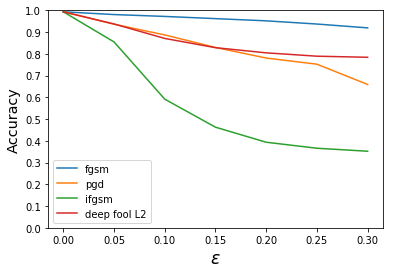

In [29]:
plt.plot(epsilons, fgsms, label = 'fgsm')
plt.plot(epsilons, pgds, label ="pgd")
plt.plot(epsilons, ifgsms, label = 'ifgsm')
plt.plot(epsilons, deepfools, label = 'deep fool L2')
plt.legend() 

plt.xlabel('$\epsilon$', size = 'xx-large', fontweight = 'demi')
plt.ylabel('Accuracy', size = 'x-large')
plt.ylim([0,1.0])
plt.yticks(np.linspace(0,1,11))
plt.savefig('figures/vafee4_111_classifier.pdf', format='pdf', bbox_inches='tight', quality = 100)
plt.show()